<a href="https://colab.research.google.com/github/HeisSteve/-Students-Knowledge-Status-Classification-modeling-/blob/main/Project_CIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project exploration

This is a exploration project on Convolutional Neural Networks (CNNs), and experimenting with different architectures on the CIFAR10 dataset.

# Loading dataset

In [3]:
import torch
from torchvision.datasets import CIFAR10
from torchvision import datasets, transforms

device = "cuda" if torch.cuda.is_available() else "cpu"

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = CIFAR10(root="data", train=True, download=True, transform=transform)
test_dataset = CIFAR10(root="data", train=False, download=True, transform=transform)

from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)



100%|██████████| 170M/170M [00:06<00:00, 26.0MB/s]


In [4]:
images, labels = next(iter(train_dataloader))
print(len(train_dataset))
print(len(test_dataset))
print("image shape:", images.shape)
print("Class names:", train_dataset.classes)
print("Number of classes:", len(train_dataset.classes))

50000
10000
image shape: torch.Size([32, 3, 32, 32])
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Number of classes: 10


In [5]:
from torch.utils.data import Subset
train_subset_size = 5000
train_indices = list(range(train_subset_size))
train_subset = Subset(train_dataset, train_indices)

train_subset_loader = DataLoader(train_subset, batch_size=32, shuffle=True)

test_subset_size = 1000
test_indices = list(range(test_subset_size))
test_subset = Subset(test_dataset, test_indices)

test_subset_loader = DataLoader(test_subset, batch_size=32, shuffle=True)

# Visiulizing dataset

Image dimensions: Width = 32, Height = 32, Channels = 3


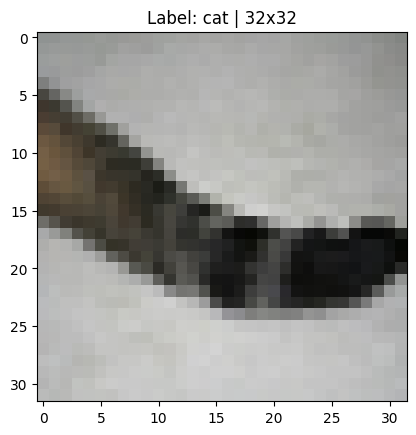

In [6]:
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
# Pick a random index
idx = random.randint(0, len(train_dataset) - 1)

# Get image and label
img, label = train_dataset[idx]  # img is a Tensor if transform applied, else PIL Image
class_name = train_dataset.classes[label]

channels, height, width = img.shape
print(f"Image dimensions: Width = {width}, Height = {height}, Channels = {channels}")

# Un-normalize for viewing
img = img / 2 + 0.5

# Convert tensor to numpy
np_img = np.transpose(img.numpy(), (1, 2, 0))

# Show image
plt.imshow(np_img)
plt.title(f"Label: {train_dataset.classes[label]} | {width}x{height}")
plt.show()

# Model setup and training and testing setup

The TinyVGG Model architecture if from:
    https://poloclub.github.io/cnn-explainer/
   

In [7]:
from torch import nn

# Recreate teh TinyVGG
class TinyVGGModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int, kernel_size:int ):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=kernel_size,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=kernel_size,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*8*8,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        return self.classifier(self.block_2(self.block_1(x)))
        #  print(x.shape)
        #  x = self.block_1(x)
        #  print(x.shape)
        #  x = self.block_2(x)
        #  print(x.shape)
        #  x = self.classifier(x)
        #  print(x.shape)
        #  return x

In [8]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 21.3 MB/s eta 0:00:00


In [9]:
def train_step(model, data_loader, loss_fn, optimizer, accuracy, device=device):
    train_loss, train_acc = 0, 0
    model.to(device)
    model.train()
    for X, y in data_loader:
        X, y = X.to(device), y.long().to(device)

        # Forward pass
        y_pred = model(X)

        # Loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Accuracy
        train_acc += accuracy(y_pred, y)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}")

def test_step(model, data_loader, loss_fn, accuracy, device=device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()

    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.long().to(device)
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y).item()
            test_acc += accuracy(test_pred, y)

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}\n")



In [10]:
from timeit import default_timer as timer
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch

def train_model(model, train_loader, test_loader, loss_fn, optimizer, accuracy_fn, epochs=3, device='cpu'):
    """
    Train and test a model while measuring the total time and collecting metrics.

    Args:
        model: PyTorch model
        train_loader: training DataLoader
        test_loader: testing DataLoader
        loss_fn: loss function
        optimizer: optimizer
        accuracy_fn: accuracy function (torchmetrics or manual)
        epochs: number of epochs
        device: torch device (CPU/GPU)
    """
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    start_time = timer()

    for epoch in tqdm(range(epochs), desc="Epochs"):
        print(f"Epoch: {epoch}\n---------")

        # ===== Training step =====
        model.train()
        running_loss = 0.0
        running_acc = 0.0
        total = 0

        for X, y in train_loader:
            X, y = X.to(device),  y.long().to(device)
            optimizer.zero_grad()
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * X.size(0)

            # Accuracy
            acc = accuracy_fn(y_pred, y)
            running_acc += acc.item() * X.size(0)
            total += X.size(0)

        epoch_train_loss = running_loss / total
        epoch_train_acc = running_acc / total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        print(f"Train loss: {epoch_train_loss:.5f} | Train accuracy: {epoch_train_acc*100:.2f}%")

        # ===== Testing step =====
        model.eval()
        running_loss = 0.0
        running_acc = 0.0
        total = 0
        with torch.no_grad():
            for X, y in test_loader:
                X, y = X.to(device),  y.long().to(device)
                y_pred = model(X)
                loss = loss_fn(y_pred, y)

                running_loss += loss.item() * X.size(0)

                # Accuracy
                acc = accuracy_fn(y_pred, y)
                running_acc += acc.item() * X.size(0)
                total += X.size(0)

        epoch_test_loss = running_loss / total
        epoch_test_acc = running_acc / total
        test_losses.append(epoch_test_loss)
        test_accuracies.append(epoch_test_acc)

        print(f"Test loss: {epoch_test_loss:.5f} | Test accuracy: {epoch_test_acc*100:.2f}%\n")

    end_time = timer()
    elapsed_time = end_time - start_time
    print(f"Training and testing took {elapsed_time:.3f} seconds")


    # ===== Plot results =====
    epochs_range = range(epochs)

    plt.figure(figsize=(12,5))

    # Loss plot
    plt.subplot(1,2,1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs Epoch')
    plt.legend()

    # Accuracy plot
    plt.subplot(1,2,2)
    plt.plot(epochs_range, [acc*100 for acc in train_accuracies], label='Train Accuracy')
    plt.plot(epochs_range, [acc*100 for acc in test_accuracies], label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy vs Epoch')
    plt.legend()

    plt.show()

    # return train_losses, test_losses, train_accuracies, test_accuracies

# Train and test

In [11]:

import torchmetrics
from torchmetrics import Accuracy

loss_fn = nn.CrossEntropyLoss().to(device)

accuracy = Accuracy(task="multiclass", num_classes=len(train_dataset.classes)).to(device)

In [14]:
model_1 = TinyVGGModel(3, 10, 10, 3).to(device)
model_1

optimizer_1 = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [15]:
# train_model(model_1,
#             train_dataloader,
#             test_dataloader,
#             loss_fn, optimizer_1,
#             accuracy, epochs=100,
#             device=device)

In [19]:
model_2 = TinyVGGModel(3, 32, 10, 3).to(device)
model_2
optimizer_2 = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 2.19710 | Train accuracy: 18.52%


Epochs:   2%|▏         | 1/50 [00:02<01:48,  2.22s/it]

Test loss: 2.32430 | Test accuracy: 19.10%

Epoch: 1
---------
Train loss: 1.87499 | Train accuracy: 32.96%


Epochs:   4%|▍         | 2/50 [00:04<01:45,  2.20s/it]

Test loss: 2.00686 | Test accuracy: 26.20%

Epoch: 2
---------
Train loss: 1.66635 | Train accuracy: 40.26%


Epochs:   6%|▌         | 3/50 [00:06<01:48,  2.32s/it]

Test loss: 1.72808 | Test accuracy: 34.80%

Epoch: 3
---------
Train loss: 1.52457 | Train accuracy: 45.60%


Epochs:   8%|▊         | 4/50 [00:09<01:45,  2.30s/it]

Test loss: 1.94433 | Test accuracy: 39.60%

Epoch: 4
---------
Train loss: 1.40638 | Train accuracy: 49.80%


Epochs:  10%|█         | 5/50 [00:11<01:50,  2.46s/it]

Test loss: 1.67913 | Test accuracy: 39.30%

Epoch: 5
---------
Train loss: 1.32168 | Train accuracy: 52.92%


Epochs:  12%|█▏        | 6/50 [00:14<01:44,  2.37s/it]

Test loss: 1.47245 | Test accuracy: 46.10%

Epoch: 6
---------
Train loss: 1.22761 | Train accuracy: 56.10%


Epochs:  14%|█▍        | 7/50 [00:16<01:39,  2.31s/it]

Test loss: 1.62901 | Test accuracy: 42.50%

Epoch: 7
---------
Train loss: 1.11056 | Train accuracy: 61.34%


Epochs:  16%|█▌        | 8/50 [00:18<01:34,  2.26s/it]

Test loss: 1.47062 | Test accuracy: 48.00%

Epoch: 8
---------
Train loss: 1.02445 | Train accuracy: 63.76%


Epochs:  18%|█▊        | 9/50 [00:20<01:31,  2.22s/it]

Test loss: 1.57817 | Test accuracy: 47.50%

Epoch: 9
---------
Train loss: 0.92861 | Train accuracy: 67.12%


Epochs:  20%|██        | 10/50 [00:23<01:32,  2.31s/it]

Test loss: 2.14855 | Test accuracy: 43.30%

Epoch: 10
---------
Train loss: 0.85992 | Train accuracy: 69.44%


Epochs:  22%|██▏       | 11/50 [00:25<01:31,  2.35s/it]

Test loss: 1.87104 | Test accuracy: 45.20%

Epoch: 11
---------
Train loss: 0.76888 | Train accuracy: 72.68%


Epochs:  24%|██▍       | 12/50 [00:28<01:32,  2.44s/it]

Test loss: 1.71102 | Test accuracy: 47.90%

Epoch: 12
---------
Train loss: 0.66890 | Train accuracy: 76.60%


Epochs:  26%|██▌       | 13/50 [00:30<01:30,  2.45s/it]

Test loss: 2.13602 | Test accuracy: 41.60%

Epoch: 13
---------
Train loss: 0.60591 | Train accuracy: 78.20%


Epochs:  28%|██▊       | 14/50 [00:32<01:26,  2.39s/it]

Test loss: 2.37880 | Test accuracy: 42.20%

Epoch: 14
---------
Train loss: 0.53692 | Train accuracy: 81.02%


Epochs:  30%|███       | 15/50 [00:35<01:25,  2.46s/it]

Test loss: 2.51872 | Test accuracy: 45.20%

Epoch: 15
---------
Train loss: 0.43634 | Train accuracy: 84.56%


Epochs:  32%|███▏      | 16/50 [00:38<01:27,  2.58s/it]

Test loss: 2.16493 | Test accuracy: 50.00%

Epoch: 16
---------
Train loss: 0.43443 | Train accuracy: 84.20%


Epochs:  34%|███▍      | 17/50 [00:40<01:23,  2.53s/it]

Test loss: 2.49031 | Test accuracy: 48.00%

Epoch: 17
---------
Train loss: 0.40704 | Train accuracy: 85.92%


Epochs:  36%|███▌      | 18/50 [00:42<01:17,  2.43s/it]

Test loss: 2.90832 | Test accuracy: 44.70%

Epoch: 18
---------
Train loss: 0.34898 | Train accuracy: 87.70%


Epochs:  38%|███▊      | 19/50 [00:45<01:13,  2.37s/it]

Test loss: 2.54956 | Test accuracy: 50.00%

Epoch: 19
---------
Train loss: 0.27246 | Train accuracy: 90.64%


Epochs:  40%|████      | 20/50 [00:47<01:14,  2.48s/it]

Test loss: 2.67078 | Test accuracy: 45.50%

Epoch: 20
---------
Train loss: 0.30351 | Train accuracy: 89.36%


Epochs:  42%|████▏     | 21/50 [00:50<01:09,  2.40s/it]

Test loss: 3.09185 | Test accuracy: 49.60%

Epoch: 21
---------
Train loss: 0.24413 | Train accuracy: 91.64%


Epochs:  44%|████▍     | 22/50 [00:52<01:05,  2.34s/it]

Test loss: 3.46030 | Test accuracy: 46.40%

Epoch: 22
---------
Train loss: 0.28293 | Train accuracy: 90.56%


Epochs:  46%|████▌     | 23/50 [00:54<01:01,  2.29s/it]

Test loss: 2.79437 | Test accuracy: 51.90%

Epoch: 23
---------
Train loss: 0.18932 | Train accuracy: 93.48%


Epochs:  48%|████▊     | 24/50 [00:56<00:58,  2.27s/it]

Test loss: 3.54875 | Test accuracy: 49.00%

Epoch: 24
---------
Train loss: 0.17802 | Train accuracy: 93.96%


Epochs:  50%|█████     | 25/50 [00:59<00:58,  2.33s/it]

Test loss: 3.32926 | Test accuracy: 48.50%

Epoch: 25
---------
Train loss: 0.18565 | Train accuracy: 93.46%


Epochs:  52%|█████▏    | 26/50 [01:01<00:56,  2.36s/it]

Test loss: 3.86666 | Test accuracy: 48.60%

Epoch: 26
---------
Train loss: 0.19102 | Train accuracy: 93.60%


Epochs:  54%|█████▍    | 27/50 [01:03<00:53,  2.31s/it]

Test loss: 4.02973 | Test accuracy: 50.20%

Epoch: 27
---------
Train loss: 0.20863 | Train accuracy: 93.08%


Epochs:  56%|█████▌    | 28/50 [01:06<00:50,  2.28s/it]

Test loss: 3.75319 | Test accuracy: 44.90%

Epoch: 28
---------
Train loss: 0.27810 | Train accuracy: 91.42%


Epochs:  58%|█████▊    | 29/50 [01:08<00:47,  2.24s/it]

Test loss: 3.11560 | Test accuracy: 46.10%

Epoch: 29
---------
Train loss: 0.15941 | Train accuracy: 94.60%


Epochs:  60%|██████    | 30/50 [01:10<00:45,  2.25s/it]

Test loss: 4.21395 | Test accuracy: 49.60%

Epoch: 30
---------
Train loss: 0.17649 | Train accuracy: 94.44%


Epochs:  62%|██████▏   | 31/50 [01:13<00:44,  2.35s/it]

Test loss: 6.48730 | Test accuracy: 43.70%

Epoch: 31
---------
Train loss: 0.20775 | Train accuracy: 93.26%


Epochs:  64%|██████▍   | 32/50 [01:15<00:41,  2.29s/it]

Test loss: 4.22638 | Test accuracy: 48.90%

Epoch: 32
---------
Train loss: 0.20034 | Train accuracy: 93.64%


Epochs:  66%|██████▌   | 33/50 [01:17<00:38,  2.25s/it]

Test loss: 4.08378 | Test accuracy: 48.20%

Epoch: 33
---------
Train loss: 0.17280 | Train accuracy: 94.44%


Epochs:  68%|██████▊   | 34/50 [01:19<00:35,  2.23s/it]

Test loss: 6.13626 | Test accuracy: 40.30%

Epoch: 34
---------
Train loss: 0.28186 | Train accuracy: 91.22%


Epochs:  70%|███████   | 35/50 [01:21<00:33,  2.23s/it]

Test loss: 4.56049 | Test accuracy: 46.10%

Epoch: 35
---------
Train loss: 0.20584 | Train accuracy: 93.22%


Epochs:  72%|███████▏  | 36/50 [01:24<00:33,  2.39s/it]

Test loss: 3.96945 | Test accuracy: 50.20%

Epoch: 36
---------
Train loss: 0.13060 | Train accuracy: 95.56%


Epochs:  74%|███████▍  | 37/50 [01:26<00:30,  2.34s/it]

Test loss: 4.77988 | Test accuracy: 48.30%

Epoch: 37
---------
Train loss: 0.08646 | Train accuracy: 97.08%


Epochs:  76%|███████▌  | 38/50 [01:28<00:27,  2.30s/it]

Test loss: 4.82450 | Test accuracy: 49.00%

Epoch: 38
---------
Train loss: 0.13539 | Train accuracy: 95.90%


Epochs:  78%|███████▊  | 39/50 [01:31<00:25,  2.28s/it]

Test loss: 4.20162 | Test accuracy: 51.10%

Epoch: 39
---------
Train loss: 0.17607 | Train accuracy: 94.58%


Epochs:  80%|████████  | 40/50 [01:33<00:22,  2.25s/it]

Test loss: 6.73097 | Test accuracy: 44.40%

Epoch: 40
---------
Train loss: 0.25003 | Train accuracy: 92.58%


Epochs:  82%|████████▏ | 41/50 [01:35<00:21,  2.36s/it]

Test loss: 5.35996 | Test accuracy: 47.00%

Epoch: 41
---------
Train loss: 0.29541 | Train accuracy: 91.40%


Epochs:  84%|████████▍ | 42/50 [01:38<00:18,  2.35s/it]

Test loss: 4.37708 | Test accuracy: 47.40%

Epoch: 42
---------
Train loss: 0.16615 | Train accuracy: 94.88%


Epochs:  86%|████████▌ | 43/50 [01:40<00:16,  2.30s/it]

Test loss: 4.65774 | Test accuracy: 49.30%

Epoch: 43
---------
Train loss: 0.18255 | Train accuracy: 94.38%


Epochs:  88%|████████▊ | 44/50 [01:42<00:13,  2.26s/it]

Test loss: 8.81673 | Test accuracy: 33.90%

Epoch: 44
---------
Train loss: 0.27281 | Train accuracy: 92.50%


Epochs:  90%|█████████ | 45/50 [01:44<00:11,  2.24s/it]

Test loss: 4.81248 | Test accuracy: 49.70%

Epoch: 45
---------
Train loss: 0.09567 | Train accuracy: 97.06%


Epochs:  92%|█████████▏| 46/50 [01:47<00:09,  2.28s/it]

Test loss: 5.11917 | Test accuracy: 50.00%

Epoch: 46
---------
Train loss: 0.10865 | Train accuracy: 96.58%


Epochs:  94%|█████████▍| 47/50 [01:49<00:07,  2.36s/it]

Test loss: 5.57119 | Test accuracy: 49.30%

Epoch: 47
---------
Train loss: 0.18805 | Train accuracy: 94.86%


Epochs:  96%|█████████▌| 48/50 [01:51<00:04,  2.32s/it]

Test loss: 5.02780 | Test accuracy: 46.50%

Epoch: 48
---------
Train loss: 0.24309 | Train accuracy: 93.08%


Epochs:  98%|█████████▊| 49/50 [01:54<00:02,  2.27s/it]

Test loss: 5.08973 | Test accuracy: 43.50%

Epoch: 49
---------
Train loss: 0.21699 | Train accuracy: 93.88%


Epochs: 100%|██████████| 50/50 [01:56<00:00,  2.33s/it]

Test loss: 5.87572 | Test accuracy: 47.30%

Training and testing took 116.373 seconds


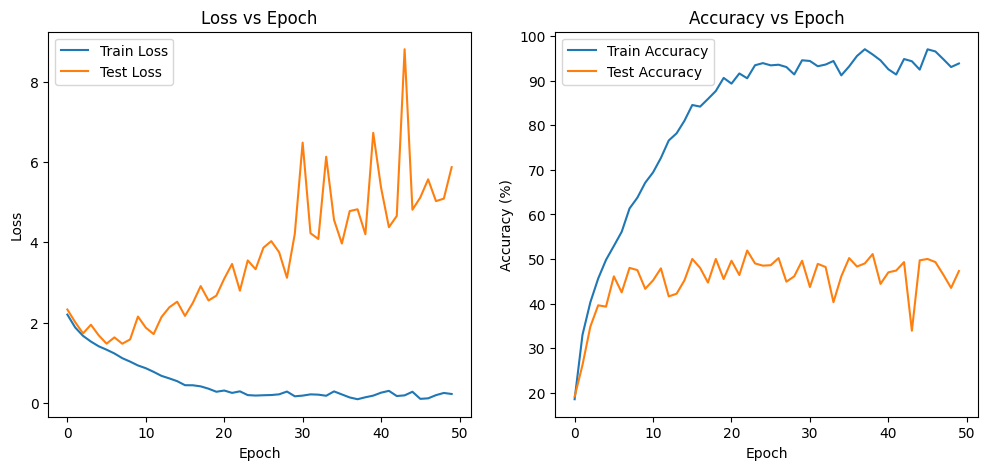

In [20]:
train_model(model_2,
            train_subset_loader,
            test_subset_loader,
            loss_fn, optimizer_2,
            accuracy, epochs=50,
            device=device)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 2.30220 | Train accuracy: 10.50%


Epochs:   2%|▏         | 1/50 [00:01<01:36,  1.96s/it]

Test loss: 2.28834 | Test accuracy: 13.70%

Epoch: 1
---------
Train loss: 2.15162 | Train accuracy: 20.96%


Epochs:   4%|▍         | 2/50 [00:03<01:28,  1.85s/it]

Test loss: 2.02174 | Test accuracy: 23.10%

Epoch: 2
---------
Train loss: 2.01539 | Train accuracy: 28.04%


Epochs:   6%|▌         | 3/50 [00:05<01:26,  1.84s/it]

Test loss: 2.90453 | Test accuracy: 12.70%

Epoch: 3
---------
Train loss: 1.97669 | Train accuracy: 29.20%


Epochs:   8%|▊         | 4/50 [00:07<01:28,  1.92s/it]

Test loss: 2.23083 | Test accuracy: 16.90%

Epoch: 4
---------
Train loss: 1.90751 | Train accuracy: 31.78%


Epochs:  10%|█         | 5/50 [00:09<01:30,  2.02s/it]

Test loss: 1.91239 | Test accuracy: 33.10%

Epoch: 5
---------
Train loss: 1.83378 | Train accuracy: 34.98%


Epochs:  12%|█▏        | 6/50 [00:11<01:26,  1.96s/it]

Test loss: 1.93181 | Test accuracy: 31.40%

Epoch: 6
---------
Train loss: 1.74626 | Train accuracy: 37.28%


Epochs:  14%|█▍        | 7/50 [00:13<01:22,  1.92s/it]

Test loss: 1.84334 | Test accuracy: 35.20%

Epoch: 7
---------
Train loss: 1.68560 | Train accuracy: 40.64%


Epochs:  16%|█▌        | 8/50 [00:15<01:19,  1.89s/it]

Test loss: 1.80289 | Test accuracy: 35.30%

Epoch: 8
---------
Train loss: 1.63060 | Train accuracy: 41.44%


Epochs:  18%|█▊        | 9/50 [00:17<01:16,  1.87s/it]

Test loss: 1.90239 | Test accuracy: 32.90%

Epoch: 9
---------
Train loss: 1.58394 | Train accuracy: 43.60%


Epochs:  20%|██        | 10/50 [00:18<01:14,  1.85s/it]

Test loss: 2.22380 | Test accuracy: 29.70%

Epoch: 10
---------
Train loss: 1.54919 | Train accuracy: 45.18%


Epochs:  22%|██▏       | 11/50 [00:21<01:18,  2.02s/it]

Test loss: 1.69709 | Test accuracy: 39.30%

Epoch: 11
---------
Train loss: 1.50367 | Train accuracy: 46.68%


Epochs:  24%|██▍       | 12/50 [00:23<01:15,  1.98s/it]

Test loss: 2.04669 | Test accuracy: 27.90%

Epoch: 12
---------
Train loss: 1.47678 | Train accuracy: 47.54%


Epochs:  26%|██▌       | 13/50 [00:25<01:12,  1.95s/it]

Test loss: 1.65989 | Test accuracy: 42.50%

Epoch: 13
---------
Train loss: 1.45804 | Train accuracy: 48.12%


Epochs:  28%|██▊       | 14/50 [00:28<01:21,  2.27s/it]

Test loss: 1.72376 | Test accuracy: 38.50%

Epoch: 14
---------
Train loss: 1.44164 | Train accuracy: 49.26%


Epochs:  30%|███       | 15/50 [00:30<01:17,  2.23s/it]

Test loss: 1.66194 | Test accuracy: 39.50%

Epoch: 15
---------
Train loss: 1.41762 | Train accuracy: 49.40%


Epochs:  32%|███▏      | 16/50 [00:32<01:15,  2.23s/it]

Test loss: 1.58463 | Test accuracy: 43.30%

Epoch: 16
---------
Train loss: 1.39190 | Train accuracy: 50.10%


Epochs:  34%|███▍      | 17/50 [00:35<01:20,  2.43s/it]

Test loss: 1.61460 | Test accuracy: 43.10%

Epoch: 17
---------
Train loss: 1.37709 | Train accuracy: 50.90%


Epochs:  36%|███▌      | 18/50 [00:37<01:11,  2.23s/it]

Test loss: 1.83700 | Test accuracy: 35.90%

Epoch: 18
---------
Train loss: 1.35674 | Train accuracy: 52.02%


Epochs:  38%|███▊      | 19/50 [00:38<01:05,  2.11s/it]

Test loss: 1.77895 | Test accuracy: 39.50%

Epoch: 19
---------
Train loss: 1.34964 | Train accuracy: 52.12%


Epochs:  40%|████      | 20/50 [00:40<01:00,  2.02s/it]

Test loss: 1.73675 | Test accuracy: 39.90%

Epoch: 20
---------
Train loss: 1.33978 | Train accuracy: 51.52%


Epochs:  42%|████▏     | 21/50 [00:42<00:56,  1.96s/it]

Test loss: 1.72285 | Test accuracy: 40.70%

Epoch: 21
---------
Train loss: 1.31859 | Train accuracy: 52.74%


Epochs:  44%|████▍     | 22/50 [00:44<00:57,  2.05s/it]

Test loss: 2.02672 | Test accuracy: 36.10%

Epoch: 22
---------
Train loss: 1.29116 | Train accuracy: 54.12%


Epochs:  46%|████▌     | 23/50 [00:46<00:54,  2.02s/it]

Test loss: 1.80520 | Test accuracy: 40.50%

Epoch: 23
---------
Train loss: 1.27528 | Train accuracy: 54.48%


Epochs:  48%|████▊     | 24/50 [00:49<01:00,  2.32s/it]

Test loss: 2.06327 | Test accuracy: 34.90%

Epoch: 24
---------
Train loss: 1.29617 | Train accuracy: 54.26%


Epochs:  50%|█████     | 25/50 [00:51<00:56,  2.24s/it]

Test loss: 1.70868 | Test accuracy: 43.60%

Epoch: 25
---------
Train loss: 1.27478 | Train accuracy: 54.76%


Epochs:  52%|█████▏    | 26/50 [00:54<00:58,  2.44s/it]

Test loss: 1.88283 | Test accuracy: 39.20%

Epoch: 26
---------
Train loss: 1.25718 | Train accuracy: 55.02%


Epochs:  54%|█████▍    | 27/50 [00:58<01:03,  2.74s/it]

Test loss: 2.27877 | Test accuracy: 36.60%

Epoch: 27
---------
Train loss: 1.25058 | Train accuracy: 56.42%


Epochs:  56%|█████▌    | 28/50 [01:00<00:54,  2.47s/it]

Test loss: 1.90677 | Test accuracy: 38.60%

Epoch: 28
---------
Train loss: 1.24127 | Train accuracy: 54.82%


Epochs:  58%|█████▊    | 29/50 [01:02<00:53,  2.55s/it]

Test loss: 2.13241 | Test accuracy: 38.40%

Epoch: 29
---------
Train loss: 1.22824 | Train accuracy: 56.54%


Epochs:  60%|██████    | 30/50 [01:04<00:48,  2.42s/it]

Test loss: 1.90275 | Test accuracy: 38.30%

Epoch: 30
---------
Train loss: 1.23452 | Train accuracy: 56.10%


Epochs:  62%|██████▏   | 31/50 [01:07<00:46,  2.45s/it]

Test loss: 1.93073 | Test accuracy: 35.60%

Epoch: 31
---------
Train loss: 1.22055 | Train accuracy: 56.28%


Epochs:  64%|██████▍   | 32/50 [01:09<00:44,  2.46s/it]

Test loss: 1.88200 | Test accuracy: 41.40%

Epoch: 32
---------
Train loss: 1.21018 | Train accuracy: 57.62%


Epochs:  66%|██████▌   | 33/50 [01:11<00:38,  2.28s/it]

Test loss: 1.76074 | Test accuracy: 41.40%

Epoch: 33
---------
Train loss: 1.20017 | Train accuracy: 57.08%


Epochs:  68%|██████▊   | 34/50 [01:13<00:34,  2.14s/it]

Test loss: 1.73347 | Test accuracy: 40.60%

Epoch: 34
---------
Train loss: 1.19587 | Train accuracy: 57.88%


Epochs:  70%|███████   | 35/50 [01:15<00:30,  2.05s/it]

Test loss: 1.76485 | Test accuracy: 38.20%

Epoch: 35
---------
Train loss: 1.20404 | Train accuracy: 57.40%


Epochs:  72%|███████▏  | 36/50 [01:17<00:27,  1.98s/it]

Test loss: 2.41355 | Test accuracy: 29.30%

Epoch: 36
---------
Train loss: 1.19817 | Train accuracy: 56.68%


Epochs:  74%|███████▍  | 37/50 [01:19<00:25,  1.93s/it]

Test loss: 1.81182 | Test accuracy: 38.90%

Epoch: 37
---------
Train loss: 1.17554 | Train accuracy: 58.14%


Epochs:  76%|███████▌  | 38/50 [01:21<00:24,  2.02s/it]

Test loss: 1.83719 | Test accuracy: 40.60%

Epoch: 38
---------
Train loss: 1.18098 | Train accuracy: 58.18%


Epochs:  78%|███████▊  | 39/50 [01:23<00:22,  2.04s/it]

Test loss: 2.57388 | Test accuracy: 31.10%

Epoch: 39
---------
Train loss: 1.17312 | Train accuracy: 58.18%


Epochs:  80%|████████  | 40/50 [01:25<00:19,  1.97s/it]

Test loss: 2.05132 | Test accuracy: 39.40%

Epoch: 40
---------
Train loss: 1.16292 | Train accuracy: 58.06%


Epochs:  82%|████████▏ | 41/50 [01:27<00:17,  1.92s/it]

Test loss: 1.88577 | Test accuracy: 38.00%

Epoch: 41
---------
Train loss: 1.15261 | Train accuracy: 58.32%


Epochs:  84%|████████▍ | 42/50 [01:28<00:15,  1.89s/it]

Test loss: 2.18178 | Test accuracy: 33.70%

Epoch: 42
---------
Train loss: 1.14705 | Train accuracy: 59.16%


Epochs:  86%|████████▌ | 43/50 [01:30<00:13,  1.87s/it]

Test loss: 1.85247 | Test accuracy: 40.60%

Epoch: 43
---------
Train loss: 1.14592 | Train accuracy: 59.50%


Epochs:  88%|████████▊ | 44/50 [01:32<00:11,  1.93s/it]

Test loss: 1.80137 | Test accuracy: 39.90%

Epoch: 44
---------
Train loss: 1.15309 | Train accuracy: 59.10%


Epochs:  90%|█████████ | 45/50 [01:34<00:10,  2.00s/it]

Test loss: 2.09097 | Test accuracy: 35.70%

Epoch: 45
---------
Train loss: 1.13969 | Train accuracy: 59.16%


Epochs:  92%|█████████▏| 46/50 [01:36<00:07,  1.95s/it]

Test loss: 1.88144 | Test accuracy: 39.50%

Epoch: 46
---------
Train loss: 1.15570 | Train accuracy: 59.12%


Epochs:  94%|█████████▍| 47/50 [01:38<00:05,  1.90s/it]

Test loss: 1.93705 | Test accuracy: 41.30%

Epoch: 47
---------
Train loss: 1.14507 | Train accuracy: 58.36%


Epochs:  96%|█████████▌| 48/50 [01:40<00:03,  1.87s/it]

Test loss: 2.13511 | Test accuracy: 35.50%

Epoch: 48
---------
Train loss: 1.16290 | Train accuracy: 58.24%


Epochs:  98%|█████████▊| 49/50 [01:42<00:01,  1.86s/it]

Test loss: 1.88266 | Test accuracy: 41.30%

Epoch: 49
---------
Train loss: 1.13286 | Train accuracy: 58.82%


Epochs: 100%|██████████| 50/50 [01:43<00:00,  2.08s/it]

Test loss: 1.94356 | Test accuracy: 37.50%

Training and testing took 103.980 seconds


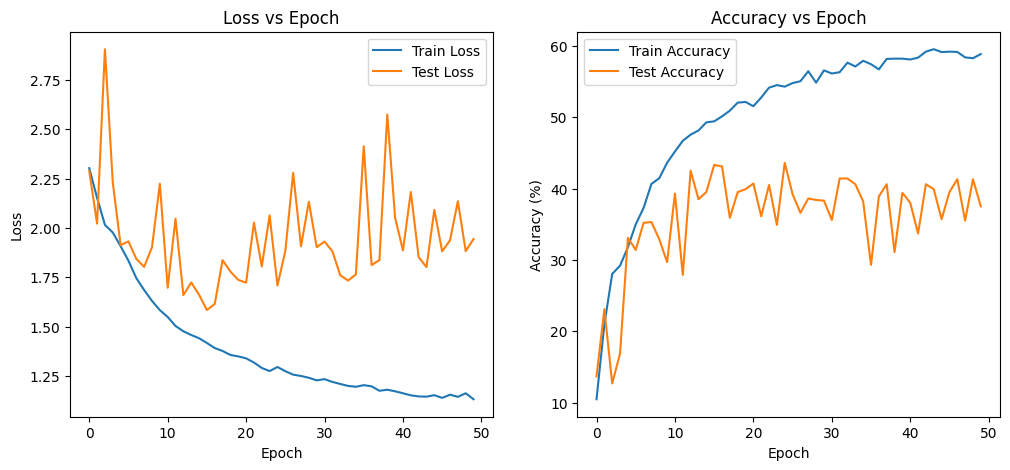

In [21]:
model_3 = TinyVGGModel(3, 5, 10, 3).to(device)
model_3
optimizer_3 = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.1)
train_model(model_3,
            train_subset_loader,
            test_subset_loader,
            loss_fn, optimizer_3,
            accuracy, epochs=50,
            device=device)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 2.24997 | Train accuracy: 14.82%


Epochs:   2%|▏         | 1/50 [00:01<01:34,  1.92s/it]

Test loss: 2.17899 | Test accuracy: 24.70%

Epoch: 1
---------
Train loss: 2.00930 | Train accuracy: 26.92%


Epochs:   4%|▍         | 2/50 [00:03<01:31,  1.91s/it]

Test loss: 2.05053 | Test accuracy: 24.50%

Epoch: 2
---------
Train loss: 1.85228 | Train accuracy: 33.32%


Epochs:   6%|▌         | 3/50 [00:05<01:29,  1.90s/it]

Test loss: 1.81518 | Test accuracy: 34.20%

Epoch: 3
---------
Train loss: 1.72576 | Train accuracy: 36.64%


Epochs:   8%|▊         | 4/50 [00:07<01:26,  1.89s/it]

Test loss: 1.78895 | Test accuracy: 33.50%

Epoch: 4
---------
Train loss: 1.65462 | Train accuracy: 40.72%


Epochs:  10%|█         | 5/50 [00:09<01:27,  1.95s/it]

Test loss: 1.73016 | Test accuracy: 35.40%

Epoch: 5
---------
Train loss: 1.56025 | Train accuracy: 43.58%


Epochs:  12%|█▏        | 6/50 [00:11<01:31,  2.07s/it]

Test loss: 1.77964 | Test accuracy: 35.40%

Epoch: 6
---------
Train loss: 1.48988 | Train accuracy: 45.92%


Epochs:  14%|█▍        | 7/50 [00:13<01:26,  2.00s/it]

Test loss: 1.69663 | Test accuracy: 37.30%

Epoch: 7
---------
Train loss: 1.43099 | Train accuracy: 48.92%


Epochs:  16%|█▌        | 8/50 [00:15<01:22,  1.97s/it]

Test loss: 1.83906 | Test accuracy: 38.10%

Epoch: 8
---------
Train loss: 1.38483 | Train accuracy: 50.84%


Epochs:  18%|█▊        | 9/50 [00:17<01:19,  1.95s/it]

Test loss: 1.63543 | Test accuracy: 38.40%

Epoch: 9
---------
Train loss: 1.30918 | Train accuracy: 53.60%


Epochs:  20%|██        | 10/50 [00:19<01:19,  1.98s/it]

Test loss: 1.78520 | Test accuracy: 37.10%

Epoch: 10
---------
Train loss: 1.30508 | Train accuracy: 53.16%


Epochs:  22%|██▏       | 11/50 [00:21<01:18,  2.01s/it]

Test loss: 2.34872 | Test accuracy: 35.40%

Epoch: 11
---------
Train loss: 1.23270 | Train accuracy: 56.96%


Epochs:  24%|██▍       | 12/50 [00:24<01:19,  2.10s/it]

Test loss: 1.83182 | Test accuracy: 40.50%

Epoch: 12
---------
Train loss: 1.17952 | Train accuracy: 58.16%


Epochs:  26%|██▌       | 13/50 [00:25<01:15,  2.03s/it]

Test loss: 1.91783 | Test accuracy: 37.40%

Epoch: 13
---------
Train loss: 1.14525 | Train accuracy: 59.50%


Epochs:  28%|██▊       | 14/50 [00:27<01:11,  1.99s/it]

Test loss: 1.66575 | Test accuracy: 46.20%

Epoch: 14
---------
Train loss: 1.10887 | Train accuracy: 60.88%


Epochs:  30%|███       | 15/50 [00:29<01:08,  1.96s/it]

Test loss: 1.83497 | Test accuracy: 39.60%

Epoch: 15
---------
Train loss: 1.08573 | Train accuracy: 62.24%


Epochs:  32%|███▏      | 16/50 [00:31<01:05,  1.93s/it]

Test loss: 1.77806 | Test accuracy: 39.70%

Epoch: 16
---------
Train loss: 1.05622 | Train accuracy: 62.48%


Epochs:  34%|███▍      | 17/50 [00:33<01:04,  1.96s/it]

Test loss: 1.67427 | Test accuracy: 44.30%

Epoch: 17
---------
Train loss: 1.03278 | Train accuracy: 63.44%


Epochs:  36%|███▌      | 18/50 [00:35<01:06,  2.08s/it]

Test loss: 2.30370 | Test accuracy: 37.60%

Epoch: 18
---------
Train loss: 0.99828 | Train accuracy: 64.86%


Epochs:  38%|███▊      | 19/50 [00:37<01:02,  2.02s/it]

Test loss: 1.83589 | Test accuracy: 45.30%

Epoch: 19
---------
Train loss: 0.98590 | Train accuracy: 65.22%


Epochs:  40%|████      | 20/50 [00:39<00:59,  1.98s/it]

Test loss: 2.24423 | Test accuracy: 39.00%

Epoch: 20
---------
Train loss: 0.96167 | Train accuracy: 65.78%


Epochs:  42%|████▏     | 21/50 [00:41<00:56,  1.95s/it]

Test loss: 1.85803 | Test accuracy: 45.20%

Epoch: 21
---------
Train loss: 0.93398 | Train accuracy: 67.12%


Epochs:  44%|████▍     | 22/50 [00:43<00:53,  1.92s/it]

Test loss: 2.09277 | Test accuracy: 41.20%

Epoch: 22
---------
Train loss: 0.93236 | Train accuracy: 66.44%


Epochs:  46%|████▌     | 23/50 [00:45<00:51,  1.92s/it]

Test loss: 2.14174 | Test accuracy: 40.50%

Epoch: 23
---------
Train loss: 0.90946 | Train accuracy: 67.70%


Epochs:  48%|████▊     | 24/50 [00:47<00:54,  2.09s/it]

Test loss: 1.88749 | Test accuracy: 44.50%

Epoch: 24
---------
Train loss: 0.88036 | Train accuracy: 69.22%


Epochs:  50%|█████     | 25/50 [00:49<00:50,  2.02s/it]

Test loss: 2.34635 | Test accuracy: 36.80%

Epoch: 25
---------
Train loss: 0.86844 | Train accuracy: 69.66%


Epochs:  52%|█████▏    | 26/50 [00:51<00:47,  1.99s/it]

Test loss: 2.13108 | Test accuracy: 42.60%

Epoch: 26
---------
Train loss: 0.87053 | Train accuracy: 69.72%


Epochs:  54%|█████▍    | 27/50 [00:53<00:45,  1.96s/it]

Test loss: 2.29738 | Test accuracy: 34.60%

Epoch: 27
---------
Train loss: 0.84960 | Train accuracy: 70.10%


Epochs:  56%|█████▌    | 28/50 [00:55<00:42,  1.94s/it]

Test loss: 1.91759 | Test accuracy: 45.90%

Epoch: 28
---------
Train loss: 0.83656 | Train accuracy: 70.24%


Epochs:  58%|█████▊    | 29/50 [00:57<00:40,  1.92s/it]

Test loss: 2.86468 | Test accuracy: 34.30%

Epoch: 29
---------
Train loss: 0.86519 | Train accuracy: 69.52%


Epochs:  60%|██████    | 30/50 [00:59<00:41,  2.09s/it]

Test loss: 2.46211 | Test accuracy: 41.00%

Epoch: 30
---------
Train loss: 0.81491 | Train accuracy: 71.18%


Epochs:  62%|██████▏   | 31/50 [01:01<00:38,  2.03s/it]

Test loss: 2.36792 | Test accuracy: 43.20%

Epoch: 31
---------
Train loss: 0.82202 | Train accuracy: 71.46%


Epochs:  64%|██████▍   | 32/50 [01:03<00:35,  1.99s/it]

Test loss: 2.35040 | Test accuracy: 43.60%

Epoch: 32
---------
Train loss: 0.81047 | Train accuracy: 71.72%


Epochs:  66%|██████▌   | 33/50 [01:05<00:33,  1.96s/it]

Test loss: 2.15801 | Test accuracy: 45.40%

Epoch: 33
---------
Train loss: 0.77011 | Train accuracy: 72.20%


Epochs:  68%|██████▊   | 34/50 [01:07<00:30,  1.93s/it]

Test loss: 2.67695 | Test accuracy: 36.30%

Epoch: 34
---------
Train loss: 0.80708 | Train accuracy: 71.80%


Epochs:  70%|███████   | 35/50 [01:09<00:28,  1.91s/it]

Test loss: 2.36833 | Test accuracy: 43.50%

Epoch: 35
---------
Train loss: 0.78129 | Train accuracy: 72.54%


Epochs:  72%|███████▏  | 36/50 [01:11<00:28,  2.07s/it]

Test loss: 2.27920 | Test accuracy: 40.70%

Epoch: 36
---------
Train loss: 0.74809 | Train accuracy: 73.16%


Epochs:  74%|███████▍  | 37/50 [01:13<00:26,  2.00s/it]

Test loss: 2.25898 | Test accuracy: 41.80%

Epoch: 37
---------
Train loss: 0.74184 | Train accuracy: 73.18%


Epochs:  76%|███████▌  | 38/50 [01:15<00:23,  1.96s/it]

Test loss: 2.73324 | Test accuracy: 40.30%

Epoch: 38
---------
Train loss: 0.75976 | Train accuracy: 72.84%


Epochs:  78%|███████▊  | 39/50 [01:17<00:21,  1.94s/it]

Test loss: 2.09375 | Test accuracy: 43.20%

Epoch: 39
---------
Train loss: 0.74745 | Train accuracy: 73.44%


Epochs:  80%|████████  | 40/50 [01:19<00:19,  1.92s/it]

Test loss: 2.42006 | Test accuracy: 42.50%

Epoch: 40
---------
Train loss: 0.75211 | Train accuracy: 73.88%


Epochs:  82%|████████▏ | 41/50 [01:20<00:17,  1.91s/it]

Test loss: 2.36727 | Test accuracy: 41.00%

Epoch: 41
---------
Train loss: 0.74973 | Train accuracy: 73.24%


Epochs:  84%|████████▍ | 42/50 [01:23<00:16,  2.07s/it]

Test loss: 2.38183 | Test accuracy: 42.60%

Epoch: 42
---------
Train loss: 0.75780 | Train accuracy: 73.54%


Epochs:  86%|████████▌ | 43/50 [01:25<00:14,  2.04s/it]

Test loss: 2.56541 | Test accuracy: 42.40%

Epoch: 43
---------
Train loss: 0.74031 | Train accuracy: 73.92%


Epochs:  88%|████████▊ | 44/50 [01:27<00:11,  1.99s/it]

Test loss: 2.41044 | Test accuracy: 38.30%

Epoch: 44
---------
Train loss: 0.72820 | Train accuracy: 74.24%


Epochs:  90%|█████████ | 45/50 [01:29<00:09,  1.97s/it]

Test loss: 3.35227 | Test accuracy: 38.50%

Epoch: 45
---------
Train loss: 0.72147 | Train accuracy: 74.56%


Epochs:  92%|█████████▏| 46/50 [01:31<00:07,  1.96s/it]

Test loss: 2.52025 | Test accuracy: 42.50%

Epoch: 46
---------
Train loss: 0.68816 | Train accuracy: 76.58%


Epochs:  94%|█████████▍| 47/50 [01:33<00:05,  1.94s/it]

Test loss: 3.61909 | Test accuracy: 37.50%

Epoch: 47
---------
Train loss: 0.72933 | Train accuracy: 74.14%


Epochs:  96%|█████████▌| 48/50 [01:35<00:04,  2.11s/it]

Test loss: 2.71280 | Test accuracy: 39.60%

Epoch: 48
---------
Train loss: 0.70466 | Train accuracy: 75.42%


Epochs:  98%|█████████▊| 49/50 [01:37<00:02,  2.06s/it]

Test loss: 4.87846 | Test accuracy: 34.30%

Epoch: 49
---------
Train loss: 0.70605 | Train accuracy: 75.84%


Epochs: 100%|██████████| 50/50 [01:39<00:00,  1.99s/it]

Test loss: 2.64543 | Test accuracy: 40.50%

Training and testing took 99.388 seconds


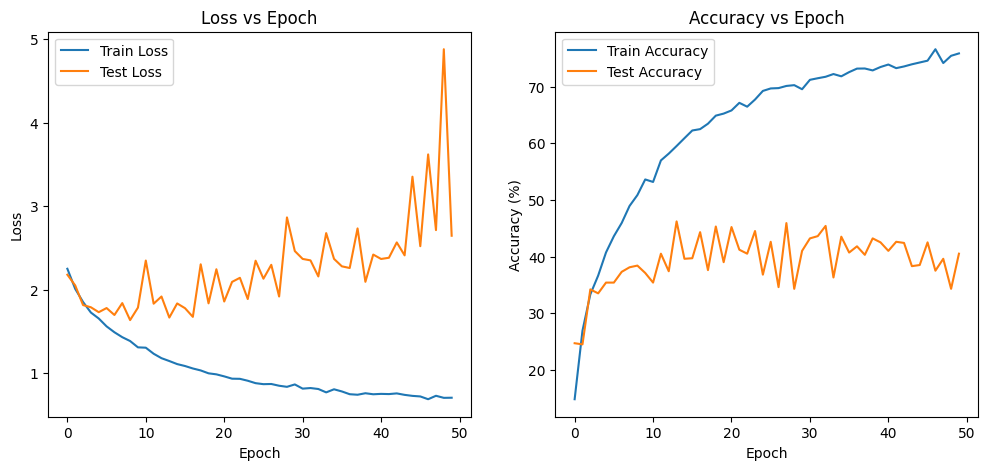

In [24]:
model_4 = TinyVGGModel(3, 10, 10, 2).to(device)
model_4

optimizer_4 = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)
train_model(model_4,
            train_subset_loader,
            test_subset_loader,
            loss_fn, optimizer_4,
            accuracy, epochs=50,
            device=device)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 2.21725 | Train accuracy: 17.88%


Epochs:   2%|▏         | 1/50 [00:01<01:34,  1.93s/it]

Test loss: 2.11519 | Test accuracy: 23.00%

Epoch: 1
---------
Train loss: 1.97586 | Train accuracy: 29.62%


Epochs:   4%|▍         | 2/50 [00:03<01:31,  1.90s/it]

Test loss: 2.67044 | Test accuracy: 21.30%

Epoch: 2
---------
Train loss: 1.81212 | Train accuracy: 35.56%


Epochs:   6%|▌         | 3/50 [00:05<01:27,  1.87s/it]

Test loss: 1.87669 | Test accuracy: 30.90%

Epoch: 3
---------
Train loss: 1.68362 | Train accuracy: 38.92%


Epochs:   8%|▊         | 4/50 [00:07<01:25,  1.86s/it]

Test loss: 1.68860 | Test accuracy: 37.70%

Epoch: 4
---------
Train loss: 1.60569 | Train accuracy: 42.48%


Epochs:  10%|█         | 5/50 [00:09<01:27,  1.95s/it]

Test loss: 1.85518 | Test accuracy: 33.70%

Epoch: 5
---------
Train loss: 1.47469 | Train accuracy: 46.50%


Epochs:  12%|█▏        | 6/50 [00:11<01:29,  2.04s/it]

Test loss: 1.52613 | Test accuracy: 46.50%

Epoch: 6
---------
Train loss: 1.41273 | Train accuracy: 49.52%


Epochs:  14%|█▍        | 7/50 [00:13<01:25,  1.99s/it]

Test loss: 1.67403 | Test accuracy: 39.50%

Epoch: 7
---------
Train loss: 1.36775 | Train accuracy: 50.84%


Epochs:  16%|█▌        | 8/50 [00:15<01:21,  1.94s/it]

Test loss: 1.53059 | Test accuracy: 45.90%

Epoch: 8
---------
Train loss: 1.32253 | Train accuracy: 51.96%


Epochs:  18%|█▊        | 9/50 [00:17<01:18,  1.91s/it]

Test loss: 1.63368 | Test accuracy: 42.10%

Epoch: 9
---------
Train loss: 1.27719 | Train accuracy: 54.54%


Epochs:  20%|██        | 10/50 [00:19<01:16,  1.92s/it]

Test loss: 1.98517 | Test accuracy: 37.50%

Epoch: 10
---------
Train loss: 1.24447 | Train accuracy: 55.42%


Epochs:  22%|██▏       | 11/50 [00:21<01:16,  1.95s/it]

Test loss: 1.72132 | Test accuracy: 38.30%

Epoch: 11
---------
Train loss: 1.19155 | Train accuracy: 57.96%


Epochs:  24%|██▍       | 12/50 [00:23<01:18,  2.06s/it]

Test loss: 1.51550 | Test accuracy: 48.40%

Epoch: 12
---------
Train loss: 1.16788 | Train accuracy: 58.46%


Epochs:  26%|██▌       | 13/50 [00:25<01:13,  2.00s/it]

Test loss: 1.79511 | Test accuracy: 38.10%

Epoch: 13
---------
Train loss: 1.12832 | Train accuracy: 59.42%


Epochs:  28%|██▊       | 14/50 [00:27<01:10,  1.96s/it]

Test loss: 2.12490 | Test accuracy: 34.10%

Epoch: 14
---------
Train loss: 1.11408 | Train accuracy: 60.18%


Epochs:  30%|███       | 15/50 [00:29<01:07,  1.93s/it]

Test loss: 1.90707 | Test accuracy: 37.00%

Epoch: 15
---------
Train loss: 1.08585 | Train accuracy: 61.36%


Epochs:  32%|███▏      | 16/50 [00:31<01:04,  1.91s/it]

Test loss: 1.71117 | Test accuracy: 44.50%

Epoch: 16
---------
Train loss: 1.04454 | Train accuracy: 63.08%


Epochs:  34%|███▍      | 17/50 [00:32<01:02,  1.89s/it]

Test loss: 2.10541 | Test accuracy: 39.90%

Epoch: 17
---------
Train loss: 1.02392 | Train accuracy: 63.26%


Epochs:  36%|███▌      | 18/50 [00:35<01:06,  2.09s/it]

Test loss: 2.12299 | Test accuracy: 35.10%

Epoch: 18
---------
Train loss: 1.02305 | Train accuracy: 63.18%


Epochs:  38%|███▊      | 19/50 [00:37<01:02,  2.01s/it]

Test loss: 2.38781 | Test accuracy: 41.00%

Epoch: 19
---------
Train loss: 0.97096 | Train accuracy: 65.50%


Epochs:  40%|████      | 20/50 [00:39<00:58,  1.96s/it]

Test loss: 1.71759 | Test accuracy: 41.60%

Epoch: 20
---------
Train loss: 0.96759 | Train accuracy: 65.48%


Epochs:  42%|████▏     | 21/50 [00:40<00:55,  1.92s/it]

Test loss: 2.04763 | Test accuracy: 43.00%

Epoch: 21
---------
Train loss: 0.93961 | Train accuracy: 66.60%


Epochs:  44%|████▍     | 22/50 [00:42<00:53,  1.90s/it]

Test loss: 1.87629 | Test accuracy: 44.70%

Epoch: 22
---------
Train loss: 0.91583 | Train accuracy: 67.80%


Epochs:  46%|████▌     | 23/50 [00:44<00:50,  1.88s/it]

Test loss: 2.22024 | Test accuracy: 40.40%

Epoch: 23
---------
Train loss: 0.88912 | Train accuracy: 68.94%


Epochs:  48%|████▊     | 24/50 [00:47<00:52,  2.03s/it]

Test loss: 2.29153 | Test accuracy: 37.50%

Epoch: 24
---------
Train loss: 0.87915 | Train accuracy: 68.56%


Epochs:  50%|█████     | 25/50 [00:48<00:49,  1.99s/it]

Test loss: 1.93386 | Test accuracy: 45.00%

Epoch: 25
---------
Train loss: 0.85415 | Train accuracy: 70.62%


Epochs:  52%|█████▏    | 26/50 [00:50<00:46,  1.93s/it]

Test loss: 2.69775 | Test accuracy: 31.80%

Epoch: 26
---------
Train loss: 0.88372 | Train accuracy: 68.22%


Epochs:  54%|█████▍    | 27/50 [00:52<00:43,  1.90s/it]

Test loss: 1.98113 | Test accuracy: 42.40%

Epoch: 27
---------
Train loss: 0.84571 | Train accuracy: 69.44%


Epochs:  56%|█████▌    | 28/50 [00:54<00:41,  1.89s/it]

Test loss: 3.21244 | Test accuracy: 28.80%

Epoch: 28
---------
Train loss: 0.84327 | Train accuracy: 69.54%


Epochs:  58%|█████▊    | 29/50 [00:56<00:39,  1.88s/it]

Test loss: 2.04418 | Test accuracy: 44.70%

Epoch: 29
---------
Train loss: 0.81723 | Train accuracy: 71.12%


Epochs:  60%|██████    | 30/50 [00:58<00:39,  1.98s/it]

Test loss: 2.11992 | Test accuracy: 43.20%

Epoch: 30
---------
Train loss: 0.80018 | Train accuracy: 71.16%


Epochs:  62%|██████▏   | 31/50 [01:00<00:38,  2.03s/it]

Test loss: 1.99274 | Test accuracy: 42.90%

Epoch: 31
---------
Train loss: 0.79437 | Train accuracy: 71.82%


Epochs:  64%|██████▍   | 32/50 [01:02<00:35,  1.99s/it]

Test loss: 3.12504 | Test accuracy: 36.40%

Epoch: 32
---------
Train loss: 0.83389 | Train accuracy: 71.46%


Epochs:  66%|██████▌   | 33/50 [01:04<00:33,  1.94s/it]

Test loss: 2.23346 | Test accuracy: 42.20%

Epoch: 33
---------
Train loss: 0.80424 | Train accuracy: 70.18%


Epochs:  68%|██████▊   | 34/50 [01:06<00:30,  1.91s/it]

Test loss: 2.45345 | Test accuracy: 39.20%

Epoch: 34
---------
Train loss: 0.77452 | Train accuracy: 72.16%


Epochs:  70%|███████   | 35/50 [01:08<00:28,  1.89s/it]

Test loss: 2.50161 | Test accuracy: 38.90%

Epoch: 35
---------
Train loss: 0.79732 | Train accuracy: 71.24%


Epochs:  72%|███████▏  | 36/50 [01:10<00:27,  1.96s/it]

Test loss: 2.09745 | Test accuracy: 44.20%

Epoch: 36
---------
Train loss: 0.76846 | Train accuracy: 73.16%


Epochs:  74%|███████▍  | 37/50 [01:12<00:26,  2.03s/it]

Test loss: 2.38437 | Test accuracy: 43.80%

Epoch: 37
---------
Train loss: 0.77641 | Train accuracy: 72.54%


Epochs:  76%|███████▌  | 38/50 [01:14<00:23,  1.97s/it]

Test loss: 2.44544 | Test accuracy: 43.10%

Epoch: 38
---------
Train loss: 0.76721 | Train accuracy: 72.88%


Epochs:  78%|███████▊  | 39/50 [01:16<00:21,  1.93s/it]

Test loss: 2.31788 | Test accuracy: 43.60%

Epoch: 39
---------
Train loss: 0.75014 | Train accuracy: 72.70%


Epochs:  80%|████████  | 40/50 [01:17<00:19,  1.90s/it]

Test loss: 2.79466 | Test accuracy: 38.90%

Epoch: 40
---------
Train loss: 0.74699 | Train accuracy: 73.98%


Epochs:  82%|████████▏ | 41/50 [01:19<00:17,  1.90s/it]

Test loss: 3.37136 | Test accuracy: 37.50%

Epoch: 41
---------
Train loss: 0.78379 | Train accuracy: 72.18%


Epochs:  84%|████████▍ | 42/50 [01:21<00:15,  1.94s/it]

Test loss: 2.60498 | Test accuracy: 39.60%

Epoch: 42
---------
Train loss: 0.75607 | Train accuracy: 72.88%


Epochs:  86%|████████▌ | 43/50 [01:24<00:14,  2.04s/it]

Test loss: 2.51547 | Test accuracy: 39.00%

Epoch: 43
---------
Train loss: 0.72999 | Train accuracy: 74.08%


Epochs:  88%|████████▊ | 44/50 [01:25<00:11,  1.99s/it]

Test loss: 2.86977 | Test accuracy: 39.80%

Epoch: 44
---------
Train loss: 0.71830 | Train accuracy: 74.06%


Epochs:  90%|█████████ | 45/50 [01:27<00:09,  1.95s/it]

Test loss: 2.83829 | Test accuracy: 36.90%

Epoch: 45
---------
Train loss: 0.76697 | Train accuracy: 72.94%


Epochs:  92%|█████████▏| 46/50 [01:29<00:07,  1.92s/it]

Test loss: 2.52893 | Test accuracy: 41.30%

Epoch: 46
---------
Train loss: 0.77141 | Train accuracy: 73.48%


Epochs:  94%|█████████▍| 47/50 [01:31<00:05,  1.90s/it]

Test loss: 2.84030 | Test accuracy: 36.40%

Epoch: 47
---------
Train loss: 0.71831 | Train accuracy: 73.90%


Epochs:  96%|█████████▌| 48/50 [01:33<00:03,  1.89s/it]

Test loss: 2.56628 | Test accuracy: 42.40%

Epoch: 48
---------
Train loss: 0.71965 | Train accuracy: 74.52%


Epochs:  98%|█████████▊| 49/50 [01:35<00:02,  2.05s/it]

Test loss: 3.60012 | Test accuracy: 39.90%

Epoch: 49
---------
Train loss: 0.77137 | Train accuracy: 73.36%


Epochs: 100%|██████████| 50/50 [01:37<00:00,  1.95s/it]

Test loss: 2.57899 | Test accuracy: 45.20%

Training and testing took 97.598 seconds


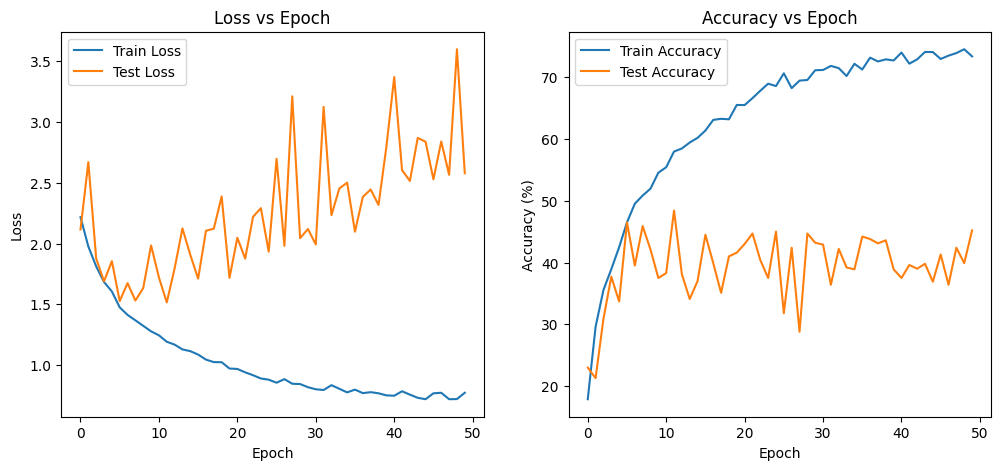

In [23]:
model_1 = TinyVGGModel(3, 10, 10, 3).to(device)
model_1

optimizer_1 = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)
train_model(model_1,
            train_subset_loader,
            test_subset_loader,
            loss_fn, optimizer_1,
            accuracy, epochs=50,
            device=device)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 2.22442 | Train accuracy: 16.56%


Epochs:   2%|▏         | 1/50 [00:02<01:48,  2.21s/it]

Test loss: 2.08740 | Test accuracy: 20.00%

Epoch: 1
---------
Train loss: 1.93738 | Train accuracy: 29.74%


Epochs:   4%|▍         | 2/50 [00:04<01:45,  2.20s/it]

Test loss: 1.79683 | Test accuracy: 35.70%

Epoch: 2
---------
Train loss: 1.73867 | Train accuracy: 37.10%


Epochs:   6%|▌         | 3/50 [00:06<01:50,  2.34s/it]

Test loss: 1.84493 | Test accuracy: 33.60%

Epoch: 3
---------
Train loss: 1.61509 | Train accuracy: 41.90%


Epochs:   8%|▊         | 4/50 [00:09<01:50,  2.40s/it]

Test loss: 2.27195 | Test accuracy: 29.90%

Epoch: 4
---------
Train loss: 1.49994 | Train accuracy: 47.18%


Epochs:  10%|█         | 5/50 [00:11<01:44,  2.32s/it]

Test loss: 1.57781 | Test accuracy: 42.40%

Epoch: 5
---------
Train loss: 1.39992 | Train accuracy: 49.68%


Epochs:  12%|█▏        | 6/50 [00:13<01:40,  2.28s/it]

Test loss: 1.61725 | Test accuracy: 40.80%

Epoch: 6
---------
Train loss: 1.30141 | Train accuracy: 53.08%


Epochs:  14%|█▍        | 7/50 [00:16<01:43,  2.41s/it]

Test loss: 1.53805 | Test accuracy: 45.50%

Epoch: 7
---------
Train loss: 1.21182 | Train accuracy: 56.94%


Epochs:  16%|█▌        | 8/50 [00:18<01:42,  2.43s/it]

Test loss: 1.43225 | Test accuracy: 48.50%

Epoch: 8
---------
Train loss: 1.11834 | Train accuracy: 59.92%


Epochs:  18%|█▊        | 9/50 [00:21<01:40,  2.45s/it]

Test loss: 1.64552 | Test accuracy: 45.80%

Epoch: 9
---------
Train loss: 1.03652 | Train accuracy: 62.34%


Epochs:  20%|██        | 10/50 [00:23<01:34,  2.36s/it]

Test loss: 1.64602 | Test accuracy: 43.90%

Epoch: 10
---------
Train loss: 0.95564 | Train accuracy: 65.52%


Epochs:  22%|██▏       | 11/50 [00:25<01:29,  2.30s/it]

Test loss: 2.82698 | Test accuracy: 28.50%

Epoch: 11
---------
Train loss: 0.88878 | Train accuracy: 68.70%


Epochs:  24%|██▍       | 12/50 [00:27<01:25,  2.26s/it]

Test loss: 1.59174 | Test accuracy: 47.10%

Epoch: 12
---------
Train loss: 0.81290 | Train accuracy: 71.12%


Epochs:  26%|██▌       | 13/50 [00:30<01:23,  2.25s/it]

Test loss: 1.97546 | Test accuracy: 45.00%

Epoch: 13
---------
Train loss: 0.75107 | Train accuracy: 73.26%


Epochs:  28%|██▊       | 14/50 [00:32<01:25,  2.37s/it]

Test loss: 1.87124 | Test accuracy: 45.00%

Epoch: 14
---------
Train loss: 0.68285 | Train accuracy: 76.16%


Epochs:  30%|███       | 15/50 [00:34<01:21,  2.32s/it]

Test loss: 2.09196 | Test accuracy: 44.80%

Epoch: 15
---------
Train loss: 0.64015 | Train accuracy: 77.28%


Epochs:  32%|███▏      | 16/50 [00:37<01:17,  2.28s/it]

Test loss: 2.13634 | Test accuracy: 42.90%

Epoch: 16
---------
Train loss: 0.57220 | Train accuracy: 79.40%


Epochs:  34%|███▍      | 17/50 [00:39<01:14,  2.26s/it]

Test loss: 2.28974 | Test accuracy: 43.90%

Epoch: 17
---------
Train loss: 0.55453 | Train accuracy: 80.26%


Epochs:  36%|███▌      | 18/50 [00:41<01:11,  2.23s/it]

Test loss: 2.16575 | Test accuracy: 46.30%

Epoch: 18
---------
Train loss: 0.50007 | Train accuracy: 82.50%


Epochs:  38%|███▊      | 19/50 [00:44<01:14,  2.39s/it]

Test loss: 2.84962 | Test accuracy: 41.80%

Epoch: 19
---------
Train loss: 0.50292 | Train accuracy: 81.76%


Epochs:  40%|████      | 20/50 [00:46<01:09,  2.32s/it]

Test loss: 2.54984 | Test accuracy: 43.50%

Epoch: 20
---------
Train loss: 0.41677 | Train accuracy: 85.02%


Epochs:  42%|████▏     | 21/50 [00:48<01:06,  2.29s/it]

Test loss: 2.72828 | Test accuracy: 43.20%

Epoch: 21
---------
Train loss: 0.43456 | Train accuracy: 85.08%


Epochs:  44%|████▍     | 22/50 [00:50<01:03,  2.26s/it]

Test loss: 2.56873 | Test accuracy: 47.60%

Epoch: 22
---------
Train loss: 0.37930 | Train accuracy: 86.80%


Epochs:  46%|████▌     | 23/50 [00:53<01:00,  2.25s/it]

Test loss: 3.23862 | Test accuracy: 42.20%

Epoch: 23
---------
Train loss: 0.37340 | Train accuracy: 86.84%


Epochs:  48%|████▊     | 24/50 [00:55<01:01,  2.35s/it]

Test loss: 2.63828 | Test accuracy: 48.80%

Epoch: 24
---------
Train loss: 0.39860 | Train accuracy: 86.04%


Epochs:  50%|█████     | 25/50 [00:58<00:58,  2.35s/it]

Test loss: 3.57769 | Test accuracy: 40.90%

Epoch: 25
---------
Train loss: 0.42243 | Train accuracy: 85.54%


Epochs:  52%|█████▏    | 26/50 [01:00<00:55,  2.30s/it]

Test loss: 3.06232 | Test accuracy: 43.00%

Epoch: 26
---------
Train loss: 0.34934 | Train accuracy: 88.42%


Epochs:  54%|█████▍    | 27/50 [01:02<00:52,  2.27s/it]

Test loss: 3.89461 | Test accuracy: 39.50%

Epoch: 27
---------
Train loss: 0.34167 | Train accuracy: 88.30%


Epochs:  56%|█████▌    | 28/50 [01:04<00:49,  2.24s/it]

Test loss: 3.05760 | Test accuracy: 48.10%

Epoch: 28
---------
Train loss: 0.33510 | Train accuracy: 88.38%


Epochs:  58%|█████▊    | 29/50 [01:06<00:47,  2.28s/it]

Test loss: 3.82112 | Test accuracy: 42.90%

Epoch: 29
---------
Train loss: 0.35190 | Train accuracy: 87.94%


Epochs:  60%|██████    | 30/50 [01:09<00:46,  2.33s/it]

Test loss: 3.40554 | Test accuracy: 45.30%

Epoch: 30
---------
Train loss: 0.32701 | Train accuracy: 89.26%


Epochs:  62%|██████▏   | 31/50 [01:11<00:43,  2.28s/it]

Test loss: 4.04826 | Test accuracy: 43.60%

Epoch: 31
---------
Train loss: 0.37979 | Train accuracy: 87.46%


Epochs:  64%|██████▍   | 32/50 [01:13<00:40,  2.24s/it]

Test loss: 3.35166 | Test accuracy: 45.40%

Epoch: 32
---------
Train loss: 0.32124 | Train accuracy: 89.74%


Epochs:  66%|██████▌   | 33/50 [01:15<00:37,  2.21s/it]

Test loss: 3.75184 | Test accuracy: 42.80%

Epoch: 33
---------
Train loss: 0.29528 | Train accuracy: 90.44%


Epochs:  68%|██████▊   | 34/50 [01:17<00:34,  2.19s/it]

Test loss: 4.08832 | Test accuracy: 44.80%

Epoch: 34
---------
Train loss: 0.32070 | Train accuracy: 89.06%


Epochs:  70%|███████   | 35/50 [01:20<00:34,  2.33s/it]

Test loss: 4.29151 | Test accuracy: 43.30%

Epoch: 35
---------
Train loss: 0.32558 | Train accuracy: 89.66%


Epochs:  72%|███████▏  | 36/50 [01:23<00:33,  2.37s/it]

Test loss: 4.74117 | Test accuracy: 44.10%

Epoch: 36
---------
Train loss: 0.30941 | Train accuracy: 90.18%


Epochs:  74%|███████▍  | 37/50 [01:25<00:29,  2.30s/it]

Test loss: 4.05793 | Test accuracy: 44.90%

Epoch: 37
---------
Train loss: 0.39846 | Train accuracy: 87.38%


Epochs:  76%|███████▌  | 38/50 [01:27<00:27,  2.25s/it]

Test loss: 7.12052 | Test accuracy: 33.70%

Epoch: 38
---------
Train loss: 0.46393 | Train accuracy: 86.12%


Epochs:  78%|███████▊  | 39/50 [01:29<00:24,  2.22s/it]

Test loss: 3.93080 | Test accuracy: 45.50%

Epoch: 39
---------
Train loss: 0.35135 | Train accuracy: 88.82%


Epochs:  80%|████████  | 40/50 [01:32<00:23,  2.34s/it]

Test loss: 4.45268 | Test accuracy: 41.40%

Epoch: 40
---------
Train loss: 0.44827 | Train accuracy: 86.28%


Epochs:  82%|████████▏ | 41/50 [01:34<00:20,  2.29s/it]

Test loss: 4.12083 | Test accuracy: 46.40%

Epoch: 41
---------
Train loss: 0.29442 | Train accuracy: 90.64%


Epochs:  84%|████████▍ | 42/50 [01:36<00:17,  2.24s/it]

Test loss: 5.64869 | Test accuracy: 42.60%

Epoch: 42
---------
Train loss: 0.31107 | Train accuracy: 90.34%


Epochs:  86%|████████▌ | 43/50 [01:38<00:15,  2.22s/it]

Test loss: 6.70896 | Test accuracy: 35.70%

Epoch: 43
---------
Train loss: 0.40549 | Train accuracy: 87.68%


Epochs:  88%|████████▊ | 44/50 [01:40<00:13,  2.20s/it]

Test loss: 4.65012 | Test accuracy: 42.40%

Epoch: 44
---------
Train loss: 0.37304 | Train accuracy: 88.38%


Epochs:  90%|█████████ | 45/50 [01:43<00:11,  2.25s/it]

Test loss: 3.92935 | Test accuracy: 45.30%

Epoch: 45
---------
Train loss: 0.27718 | Train accuracy: 91.08%


Epochs:  92%|█████████▏| 46/50 [01:45<00:09,  2.30s/it]

Test loss: 5.21147 | Test accuracy: 42.80%

Epoch: 46
---------
Train loss: 0.33263 | Train accuracy: 89.80%


Epochs:  94%|█████████▍| 47/50 [01:47<00:06,  2.25s/it]

Test loss: 4.54563 | Test accuracy: 47.60%

Epoch: 47
---------
Train loss: 0.36775 | Train accuracy: 89.44%


Epochs:  96%|█████████▌| 48/50 [01:49<00:04,  2.22s/it]

Test loss: 4.41946 | Test accuracy: 47.10%

Epoch: 48
---------
Train loss: 0.36690 | Train accuracy: 88.68%


Epochs:  98%|█████████▊| 49/50 [01:51<00:02,  2.19s/it]

Test loss: 4.59859 | Test accuracy: 45.80%

Epoch: 49
---------
Train loss: 0.39901 | Train accuracy: 88.14%


Epochs: 100%|██████████| 50/50 [01:54<00:00,  2.28s/it]

Test loss: 4.36928 | Test accuracy: 44.70%

Training and testing took 114.087 seconds


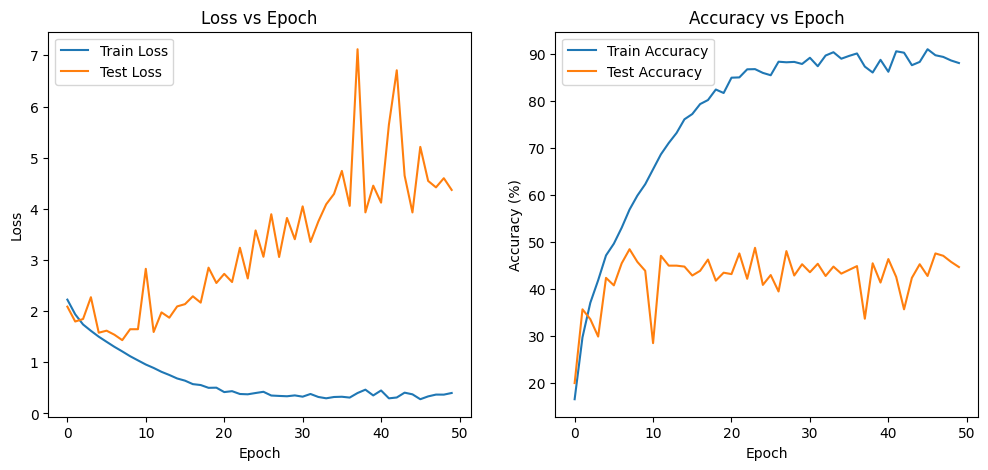

In [25]:
model_5 = TinyVGGModel(3, 20, 10, 3).to(device)
model_5

optimizer_5 = torch.optim.SGD(params=model_5.parameters(),
                            lr=0.1)
train_model(model_5,
            train_subset_loader,
            test_subset_loader,
            loss_fn, optimizer_5,
            accuracy, epochs=50,
            device=device)

# Dealing with overfitting (Data Augmentation)


In [12]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),   # Randomly flip images horizontally
    transforms.RandomRotation(15),       # Randomly rotate by up to 15 degrees
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),  # Random crop and resize
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Random color jitter
    transform  # Apply preprocessing (ToTensor and Normalize) after augmentation
])

# Create CIFAR10 dataset with the new combined transformations
train_aug_dataset = CIFAR10(root="data", train=True, download=True, transform=train_transform)

# DataLoader for training dataset
train_aug_dataloader = DataLoader(train_aug_dataset, batch_size=32, shuffle=True)

#creating subset for experimenting
train_aug_subset = Subset(train_aug_dataset, train_indices)
train_aug_subset_loader = DataLoader(train_aug_subset, batch_size=32, shuffle=True)


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 2.27869 | Train accuracy: 13.72%


Epochs:   2%|▏         | 1/50 [00:06<05:17,  6.49s/it]

Test loss: 2.36999 | Test accuracy: 15.70%

Epoch: 1
---------
Train loss: 2.09438 | Train accuracy: 24.22%


Epochs:   4%|▍         | 2/50 [00:12<04:54,  6.14s/it]

Test loss: 1.96672 | Test accuracy: 30.10%

Epoch: 2
---------
Train loss: 1.94863 | Train accuracy: 30.10%


Epochs:   6%|▌         | 3/50 [00:19<05:00,  6.39s/it]

Test loss: 1.91577 | Test accuracy: 34.80%

Epoch: 3
---------
Train loss: 1.85821 | Train accuracy: 33.44%


Epochs:   8%|▊         | 4/50 [00:25<04:55,  6.42s/it]

Test loss: 1.81967 | Test accuracy: 37.50%

Epoch: 4
---------
Train loss: 1.78374 | Train accuracy: 34.80%


Epochs:  10%|█         | 5/50 [00:32<04:51,  6.47s/it]

Test loss: 2.03662 | Test accuracy: 26.50%

Epoch: 5
---------
Train loss: 1.76144 | Train accuracy: 36.24%


Epochs:  12%|█▏        | 6/50 [00:38<04:38,  6.32s/it]

Test loss: 3.14118 | Test accuracy: 10.90%

Epoch: 6
---------
Train loss: 1.71003 | Train accuracy: 38.96%


Epochs:  14%|█▍        | 7/50 [00:44<04:36,  6.42s/it]

Test loss: 1.77191 | Test accuracy: 38.50%

Epoch: 7
---------
Train loss: 1.68109 | Train accuracy: 39.38%


Epochs:  16%|█▌        | 8/50 [00:50<04:22,  6.26s/it]

Test loss: 1.65119 | Test accuracy: 39.70%

Epoch: 8
---------
Train loss: 1.63892 | Train accuracy: 40.36%


Epochs:  18%|█▊        | 9/50 [00:57<04:22,  6.40s/it]

Test loss: 1.50715 | Test accuracy: 48.20%

Epoch: 9
---------
Train loss: 1.60773 | Train accuracy: 41.52%


Epochs:  20%|██        | 10/50 [01:03<04:11,  6.28s/it]

Test loss: 1.49652 | Test accuracy: 46.20%

Epoch: 10
---------
Train loss: 1.59103 | Train accuracy: 43.44%


Epochs:  22%|██▏       | 11/50 [01:10<04:14,  6.52s/it]

Test loss: 1.54294 | Test accuracy: 43.70%

Epoch: 11
---------
Train loss: 1.57365 | Train accuracy: 43.70%


Epochs:  24%|██▍       | 12/50 [01:16<04:05,  6.45s/it]

Test loss: 1.56305 | Test accuracy: 43.90%

Epoch: 12
---------
Train loss: 1.54298 | Train accuracy: 45.24%


Epochs:  26%|██▌       | 13/50 [01:23<04:05,  6.65s/it]

Test loss: 1.64640 | Test accuracy: 39.60%

Epoch: 13
---------
Train loss: 1.54108 | Train accuracy: 45.18%


Epochs:  28%|██▊       | 14/50 [01:30<03:56,  6.57s/it]

Test loss: 1.50061 | Test accuracy: 46.20%

Epoch: 14
---------
Train loss: 1.53492 | Train accuracy: 45.18%


Epochs:  30%|███       | 15/50 [01:36<03:47,  6.49s/it]

Test loss: 1.43442 | Test accuracy: 49.30%

Epoch: 15
---------
Train loss: 1.51667 | Train accuracy: 46.40%


Epochs:  32%|███▏      | 16/50 [01:42<03:40,  6.48s/it]

Test loss: 1.88656 | Test accuracy: 33.40%

Epoch: 16
---------
Train loss: 1.49871 | Train accuracy: 47.36%


Epochs:  34%|███▍      | 17/50 [01:49<03:29,  6.36s/it]

Test loss: 1.60094 | Test accuracy: 45.40%

Epoch: 17
---------
Train loss: 1.47869 | Train accuracy: 47.02%


Epochs:  36%|███▌      | 18/50 [01:55<03:25,  6.41s/it]

Test loss: 1.44112 | Test accuracy: 49.30%

Epoch: 18
---------
Train loss: 1.47835 | Train accuracy: 47.32%


Epochs:  38%|███▊      | 19/50 [02:01<03:12,  6.22s/it]

Test loss: 1.59583 | Test accuracy: 40.80%

Epoch: 19
---------
Train loss: 1.45457 | Train accuracy: 48.56%


Epochs:  40%|████      | 20/50 [02:07<03:07,  6.25s/it]

Test loss: 1.65059 | Test accuracy: 38.80%

Epoch: 20
---------
Train loss: 1.45154 | Train accuracy: 48.34%


Epochs:  42%|████▏     | 21/50 [02:13<02:57,  6.13s/it]

Test loss: 1.51917 | Test accuracy: 49.40%

Epoch: 21
---------
Train loss: 1.43986 | Train accuracy: 48.40%


Epochs:  44%|████▍     | 22/50 [02:20<02:55,  6.27s/it]

Test loss: 1.45282 | Test accuracy: 48.70%

Epoch: 22
---------
Train loss: 1.43069 | Train accuracy: 48.86%


Epochs:  46%|████▌     | 23/50 [02:26<02:47,  6.20s/it]

Test loss: 1.52382 | Test accuracy: 47.50%

Epoch: 23
---------
Train loss: 1.40502 | Train accuracy: 50.70%


Epochs:  48%|████▊     | 24/50 [02:32<02:45,  6.35s/it]

Test loss: 1.48328 | Test accuracy: 48.40%

Epoch: 24
---------
Train loss: 1.41543 | Train accuracy: 49.76%


Epochs:  50%|█████     | 25/50 [02:38<02:36,  6.25s/it]

Test loss: 1.51621 | Test accuracy: 45.00%

Epoch: 25
---------
Train loss: 1.40738 | Train accuracy: 50.50%


Epochs:  52%|█████▏    | 26/50 [02:45<02:33,  6.40s/it]

Test loss: 1.73238 | Test accuracy: 37.40%

Epoch: 26
---------
Train loss: 1.39985 | Train accuracy: 51.02%


Epochs:  54%|█████▍    | 27/50 [02:51<02:24,  6.28s/it]

Test loss: 1.44418 | Test accuracy: 50.80%

Epoch: 27
---------
Train loss: 1.41090 | Train accuracy: 49.88%


Epochs:  56%|█████▌    | 28/50 [02:58<02:20,  6.41s/it]

Test loss: 1.67771 | Test accuracy: 45.80%

Epoch: 28
---------
Train loss: 1.39856 | Train accuracy: 51.02%


Epochs:  58%|█████▊    | 29/50 [03:04<02:12,  6.29s/it]

Test loss: 1.34632 | Test accuracy: 53.10%

Epoch: 29
---------
Train loss: 1.40201 | Train accuracy: 51.14%


Epochs:  60%|██████    | 30/50 [03:11<02:08,  6.42s/it]

Test loss: 1.47260 | Test accuracy: 49.50%

Epoch: 30
---------
Train loss: 1.40199 | Train accuracy: 50.60%


Epochs:  62%|██████▏   | 31/50 [03:17<01:59,  6.30s/it]

Test loss: 1.37482 | Test accuracy: 53.00%

Epoch: 31
---------
Train loss: 1.38631 | Train accuracy: 50.60%


Epochs:  64%|██████▍   | 32/50 [03:23<01:56,  6.47s/it]

Test loss: 1.69330 | Test accuracy: 44.80%

Epoch: 32
---------
Train loss: 1.37383 | Train accuracy: 51.20%


Epochs:  66%|██████▌   | 33/50 [03:30<01:48,  6.38s/it]

Test loss: 1.44904 | Test accuracy: 47.10%

Epoch: 33
---------
Train loss: 1.36614 | Train accuracy: 50.74%


Epochs:  68%|██████▊   | 34/50 [03:36<01:43,  6.48s/it]

Test loss: 1.64810 | Test accuracy: 44.10%

Epoch: 34
---------
Train loss: 1.38111 | Train accuracy: 51.00%


Epochs:  70%|███████   | 35/50 [03:42<01:35,  6.34s/it]

Test loss: 1.35653 | Test accuracy: 54.00%

Epoch: 35
---------
Train loss: 1.34518 | Train accuracy: 51.96%


Epochs:  72%|███████▏  | 36/50 [03:49<01:29,  6.42s/it]

Test loss: 1.38281 | Test accuracy: 50.30%

Epoch: 36
---------
Train loss: 1.35219 | Train accuracy: 51.62%


Epochs:  74%|███████▍  | 37/50 [03:55<01:22,  6.34s/it]

Test loss: 1.50636 | Test accuracy: 49.50%

Epoch: 37
---------
Train loss: 1.35090 | Train accuracy: 52.78%


Epochs:  76%|███████▌  | 38/50 [04:02<01:16,  6.38s/it]

Test loss: 1.37623 | Test accuracy: 50.30%

Epoch: 38
---------
Train loss: 1.35795 | Train accuracy: 50.98%


Epochs:  78%|███████▊  | 39/50 [04:08<01:09,  6.33s/it]

Test loss: 1.47881 | Test accuracy: 51.40%

Epoch: 39
---------
Train loss: 1.36987 | Train accuracy: 51.34%


Epochs:  80%|████████  | 40/50 [04:14<01:03,  6.31s/it]

Test loss: 1.49041 | Test accuracy: 47.90%

Epoch: 40
---------
Train loss: 1.35695 | Train accuracy: 52.32%


Epochs:  82%|████████▏ | 41/50 [04:20<00:57,  6.34s/it]

Test loss: 1.40718 | Test accuracy: 50.10%

Epoch: 41
---------
Train loss: 1.34331 | Train accuracy: 52.02%


Epochs:  84%|████████▍ | 42/50 [04:27<00:50,  6.27s/it]

Test loss: 1.45394 | Test accuracy: 51.00%

Epoch: 42
---------
Train loss: 1.33885 | Train accuracy: 52.50%


Epochs:  86%|████████▌ | 43/50 [04:33<00:44,  6.40s/it]

Test loss: 1.64020 | Test accuracy: 45.80%

Epoch: 43
---------
Train loss: 1.33370 | Train accuracy: 52.44%


Epochs:  88%|████████▊ | 44/50 [04:39<00:37,  6.27s/it]

Test loss: 1.50084 | Test accuracy: 49.20%

Epoch: 44
---------
Train loss: 1.34460 | Train accuracy: 52.84%


Epochs:  90%|█████████ | 45/50 [04:46<00:31,  6.37s/it]

Test loss: 1.38267 | Test accuracy: 50.60%

Epoch: 45
---------
Train loss: 1.34112 | Train accuracy: 53.14%


Epochs:  92%|█████████▏| 46/50 [04:52<00:25,  6.25s/it]

Test loss: 1.59160 | Test accuracy: 46.60%

Epoch: 46
---------
Train loss: 1.33783 | Train accuracy: 53.12%


Epochs:  94%|█████████▍| 47/50 [04:58<00:19,  6.38s/it]

Test loss: 1.45791 | Test accuracy: 49.50%

Epoch: 47
---------
Train loss: 1.35293 | Train accuracy: 52.20%


Epochs:  96%|█████████▌| 48/50 [05:04<00:12,  6.23s/it]

Test loss: 1.38918 | Test accuracy: 51.50%

Epoch: 48
---------
Train loss: 1.33207 | Train accuracy: 52.82%


Epochs:  98%|█████████▊| 49/50 [05:11<00:06,  6.32s/it]

Test loss: 1.61678 | Test accuracy: 47.10%

Epoch: 49
---------
Train loss: 1.33164 | Train accuracy: 52.46%


Epochs: 100%|██████████| 50/50 [05:17<00:00,  6.35s/it]

Test loss: 1.37329 | Test accuracy: 52.80%

Training and testing took 317.324 seconds


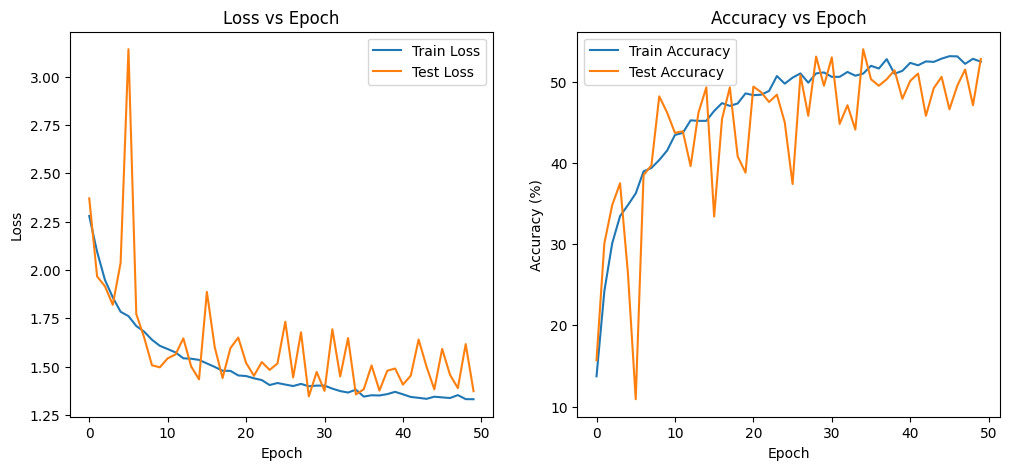

In [33]:
model_6 = TinyVGGModel(3, 10, 10, 2).to(device)
model_6

optimizer_6 = torch.optim.SGD(params=model_6.parameters(),
                            lr=0.1)
train_model(model_6,
            train_aug_subset_loader,
            test_subset_loader,
            loss_fn, optimizer_6,
            accuracy, epochs=50,
            device=device)

In [13]:

from timeit import default_timer as timer
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch

# a version of the train_model with a learning rate scheduler
def train_model_scheduler(model, train_loader, test_loader, loss_fn, optimizer, accuracy_fn, scheduler, epochs=3, device='cpu'):
    """
    Train and test a model while measuring the total time and collecting metrics.

    Args:
        model: PyTorch model
        train_loader: training DataLoader
        test_loader: testing DataLoader
        loss_fn: loss function
        optimizer: optimizer
        accuracy_fn: accuracy function (torchmetrics or manual)
        scheduler: learning rate scheduler
        epochs: number of epochs
        device: torch device (CPU/GPU)
    """
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    start_time = timer()

    for epoch in tqdm(range(epochs), desc="Epochs"):
        print(f"Epoch: {epoch}\n---------")

        # ===== Training step =====
        model.train()
        running_loss = 0.0
        running_acc = 0.0
        total = 0

        for X, y in train_loader:
            X, y = X.to(device),  y.long().to(device)
            optimizer.zero_grad()
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * X.size(0)

            # Accuracy
            acc = accuracy_fn(y_pred, y)
            running_acc += acc.item() * X.size(0)
            total += X.size(0)

        epoch_train_loss = running_loss / total
        epoch_train_acc = running_acc / total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        print(f"Train loss: {epoch_train_loss:.5f} | Train accuracy: {epoch_train_acc*100:.2f}%")

        # ===== Testing step =====
        model.eval()
        running_loss = 0.0
        running_acc = 0.0
        total = 0
        with torch.no_grad():
            for X, y in test_loader:
                X, y = X.to(device),  y.long().to(device)
                y_pred = model(X)
                loss = loss_fn(y_pred, y)

                running_loss += loss.item() * X.size(0)

                # Accuracy
                acc = accuracy_fn(y_pred, y)
                running_acc += acc.item() * X.size(0)
                total += X.size(0)

        epoch_test_loss = running_loss / total
        epoch_test_acc = running_acc / total
        test_losses.append(epoch_test_loss)
        test_accuracies.append(epoch_test_acc)

        print(f"Test loss: {epoch_test_loss:.5f} | Test accuracy: {epoch_test_acc*100:.2f}%\n")

        scheduler.step()
        print(f'Epoch {epoch+1}, Learning Rate: {scheduler.get_last_lr()[0]}')

    end_time = timer()
    elapsed_time = end_time - start_time
    print(f"Training and testing took {elapsed_time:.3f} seconds")


    # ===== Plot results =====
    epochs_range = range(epochs)

    plt.figure(figsize=(12,5))

    # Loss plot
    plt.subplot(1,2,1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs Epoch')
    plt.legend()

    # Accuracy plot
    plt.subplot(1,2,2)
    plt.plot(epochs_range, [acc*100 for acc in train_accuracies], label='Train Accuracy')
    plt.plot(epochs_range, [acc*100 for acc in test_accuracies], label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy vs Epoch')
    plt.legend()

    plt.show()

    # return train_losses, test_losses, train_accuracies, test_accuracies

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 2.30017 | Train accuracy: 11.40%


Epochs:   2%|▏         | 1/50 [00:06<05:19,  6.52s/it]

Test loss: 2.26308 | Test accuracy: 15.40%

Epoch 1, Learning Rate: 0.1
Epoch: 1
---------
Train loss: 2.14723 | Train accuracy: 20.78%


Epochs:   4%|▍         | 2/50 [00:12<04:55,  6.17s/it]

Test loss: 2.18752 | Test accuracy: 21.80%

Epoch 2, Learning Rate: 0.1
Epoch: 2
---------
Train loss: 2.06813 | Train accuracy: 24.58%


Epochs:   6%|▌         | 3/50 [00:18<04:56,  6.31s/it]

Test loss: 2.15072 | Test accuracy: 24.20%

Epoch 3, Learning Rate: 0.1
Epoch: 3
---------
Train loss: 2.02539 | Train accuracy: 26.04%


Epochs:   8%|▊         | 4/50 [00:24<04:45,  6.20s/it]

Test loss: 1.96779 | Test accuracy: 28.00%

Epoch 4, Learning Rate: 0.1
Epoch: 4
---------
Train loss: 1.97989 | Train accuracy: 27.56%


Epochs:  10%|█         | 5/50 [00:31<04:41,  6.27s/it]

Test loss: 2.00198 | Test accuracy: 26.10%

Epoch 5, Learning Rate: 0.1
Epoch: 5
---------
Train loss: 1.92154 | Train accuracy: 29.88%


Epochs:  12%|█▏        | 6/50 [00:37<04:32,  6.20s/it]

Test loss: 1.76585 | Test accuracy: 35.40%

Epoch 6, Learning Rate: 0.1
Epoch: 6
---------
Train loss: 1.83633 | Train accuracy: 34.22%


Epochs:  14%|█▍        | 7/50 [00:43<04:27,  6.23s/it]

Test loss: 1.73702 | Test accuracy: 35.50%

Epoch 7, Learning Rate: 0.1
Epoch: 7
---------
Train loss: 1.76479 | Train accuracy: 35.98%


Epochs:  16%|█▌        | 8/50 [00:49<04:19,  6.19s/it]

Test loss: 1.72750 | Test accuracy: 36.00%

Epoch 8, Learning Rate: 0.1
Epoch: 8
---------
Train loss: 1.70868 | Train accuracy: 39.12%


Epochs:  18%|█▊        | 9/50 [00:56<04:15,  6.22s/it]

Test loss: 1.76357 | Test accuracy: 37.30%

Epoch 9, Learning Rate: 0.1
Epoch: 9
---------
Train loss: 1.69448 | Train accuracy: 38.34%


Epochs:  20%|██        | 10/50 [01:02<04:11,  6.28s/it]

Test loss: 1.54643 | Test accuracy: 45.50%

Epoch 10, Learning Rate: 0.1
Epoch: 10
---------
Train loss: 1.65658 | Train accuracy: 41.24%


Epochs:  22%|██▏       | 11/50 [01:08<04:04,  6.28s/it]

Test loss: 1.64914 | Test accuracy: 41.60%

Epoch 11, Learning Rate: 0.1
Epoch: 11
---------
Train loss: 1.61735 | Train accuracy: 42.40%


Epochs:  24%|██▍       | 12/50 [01:15<04:00,  6.34s/it]

Test loss: 1.70645 | Test accuracy: 38.10%

Epoch 12, Learning Rate: 0.1
Epoch: 12
---------
Train loss: 1.59768 | Train accuracy: 42.74%


Epochs:  26%|██▌       | 13/50 [01:21<03:49,  6.20s/it]

Test loss: 1.48328 | Test accuracy: 48.30%

Epoch 13, Learning Rate: 0.1
Epoch: 13
---------
Train loss: 1.57703 | Train accuracy: 43.54%


Epochs:  28%|██▊       | 14/50 [01:27<03:45,  6.26s/it]

Test loss: 1.51319 | Test accuracy: 45.20%

Epoch 14, Learning Rate: 0.1
Epoch: 14
---------
Train loss: 1.56332 | Train accuracy: 44.04%


Epochs:  30%|███       | 15/50 [01:33<03:34,  6.14s/it]

Test loss: 1.44642 | Test accuracy: 48.30%

Epoch 15, Learning Rate: 0.010000000000000002
Epoch: 15
---------
Train loss: 1.46481 | Train accuracy: 47.86%


Epochs:  32%|███▏      | 16/50 [01:40<03:34,  6.30s/it]

Test loss: 1.37602 | Test accuracy: 52.80%

Epoch 16, Learning Rate: 0.010000000000000002
Epoch: 16
---------
Train loss: 1.43217 | Train accuracy: 48.88%


Epochs:  34%|███▍      | 17/50 [01:46<03:25,  6.22s/it]

Test loss: 1.36008 | Test accuracy: 53.10%

Epoch 17, Learning Rate: 0.010000000000000002
Epoch: 17
---------
Train loss: 1.42747 | Train accuracy: 49.26%


Epochs:  36%|███▌      | 18/50 [01:52<03:23,  6.37s/it]

Test loss: 1.36132 | Test accuracy: 52.70%

Epoch 18, Learning Rate: 0.010000000000000002
Epoch: 18
---------
Train loss: 1.42635 | Train accuracy: 48.96%


Epochs:  38%|███▊      | 19/50 [01:58<03:14,  6.26s/it]

Test loss: 1.34776 | Test accuracy: 53.10%

Epoch 19, Learning Rate: 0.010000000000000002
Epoch: 19
---------
Train loss: 1.41288 | Train accuracy: 49.80%


Epochs:  40%|████      | 20/50 [02:05<03:12,  6.41s/it]

Test loss: 1.37985 | Test accuracy: 51.70%

Epoch 20, Learning Rate: 0.010000000000000002
Epoch: 20
---------
Train loss: 1.40115 | Train accuracy: 50.24%


Epochs:  42%|████▏     | 21/50 [02:11<03:03,  6.34s/it]

Test loss: 1.34157 | Test accuracy: 54.00%

Epoch 21, Learning Rate: 0.010000000000000002
Epoch: 21
---------
Train loss: 1.42455 | Train accuracy: 49.82%


Epochs:  44%|████▍     | 22/50 [02:18<03:01,  6.47s/it]

Test loss: 1.34585 | Test accuracy: 53.10%

Epoch 22, Learning Rate: 0.010000000000000002
Epoch: 22
---------
Train loss: 1.39677 | Train accuracy: 50.80%


Epochs:  46%|████▌     | 23/50 [02:24<02:51,  6.34s/it]

Test loss: 1.34378 | Test accuracy: 54.20%

Epoch 23, Learning Rate: 0.010000000000000002
Epoch: 23
---------
Train loss: 1.40113 | Train accuracy: 50.42%


Epochs:  48%|████▊     | 24/50 [02:31<02:46,  6.42s/it]

Test loss: 1.33522 | Test accuracy: 54.80%

Epoch 24, Learning Rate: 0.010000000000000002
Epoch: 24
---------
Train loss: 1.40162 | Train accuracy: 50.48%


Epochs:  50%|█████     | 25/50 [02:37<02:36,  6.28s/it]

Test loss: 1.33925 | Test accuracy: 54.00%

Epoch 25, Learning Rate: 0.010000000000000002
Epoch: 25
---------
Train loss: 1.39704 | Train accuracy: 50.76%


Epochs:  52%|█████▏    | 26/50 [02:43<02:33,  6.38s/it]

Test loss: 1.33663 | Test accuracy: 54.00%

Epoch 26, Learning Rate: 0.010000000000000002
Epoch: 26
---------
Train loss: 1.38292 | Train accuracy: 51.24%


Epochs:  54%|█████▍    | 27/50 [02:49<02:25,  6.31s/it]

Test loss: 1.31976 | Test accuracy: 54.90%

Epoch 27, Learning Rate: 0.010000000000000002
Epoch: 27
---------
Train loss: 1.38855 | Train accuracy: 50.46%


Epochs:  56%|█████▌    | 28/50 [02:56<02:21,  6.42s/it]

Test loss: 1.33205 | Test accuracy: 53.40%

Epoch 28, Learning Rate: 0.010000000000000002
Epoch: 28
---------
Train loss: 1.38690 | Train accuracy: 50.68%


Epochs:  58%|█████▊    | 29/50 [03:02<02:12,  6.29s/it]

Test loss: 1.31981 | Test accuracy: 54.30%

Epoch 29, Learning Rate: 0.010000000000000002
Epoch: 29
---------
Train loss: 1.37585 | Train accuracy: 51.18%


Epochs:  60%|██████    | 30/50 [03:09<02:07,  6.39s/it]

Test loss: 1.34376 | Test accuracy: 54.00%

Epoch 30, Learning Rate: 0.0010000000000000002
Epoch: 30
---------
Train loss: 1.36318 | Train accuracy: 52.08%


Epochs:  62%|██████▏   | 31/50 [03:15<02:00,  6.32s/it]

Test loss: 1.31160 | Test accuracy: 55.00%

Epoch 31, Learning Rate: 0.0010000000000000002
Epoch: 31
---------
Train loss: 1.36324 | Train accuracy: 51.42%


Epochs:  64%|██████▍   | 32/50 [03:21<01:54,  6.39s/it]

Test loss: 1.30651 | Test accuracy: 55.60%

Epoch 32, Learning Rate: 0.0010000000000000002
Epoch: 32
---------
Train loss: 1.37013 | Train accuracy: 50.40%


Epochs:  66%|██████▌   | 33/50 [03:28<01:48,  6.37s/it]

Test loss: 1.30932 | Test accuracy: 55.20%

Epoch 33, Learning Rate: 0.0010000000000000002
Epoch: 33
---------
Train loss: 1.37302 | Train accuracy: 51.30%


Epochs:  68%|██████▊   | 34/50 [03:34<01:41,  6.36s/it]

Test loss: 1.30773 | Test accuracy: 55.80%

Epoch 34, Learning Rate: 0.0010000000000000002
Epoch: 34
---------
Train loss: 1.37658 | Train accuracy: 51.08%


Epochs:  70%|███████   | 35/50 [03:41<01:36,  6.44s/it]

Test loss: 1.30927 | Test accuracy: 55.40%

Epoch 35, Learning Rate: 0.0010000000000000002
Epoch: 35
---------
Train loss: 1.37387 | Train accuracy: 50.92%


Epochs:  72%|███████▏  | 36/50 [03:47<01:28,  6.35s/it]

Test loss: 1.30629 | Test accuracy: 55.70%

Epoch 36, Learning Rate: 0.0010000000000000002
Epoch: 36
---------
Train loss: 1.35087 | Train accuracy: 51.74%


Epochs:  74%|███████▍  | 37/50 [03:53<01:23,  6.44s/it]

Test loss: 1.31034 | Test accuracy: 55.20%

Epoch 37, Learning Rate: 0.0010000000000000002
Epoch: 37
---------
Train loss: 1.35398 | Train accuracy: 52.16%


Epochs:  76%|███████▌  | 38/50 [04:00<01:16,  6.34s/it]

Test loss: 1.30675 | Test accuracy: 55.70%

Epoch 38, Learning Rate: 0.0010000000000000002
Epoch: 38
---------
Train loss: 1.36887 | Train accuracy: 51.32%


Epochs:  78%|███████▊  | 39/50 [04:06<01:10,  6.45s/it]

Test loss: 1.30551 | Test accuracy: 55.50%

Epoch 39, Learning Rate: 0.0010000000000000002
Epoch: 39
---------
Train loss: 1.35410 | Train accuracy: 52.40%


Epochs:  80%|████████  | 40/50 [04:12<01:03,  6.31s/it]

Test loss: 1.30448 | Test accuracy: 55.40%

Epoch 40, Learning Rate: 0.0010000000000000002
Epoch: 40
---------
Train loss: 1.35653 | Train accuracy: 51.84%


Epochs:  82%|████████▏ | 41/50 [04:19<00:58,  6.44s/it]

Test loss: 1.30463 | Test accuracy: 55.70%

Epoch 41, Learning Rate: 0.0010000000000000002
Epoch: 41
---------
Train loss: 1.34849 | Train accuracy: 52.46%


Epochs:  84%|████████▍ | 42/50 [04:25<00:50,  6.29s/it]

Test loss: 1.30483 | Test accuracy: 55.50%

Epoch 42, Learning Rate: 0.0010000000000000002
Epoch: 42
---------
Train loss: 1.36787 | Train accuracy: 51.36%


Epochs:  86%|████████▌ | 43/50 [04:32<00:44,  6.39s/it]

Test loss: 1.30497 | Test accuracy: 55.80%

Epoch 43, Learning Rate: 0.0010000000000000002
Epoch: 43
---------
Train loss: 1.35144 | Train accuracy: 52.24%


Epochs:  88%|████████▊ | 44/50 [04:38<00:37,  6.27s/it]

Test loss: 1.30522 | Test accuracy: 55.30%

Epoch 44, Learning Rate: 0.0010000000000000002
Epoch: 44
---------
Train loss: 1.35596 | Train accuracy: 51.86%


Epochs:  90%|█████████ | 45/50 [04:44<00:31,  6.38s/it]

Test loss: 1.30484 | Test accuracy: 55.80%

Epoch 45, Learning Rate: 0.00010000000000000003
Epoch: 45
---------
Train loss: 1.35471 | Train accuracy: 51.36%


Epochs:  92%|█████████▏| 46/50 [04:50<00:25,  6.28s/it]

Test loss: 1.30482 | Test accuracy: 55.70%

Epoch 46, Learning Rate: 0.00010000000000000003
Epoch: 46
---------
Train loss: 1.35944 | Train accuracy: 51.64%


Epochs:  94%|█████████▍| 47/50 [04:57<00:19,  6.35s/it]

Test loss: 1.30448 | Test accuracy: 55.70%

Epoch 47, Learning Rate: 0.00010000000000000003
Epoch: 47
---------
Train loss: 1.35079 | Train accuracy: 51.80%


Epochs:  96%|█████████▌| 48/50 [05:03<00:12,  6.21s/it]

Test loss: 1.30418 | Test accuracy: 55.90%

Epoch 48, Learning Rate: 0.00010000000000000003
Epoch: 48
---------
Train loss: 1.34475 | Train accuracy: 52.54%


Epochs:  98%|█████████▊| 49/50 [05:09<00:06,  6.33s/it]

Test loss: 1.30422 | Test accuracy: 55.70%

Epoch 49, Learning Rate: 0.00010000000000000003
Epoch: 49
---------
Train loss: 1.35622 | Train accuracy: 51.86%


Epochs: 100%|██████████| 50/50 [05:15<00:00,  6.31s/it]

Test loss: 1.30428 | Test accuracy: 55.90%

Epoch 50, Learning Rate: 0.00010000000000000003
Training and testing took 315.560 seconds


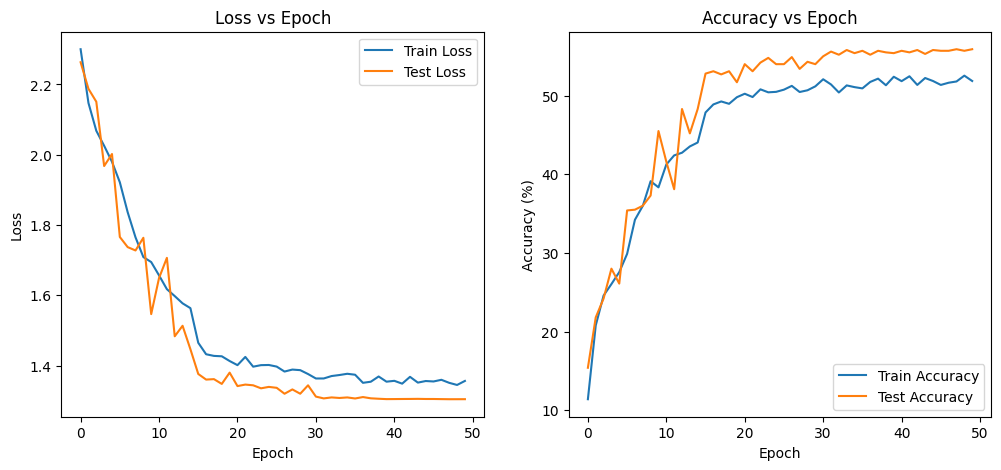

In [36]:
from torch.optim.lr_scheduler import StepLR

model_7 = TinyVGGModel(3, 10, 10, 2).to(device)
model_7

optimizer_7 = torch.optim.SGD(params=model_7.parameters(),
                            lr=0.1)

scheduler_7 = StepLR(optimizer_7, step_size=15, gamma=0.1)

train_model_scheduler(model_7,
            train_aug_subset_loader,
            test_subset_loader,
            loss_fn, optimizer_7,
            accuracy, scheduler_7,
            epochs=50, device=device)



Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 2.19676 | Train accuracy: 17.52%


Epochs:   2%|▏         | 1/50 [00:06<05:06,  6.25s/it]

Test loss: 2.09389 | Test accuracy: 23.10%

Epoch 1, Learning Rate: 0.1
Epoch: 1
---------
Train loss: 2.00425 | Train accuracy: 27.10%


Epochs:   4%|▍         | 2/50 [00:12<05:11,  6.50s/it]

Test loss: 1.92514 | Test accuracy: 28.90%

Epoch 2, Learning Rate: 0.1
Epoch: 2
---------
Train loss: 1.88298 | Train accuracy: 32.46%


Epochs:   6%|▌         | 3/50 [00:18<04:54,  6.27s/it]

Test loss: 2.40107 | Test accuracy: 20.50%

Epoch 3, Learning Rate: 0.1
Epoch: 3
---------
Train loss: 1.83374 | Train accuracy: 34.20%


Epochs:   8%|▊         | 4/50 [00:28<05:41,  7.43s/it]

Test loss: 1.86493 | Test accuracy: 30.40%

Epoch 4, Learning Rate: 0.1
Epoch: 4
---------
Train loss: 1.75929 | Train accuracy: 36.96%


Epochs:  10%|█         | 5/50 [00:36<05:43,  7.64s/it]

Test loss: 1.88315 | Test accuracy: 33.30%

Epoch 5, Learning Rate: 0.1
Epoch: 5
---------
Train loss: 1.69946 | Train accuracy: 39.38%


Epochs:  12%|█▏        | 6/50 [00:44<05:41,  7.76s/it]

Test loss: 1.66110 | Test accuracy: 41.50%

Epoch 6, Learning Rate: 0.1
Epoch: 6
---------
Train loss: 1.64423 | Train accuracy: 40.68%


Epochs:  14%|█▍        | 7/50 [00:51<05:27,  7.62s/it]

Test loss: 1.48149 | Test accuracy: 48.20%

Epoch 7, Learning Rate: 0.1
Epoch: 7
---------
Train loss: 1.60728 | Train accuracy: 42.40%


Epochs:  16%|█▌        | 8/50 [00:57<04:58,  7.11s/it]

Test loss: 1.69307 | Test accuracy: 40.70%

Epoch 8, Learning Rate: 0.1
Epoch: 8
---------
Train loss: 1.56662 | Train accuracy: 43.00%


Epochs:  18%|█▊        | 9/50 [01:04<04:45,  6.96s/it]

Test loss: 1.69578 | Test accuracy: 41.30%

Epoch 9, Learning Rate: 0.1
Epoch: 9
---------
Train loss: 1.52791 | Train accuracy: 45.20%


Epochs:  20%|██        | 10/50 [01:10<04:28,  6.71s/it]

Test loss: 1.41329 | Test accuracy: 49.70%

Epoch 10, Learning Rate: 0.1
Epoch: 10
---------
Train loss: 1.52190 | Train accuracy: 46.02%


Epochs:  22%|██▏       | 11/50 [01:16<04:20,  6.68s/it]

Test loss: 1.53067 | Test accuracy: 48.40%

Epoch 11, Learning Rate: 0.1
Epoch: 11
---------
Train loss: 1.49112 | Train accuracy: 46.52%


Epochs:  24%|██▍       | 12/50 [01:22<04:05,  6.45s/it]

Test loss: 1.36164 | Test accuracy: 52.50%

Epoch 12, Learning Rate: 0.1
Epoch: 12
---------
Train loss: 1.45805 | Train accuracy: 48.48%


Epochs:  26%|██▌       | 13/50 [01:29<03:59,  6.48s/it]

Test loss: 2.08507 | Test accuracy: 30.20%

Epoch 13, Learning Rate: 0.1
Epoch: 13
---------
Train loss: 1.45890 | Train accuracy: 49.18%


Epochs:  28%|██▊       | 14/50 [01:35<03:47,  6.32s/it]

Test loss: 1.40832 | Test accuracy: 51.70%

Epoch 14, Learning Rate: 0.1
Epoch: 14
---------
Train loss: 1.41775 | Train accuracy: 49.42%


Epochs:  30%|███       | 15/50 [01:41<03:44,  6.41s/it]

Test loss: 1.74956 | Test accuracy: 44.10%

Epoch 15, Learning Rate: 0.010000000000000002
Epoch: 15
---------
Train loss: 1.32467 | Train accuracy: 53.40%


Epochs:  32%|███▏      | 16/50 [01:47<03:32,  6.26s/it]

Test loss: 1.23778 | Test accuracy: 55.60%

Epoch 16, Learning Rate: 0.010000000000000002
Epoch: 16
---------
Train loss: 1.28615 | Train accuracy: 53.58%


Epochs:  34%|███▍      | 17/50 [01:54<03:29,  6.35s/it]

Test loss: 1.23486 | Test accuracy: 56.10%

Epoch 17, Learning Rate: 0.010000000000000002
Epoch: 17
---------
Train loss: 1.27287 | Train accuracy: 54.22%


Epochs:  36%|███▌      | 18/50 [02:00<03:19,  6.24s/it]

Test loss: 1.21486 | Test accuracy: 56.70%

Epoch 18, Learning Rate: 0.010000000000000002
Epoch: 18
---------
Train loss: 1.25941 | Train accuracy: 55.78%


Epochs:  38%|███▊      | 19/50 [02:07<03:17,  6.36s/it]

Test loss: 1.21579 | Test accuracy: 56.70%

Epoch 19, Learning Rate: 0.010000000000000002
Epoch: 19
---------
Train loss: 1.26261 | Train accuracy: 55.26%


Epochs:  40%|████      | 20/50 [02:13<03:09,  6.33s/it]

Test loss: 1.21365 | Test accuracy: 57.00%

Epoch 20, Learning Rate: 0.010000000000000002
Epoch: 20
---------
Train loss: 1.27260 | Train accuracy: 55.74%


Epochs:  42%|████▏     | 21/50 [02:20<03:09,  6.55s/it]

Test loss: 1.20325 | Test accuracy: 57.60%

Epoch 21, Learning Rate: 0.010000000000000002
Epoch: 21
---------
Train loss: 1.25064 | Train accuracy: 55.96%


Epochs:  44%|████▍     | 22/50 [02:26<03:01,  6.47s/it]

Test loss: 1.19260 | Test accuracy: 57.90%

Epoch 22, Learning Rate: 0.010000000000000002
Epoch: 22
---------
Train loss: 1.24126 | Train accuracy: 56.38%


Epochs:  46%|████▌     | 23/50 [02:32<02:51,  6.36s/it]

Test loss: 1.22022 | Test accuracy: 57.30%

Epoch 23, Learning Rate: 0.010000000000000002
Epoch: 23
---------
Train loss: 1.23428 | Train accuracy: 56.86%


Epochs:  48%|████▊     | 24/50 [02:39<02:46,  6.40s/it]

Test loss: 1.17711 | Test accuracy: 59.10%

Epoch 24, Learning Rate: 0.010000000000000002
Epoch: 24
---------
Train loss: 1.22210 | Train accuracy: 56.64%


Epochs:  50%|█████     | 25/50 [02:45<02:40,  6.44s/it]

Test loss: 1.20625 | Test accuracy: 57.40%

Epoch 25, Learning Rate: 0.010000000000000002
Epoch: 25
---------
Train loss: 1.22425 | Train accuracy: 56.82%


Epochs:  52%|█████▏    | 26/50 [02:52<02:35,  6.47s/it]

Test loss: 1.18693 | Test accuracy: 57.40%

Epoch 26, Learning Rate: 0.010000000000000002
Epoch: 26
---------
Train loss: 1.21987 | Train accuracy: 58.10%


Epochs:  54%|█████▍    | 27/50 [02:58<02:25,  6.32s/it]

Test loss: 1.17698 | Test accuracy: 58.30%

Epoch 27, Learning Rate: 0.010000000000000002
Epoch: 27
---------
Train loss: 1.20507 | Train accuracy: 58.26%


Epochs:  56%|█████▌    | 28/50 [03:04<02:20,  6.39s/it]

Test loss: 1.18480 | Test accuracy: 58.10%

Epoch 28, Learning Rate: 0.010000000000000002
Epoch: 28
---------
Train loss: 1.20528 | Train accuracy: 58.24%


Epochs:  58%|█████▊    | 29/50 [03:10<02:11,  6.27s/it]

Test loss: 1.18582 | Test accuracy: 58.90%

Epoch 29, Learning Rate: 0.010000000000000002
Epoch: 29
---------
Train loss: 1.21749 | Train accuracy: 56.40%


Epochs:  60%|██████    | 30/50 [03:17<02:07,  6.38s/it]

Test loss: 1.17674 | Test accuracy: 58.90%

Epoch 30, Learning Rate: 0.0010000000000000002
Epoch: 30
---------
Train loss: 1.19726 | Train accuracy: 57.72%


Epochs:  62%|██████▏   | 31/50 [03:23<01:58,  6.23s/it]

Test loss: 1.16425 | Test accuracy: 58.90%

Epoch 31, Learning Rate: 0.0010000000000000002
Epoch: 31
---------
Train loss: 1.19238 | Train accuracy: 58.10%


Epochs:  64%|██████▍   | 32/50 [03:29<01:54,  6.34s/it]

Test loss: 1.16232 | Test accuracy: 58.40%

Epoch 32, Learning Rate: 0.0010000000000000002
Epoch: 32
---------
Train loss: 1.18708 | Train accuracy: 58.66%


Epochs:  66%|██████▌   | 33/50 [03:35<01:45,  6.23s/it]

Test loss: 1.15812 | Test accuracy: 59.00%

Epoch 33, Learning Rate: 0.0010000000000000002
Epoch: 33
---------
Train loss: 1.16628 | Train accuracy: 59.24%


Epochs:  68%|██████▊   | 34/50 [03:42<01:41,  6.34s/it]

Test loss: 1.16063 | Test accuracy: 59.20%

Epoch 34, Learning Rate: 0.0010000000000000002
Epoch: 34
---------
Train loss: 1.18184 | Train accuracy: 58.74%


Epochs:  70%|███████   | 35/50 [03:48<01:33,  6.23s/it]

Test loss: 1.15376 | Test accuracy: 59.40%

Epoch 35, Learning Rate: 0.0010000000000000002
Epoch: 35
---------
Train loss: 1.18087 | Train accuracy: 57.54%


Epochs:  72%|███████▏  | 36/50 [03:55<01:28,  6.34s/it]

Test loss: 1.15684 | Test accuracy: 59.00%

Epoch 36, Learning Rate: 0.0010000000000000002
Epoch: 36
---------
Train loss: 1.17878 | Train accuracy: 58.92%


Epochs:  74%|███████▍  | 37/50 [04:00<01:20,  6.22s/it]

Test loss: 1.16084 | Test accuracy: 58.70%

Epoch 37, Learning Rate: 0.0010000000000000002
Epoch: 37
---------
Train loss: 1.17774 | Train accuracy: 58.50%


Epochs:  76%|███████▌  | 38/50 [04:07<01:16,  6.35s/it]

Test loss: 1.15530 | Test accuracy: 59.20%

Epoch 38, Learning Rate: 0.0010000000000000002
Epoch: 38
---------
Train loss: 1.17546 | Train accuracy: 58.56%


Epochs:  78%|███████▊  | 39/50 [04:13<01:08,  6.22s/it]

Test loss: 1.16036 | Test accuracy: 59.20%

Epoch 39, Learning Rate: 0.0010000000000000002
Epoch: 39
---------
Train loss: 1.18166 | Train accuracy: 58.56%


Epochs:  80%|████████  | 40/50 [04:20<01:03,  6.34s/it]

Test loss: 1.15552 | Test accuracy: 59.20%

Epoch 40, Learning Rate: 0.0010000000000000002
Epoch: 40
---------
Train loss: 1.16987 | Train accuracy: 58.78%


Epochs:  82%|████████▏ | 41/50 [04:26<00:56,  6.25s/it]

Test loss: 1.15440 | Test accuracy: 59.50%

Epoch 41, Learning Rate: 0.0010000000000000002
Epoch: 41
---------
Train loss: 1.17229 | Train accuracy: 58.26%


Epochs:  84%|████████▍ | 42/50 [04:32<00:50,  6.34s/it]

Test loss: 1.15632 | Test accuracy: 58.70%

Epoch 42, Learning Rate: 0.0010000000000000002
Epoch: 42
---------
Train loss: 1.17708 | Train accuracy: 59.10%


Epochs:  86%|████████▌ | 43/50 [04:39<00:44,  6.37s/it]

Test loss: 1.15193 | Test accuracy: 58.90%

Epoch 43, Learning Rate: 0.0010000000000000002
Epoch: 43
---------
Train loss: 1.17329 | Train accuracy: 58.36%


Epochs:  88%|████████▊ | 44/50 [04:45<00:38,  6.46s/it]

Test loss: 1.15455 | Test accuracy: 59.00%

Epoch 44, Learning Rate: 0.0010000000000000002
Epoch: 44
---------
Train loss: 1.15939 | Train accuracy: 58.90%


Epochs:  90%|█████████ | 45/50 [04:52<00:32,  6.47s/it]

Test loss: 1.15313 | Test accuracy: 59.00%

Epoch 45, Learning Rate: 0.00010000000000000003
Epoch: 45
---------
Train loss: 1.17039 | Train accuracy: 58.66%


Epochs:  92%|█████████▏| 46/50 [04:58<00:25,  6.40s/it]

Test loss: 1.15304 | Test accuracy: 58.90%

Epoch 46, Learning Rate: 0.00010000000000000003
Epoch: 46
---------
Train loss: 1.15666 | Train accuracy: 58.96%


Epochs:  94%|█████████▍| 47/50 [05:05<00:19,  6.48s/it]

Test loss: 1.15277 | Test accuracy: 59.00%

Epoch 47, Learning Rate: 0.00010000000000000003
Epoch: 47
---------
Train loss: 1.18959 | Train accuracy: 58.04%


Epochs:  96%|█████████▌| 48/50 [05:11<00:12,  6.39s/it]

Test loss: 1.15252 | Test accuracy: 59.20%

Epoch 48, Learning Rate: 0.00010000000000000003
Epoch: 48
---------
Train loss: 1.17614 | Train accuracy: 58.78%


Epochs:  98%|█████████▊| 49/50 [05:18<00:06,  6.50s/it]

Test loss: 1.15301 | Test accuracy: 59.00%

Epoch 49, Learning Rate: 0.00010000000000000003
Epoch: 49
---------
Train loss: 1.16938 | Train accuracy: 59.08%


Epochs: 100%|██████████| 50/50 [05:24<00:00,  6.50s/it]

Test loss: 1.15328 | Test accuracy: 59.00%

Epoch 50, Learning Rate: 0.00010000000000000003
Training and testing took 324.776 seconds


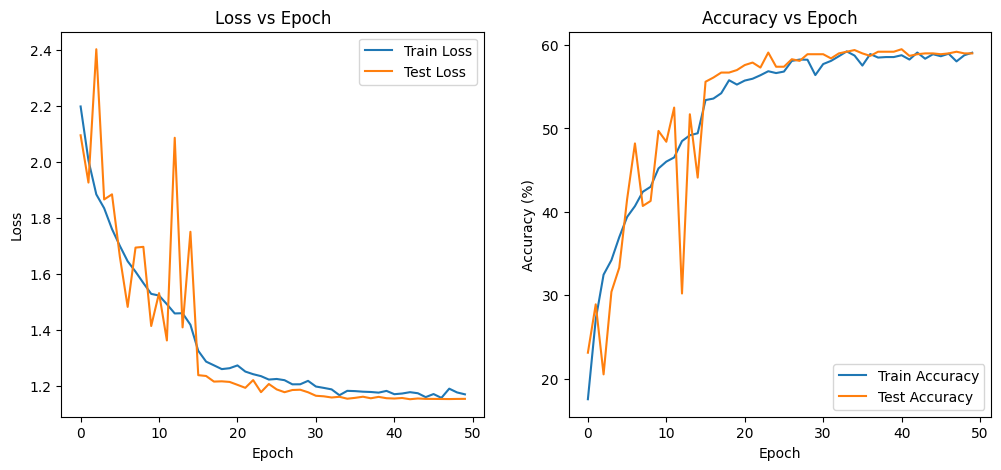

In [37]:
from torch.optim.lr_scheduler import StepLR

model_8 = TinyVGGModel(3, 20, 10, 2).to(device)
model_8

optimizer_8 = torch.optim.SGD(params=model_8.parameters(),
                            lr=0.1)
scheduler_8 = StepLR(optimizer_8, step_size=15, gamma=0.1)

train_model_scheduler(model_8,
            train_aug_subset_loader,
            test_subset_loader,
            loss_fn, optimizer_8,
            accuracy, scheduler_8,
            epochs=50, device=device)


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 2.18197 | Train accuracy: 19.32%


Epochs:   2%|▏         | 1/50 [00:07<05:50,  7.16s/it]

Test loss: 2.16744 | Test accuracy: 24.10%

Epoch 1, Learning Rate: 0.1
Epoch: 1
---------
Train loss: 2.01449 | Train accuracy: 27.12%


Epochs:   4%|▍         | 2/50 [00:14<05:37,  7.03s/it]

Test loss: 1.96749 | Test accuracy: 33.80%

Epoch 2, Learning Rate: 0.1
Epoch: 2
---------
Train loss: 1.87640 | Train accuracy: 32.86%


Epochs:   6%|▌         | 3/50 [00:21<05:39,  7.22s/it]

Test loss: 2.04061 | Test accuracy: 32.40%

Epoch 3, Learning Rate: 0.1
Epoch: 3
---------
Train loss: 1.75999 | Train accuracy: 36.54%


Epochs:   8%|▊         | 4/50 [00:28<05:24,  7.05s/it]

Test loss: 1.65101 | Test accuracy: 41.90%

Epoch 4, Learning Rate: 0.1
Epoch: 4
---------
Train loss: 1.67264 | Train accuracy: 39.70%


Epochs:  10%|█         | 5/50 [00:35<05:21,  7.14s/it]

Test loss: 1.73706 | Test accuracy: 41.50%

Epoch 5, Learning Rate: 0.1
Epoch: 5
---------
Train loss: 1.64218 | Train accuracy: 41.20%


Epochs:  12%|█▏        | 6/50 [00:42<05:09,  7.03s/it]

Test loss: 1.54014 | Test accuracy: 46.90%

Epoch 6, Learning Rate: 0.1
Epoch: 6
---------
Train loss: 1.57008 | Train accuracy: 44.56%


Epochs:  14%|█▍        | 7/50 [00:49<05:04,  7.08s/it]

Test loss: 1.55233 | Test accuracy: 44.30%

Epoch 7, Learning Rate: 0.1
Epoch: 7
---------
Train loss: 1.52674 | Train accuracy: 45.16%


Epochs:  16%|█▌        | 8/50 [00:56<05:00,  7.14s/it]

Test loss: 1.64230 | Test accuracy: 44.10%

Epoch 8, Learning Rate: 0.1
Epoch: 8
---------
Train loss: 1.48742 | Train accuracy: 46.56%


Epochs:  18%|█▊        | 9/50 [01:03<04:49,  7.05s/it]

Test loss: 1.49512 | Test accuracy: 47.60%

Epoch 9, Learning Rate: 0.1
Epoch: 9
---------
Train loss: 1.44714 | Train accuracy: 49.06%


Epochs:  20%|██        | 10/50 [01:11<04:46,  7.16s/it]

Test loss: 1.39549 | Test accuracy: 49.80%

Epoch 10, Learning Rate: 0.1
Epoch: 10
---------
Train loss: 1.41181 | Train accuracy: 49.68%


Epochs:  22%|██▏       | 11/50 [01:17<04:33,  7.02s/it]

Test loss: 1.41207 | Test accuracy: 51.50%

Epoch 11, Learning Rate: 0.1
Epoch: 11
---------
Train loss: 1.38896 | Train accuracy: 50.74%


Epochs:  24%|██▍       | 12/50 [01:25<04:30,  7.12s/it]

Test loss: 1.42391 | Test accuracy: 51.10%

Epoch 12, Learning Rate: 0.1
Epoch: 12
---------
Train loss: 1.36446 | Train accuracy: 51.82%


Epochs:  26%|██▌       | 13/50 [01:32<04:25,  7.18s/it]

Test loss: 1.70266 | Test accuracy: 42.10%

Epoch 13, Learning Rate: 0.1
Epoch: 13
---------
Train loss: 1.35452 | Train accuracy: 52.64%


Epochs:  28%|██▊       | 14/50 [01:40<04:22,  7.29s/it]

Test loss: 1.42690 | Test accuracy: 50.60%

Epoch 14, Learning Rate: 0.1
Epoch: 14
---------
Train loss: 1.33041 | Train accuracy: 53.16%


Epochs:  30%|███       | 15/50 [01:47<04:15,  7.31s/it]

Test loss: 1.43140 | Test accuracy: 49.50%

Epoch 15, Learning Rate: 0.010000000000000002
Epoch: 15
---------
Train loss: 1.21761 | Train accuracy: 57.22%


Epochs:  32%|███▏      | 16/50 [01:54<04:01,  7.10s/it]

Test loss: 1.17069 | Test accuracy: 58.40%

Epoch 16, Learning Rate: 0.010000000000000002
Epoch: 16
---------
Train loss: 1.17740 | Train accuracy: 58.38%


Epochs:  34%|███▍      | 17/50 [02:01<03:55,  7.15s/it]

Test loss: 1.14977 | Test accuracy: 59.10%

Epoch 17, Learning Rate: 0.010000000000000002
Epoch: 17
---------
Train loss: 1.14042 | Train accuracy: 60.04%


Epochs:  36%|███▌      | 18/50 [02:08<03:45,  7.04s/it]

Test loss: 1.16139 | Test accuracy: 60.10%

Epoch 18, Learning Rate: 0.010000000000000002
Epoch: 18
---------
Train loss: 1.15235 | Train accuracy: 59.52%


Epochs:  38%|███▊      | 19/50 [02:15<03:39,  7.10s/it]

Test loss: 1.13208 | Test accuracy: 59.90%

Epoch 19, Learning Rate: 0.010000000000000002
Epoch: 19
---------
Train loss: 1.12923 | Train accuracy: 60.10%


Epochs:  40%|████      | 20/50 [02:22<03:34,  7.15s/it]

Test loss: 1.12826 | Test accuracy: 60.90%

Epoch 20, Learning Rate: 0.010000000000000002
Epoch: 20
---------
Train loss: 1.14042 | Train accuracy: 59.64%


Epochs:  42%|████▏     | 21/50 [02:29<03:23,  7.02s/it]

Test loss: 1.13967 | Test accuracy: 59.20%

Epoch 21, Learning Rate: 0.010000000000000002
Epoch: 21
---------
Train loss: 1.12628 | Train accuracy: 60.42%


Epochs:  44%|████▍     | 22/50 [02:36<03:18,  7.10s/it]

Test loss: 1.12842 | Test accuracy: 61.30%

Epoch 22, Learning Rate: 0.010000000000000002
Epoch: 22
---------
Train loss: 1.12664 | Train accuracy: 61.02%


Epochs:  46%|████▌     | 23/50 [02:43<03:08,  6.98s/it]

Test loss: 1.11634 | Test accuracy: 60.90%

Epoch 23, Learning Rate: 0.010000000000000002
Epoch: 23
---------
Train loss: 1.10769 | Train accuracy: 60.38%


Epochs:  48%|████▊     | 24/50 [02:50<03:03,  7.07s/it]

Test loss: 1.11525 | Test accuracy: 60.90%

Epoch 24, Learning Rate: 0.010000000000000002
Epoch: 24
---------
Train loss: 1.11764 | Train accuracy: 61.44%


Epochs:  50%|█████     | 25/50 [02:57<02:55,  7.04s/it]

Test loss: 1.16051 | Test accuracy: 59.70%

Epoch 25, Learning Rate: 0.010000000000000002
Epoch: 25
---------
Train loss: 1.10562 | Train accuracy: 61.66%


Epochs:  52%|█████▏    | 26/50 [03:04<02:47,  7.00s/it]

Test loss: 1.10093 | Test accuracy: 61.10%

Epoch 26, Learning Rate: 0.010000000000000002
Epoch: 26
---------
Train loss: 1.09698 | Train accuracy: 62.04%


Epochs:  54%|█████▍    | 27/50 [03:11<02:42,  7.06s/it]

Test loss: 1.11109 | Test accuracy: 62.60%

Epoch 27, Learning Rate: 0.010000000000000002
Epoch: 27
---------
Train loss: 1.08953 | Train accuracy: 62.02%


Epochs:  56%|█████▌    | 28/50 [03:18<02:33,  6.95s/it]

Test loss: 1.12345 | Test accuracy: 61.90%

Epoch 28, Learning Rate: 0.010000000000000002
Epoch: 28
---------
Train loss: 1.07552 | Train accuracy: 62.72%


Epochs:  58%|█████▊    | 29/50 [03:25<02:27,  7.03s/it]

Test loss: 1.13344 | Test accuracy: 61.00%

Epoch 29, Learning Rate: 0.010000000000000002
Epoch: 29
---------
Train loss: 1.07839 | Train accuracy: 61.82%


Epochs:  60%|██████    | 30/50 [03:32<02:19,  6.95s/it]

Test loss: 1.13924 | Test accuracy: 60.30%

Epoch 30, Learning Rate: 0.0010000000000000002
Epoch: 30
---------
Train loss: 1.06012 | Train accuracy: 62.62%


Epochs:  62%|██████▏   | 31/50 [03:39<02:13,  7.05s/it]

Test loss: 1.10203 | Test accuracy: 61.90%

Epoch 31, Learning Rate: 0.0010000000000000002
Epoch: 31
---------
Train loss: 1.06269 | Train accuracy: 63.04%


Epochs:  64%|██████▍   | 32/50 [03:46<02:08,  7.13s/it]

Test loss: 1.09808 | Test accuracy: 61.80%

Epoch 32, Learning Rate: 0.0010000000000000002
Epoch: 32
---------
Train loss: 1.05566 | Train accuracy: 63.90%


Epochs:  66%|██████▌   | 33/50 [03:53<02:00,  7.08s/it]

Test loss: 1.09598 | Test accuracy: 62.10%

Epoch 33, Learning Rate: 0.0010000000000000002
Epoch: 33
---------
Train loss: 1.04690 | Train accuracy: 63.52%


Epochs:  68%|██████▊   | 34/50 [04:01<01:54,  7.17s/it]

Test loss: 1.09736 | Test accuracy: 62.40%

Epoch 34, Learning Rate: 0.0010000000000000002
Epoch: 34
---------
Train loss: 1.05172 | Train accuracy: 63.42%


Epochs:  70%|███████   | 35/50 [04:08<01:45,  7.04s/it]

Test loss: 1.09497 | Test accuracy: 61.90%

Epoch 35, Learning Rate: 0.0010000000000000002
Epoch: 35
---------
Train loss: 1.06283 | Train accuracy: 62.54%


Epochs:  72%|███████▏  | 36/50 [04:15<01:39,  7.14s/it]

Test loss: 1.09346 | Test accuracy: 62.50%

Epoch 36, Learning Rate: 0.0010000000000000002
Epoch: 36
---------
Train loss: 1.04897 | Train accuracy: 63.28%


Epochs:  74%|███████▍  | 37/50 [04:22<01:31,  7.08s/it]

Test loss: 1.09347 | Test accuracy: 62.10%

Epoch 37, Learning Rate: 0.0010000000000000002
Epoch: 37
---------
Train loss: 1.05780 | Train accuracy: 62.90%


Epochs:  76%|███████▌  | 38/50 [04:29<01:25,  7.11s/it]

Test loss: 1.09382 | Test accuracy: 62.40%

Epoch 38, Learning Rate: 0.0010000000000000002
Epoch: 38
---------
Train loss: 1.04275 | Train accuracy: 63.66%


Epochs:  78%|███████▊  | 39/50 [04:36<01:19,  7.22s/it]

Test loss: 1.09209 | Test accuracy: 62.20%

Epoch 39, Learning Rate: 0.0010000000000000002
Epoch: 39
---------
Train loss: 1.03797 | Train accuracy: 63.82%


Epochs:  80%|████████  | 40/50 [04:43<01:10,  7.05s/it]

Test loss: 1.09597 | Test accuracy: 62.20%

Epoch 40, Learning Rate: 0.0010000000000000002
Epoch: 40
---------
Train loss: 1.05845 | Train accuracy: 63.42%


Epochs:  82%|████████▏ | 41/50 [04:51<01:04,  7.15s/it]

Test loss: 1.09430 | Test accuracy: 62.30%

Epoch 41, Learning Rate: 0.0010000000000000002
Epoch: 41
---------
Train loss: 1.04777 | Train accuracy: 63.60%


Epochs:  84%|████████▍ | 42/50 [04:57<00:56,  7.03s/it]

Test loss: 1.09323 | Test accuracy: 62.40%

Epoch 42, Learning Rate: 0.0010000000000000002
Epoch: 42
---------
Train loss: 1.03830 | Train accuracy: 64.18%


Epochs:  86%|████████▌ | 43/50 [05:05<00:51,  7.31s/it]

Test loss: 1.09435 | Test accuracy: 62.80%

Epoch 43, Learning Rate: 0.0010000000000000002
Epoch: 43
---------
Train loss: 1.04870 | Train accuracy: 63.24%


Epochs:  88%|████████▊ | 44/50 [05:13<00:43,  7.33s/it]

Test loss: 1.10149 | Test accuracy: 62.20%

Epoch 44, Learning Rate: 0.0010000000000000002
Epoch: 44
---------
Train loss: 1.07393 | Train accuracy: 62.80%


Epochs:  90%|█████████ | 45/50 [05:19<00:35,  7.18s/it]

Test loss: 1.09652 | Test accuracy: 62.60%

Epoch 45, Learning Rate: 0.00010000000000000003
Epoch: 45
---------
Train loss: 1.04647 | Train accuracy: 64.04%


Epochs:  92%|█████████▏| 46/50 [05:27<00:28,  7.24s/it]

Test loss: 1.09595 | Test accuracy: 62.80%

Epoch 46, Learning Rate: 0.00010000000000000003
Epoch: 46
---------
Train loss: 1.05214 | Train accuracy: 63.30%


Epochs:  94%|█████████▍| 47/50 [05:34<00:21,  7.10s/it]

Test loss: 1.09583 | Test accuracy: 62.70%

Epoch 47, Learning Rate: 0.00010000000000000003
Epoch: 47
---------
Train loss: 1.03863 | Train accuracy: 63.82%


Epochs:  96%|█████████▌| 48/50 [05:41<00:14,  7.15s/it]

Test loss: 1.09561 | Test accuracy: 62.60%

Epoch 48, Learning Rate: 0.00010000000000000003
Epoch: 48
---------
Train loss: 1.04366 | Train accuracy: 63.38%


Epochs:  98%|█████████▊| 49/50 [05:48<00:07,  7.12s/it]

Test loss: 1.09526 | Test accuracy: 62.50%

Epoch 49, Learning Rate: 0.00010000000000000003
Epoch: 49
---------
Train loss: 1.03568 | Train accuracy: 63.08%


Epochs: 100%|██████████| 50/50 [05:55<00:00,  7.10s/it]

Test loss: 1.09500 | Test accuracy: 62.50%

Epoch 50, Learning Rate: 0.00010000000000000003
Training and testing took 355.167 seconds


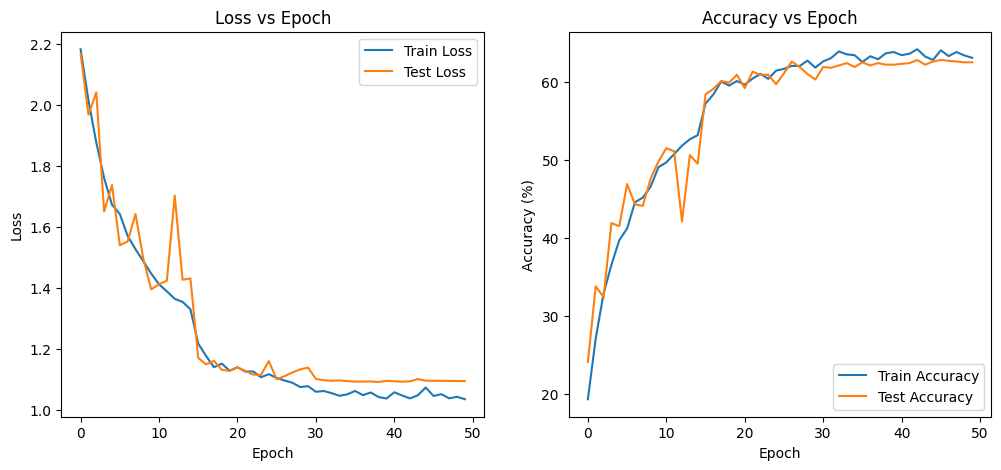

In [41]:
from torch.optim.lr_scheduler import StepLR

model_9 = TinyVGGModel(3, 35, 10, 2).to(device)
model_9

optimizer_9 = torch.optim.SGD(params=model_9.parameters(),
                            lr=0.1)

scheduler_9 = StepLR(optimizer_9, step_size=15, gamma=0.1)

train_model_scheduler(model_9,
            train_aug_subset_loader,
            test_subset_loader,
            loss_fn, optimizer_9,
            accuracy, scheduler_9,
            epochs=50, device=device)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 2.24967 | Train accuracy: 17.00%


Epochs:   2%|▏         | 1/50 [00:07<06:16,  7.68s/it]

Test loss: 2.17546 | Test accuracy: 21.40%

Epoch 1, Learning Rate: 0.1
Epoch: 1
---------
Train loss: 2.05413 | Train accuracy: 25.40%


Epochs:   4%|▍         | 2/50 [00:14<05:54,  7.39s/it]

Test loss: 2.87870 | Test accuracy: 15.00%

Epoch 2, Learning Rate: 0.1
Epoch: 2
---------
Train loss: 1.92385 | Train accuracy: 31.60%


Epochs:   6%|▌         | 3/50 [00:22<05:55,  7.56s/it]

Test loss: 1.83982 | Test accuracy: 35.30%

Epoch 3, Learning Rate: 0.1
Epoch: 3
---------
Train loss: 1.80820 | Train accuracy: 35.52%


Epochs:   8%|▊         | 4/50 [00:30<05:46,  7.54s/it]

Test loss: 1.66841 | Test accuracy: 41.90%

Epoch 4, Learning Rate: 0.1
Epoch: 4
---------
Train loss: 1.73026 | Train accuracy: 38.28%


Epochs:  10%|█         | 5/50 [00:37<05:33,  7.41s/it]

Test loss: 1.59095 | Test accuracy: 43.20%

Epoch 5, Learning Rate: 0.1
Epoch: 5
---------
Train loss: 1.67501 | Train accuracy: 39.54%


Epochs:  12%|█▏        | 6/50 [00:44<05:29,  7.50s/it]

Test loss: 2.25086 | Test accuracy: 25.60%

Epoch 6, Learning Rate: 0.1
Epoch: 6
---------
Train loss: 1.62744 | Train accuracy: 42.36%


Epochs:  14%|█▍        | 7/50 [00:52<05:17,  7.38s/it]

Test loss: 2.11276 | Test accuracy: 31.60%

Epoch 7, Learning Rate: 0.1
Epoch: 7
---------
Train loss: 1.57962 | Train accuracy: 43.16%


Epochs:  16%|█▌        | 8/50 [01:00<05:23,  7.71s/it]

Test loss: 1.64064 | Test accuracy: 42.70%

Epoch 8, Learning Rate: 0.1
Epoch: 8
---------
Train loss: 1.52625 | Train accuracy: 45.78%


Epochs:  18%|█▊        | 9/50 [01:09<05:36,  8.21s/it]

Test loss: 1.48546 | Test accuracy: 47.60%

Epoch 9, Learning Rate: 0.1
Epoch: 9
---------
Train loss: 1.49110 | Train accuracy: 48.18%


Epochs:  20%|██        | 10/50 [01:17<05:15,  7.89s/it]

Test loss: 1.37822 | Test accuracy: 50.00%

Epoch 10, Learning Rate: 0.1
Epoch: 10
---------
Train loss: 1.45719 | Train accuracy: 47.52%


Epochs:  22%|██▏       | 11/50 [01:24<05:04,  7.81s/it]

Test loss: 1.40053 | Test accuracy: 50.20%

Epoch 11, Learning Rate: 0.1
Epoch: 11
---------
Train loss: 1.41966 | Train accuracy: 48.92%


Epochs:  24%|██▍       | 12/50 [01:32<04:55,  7.77s/it]

Test loss: 1.56230 | Test accuracy: 46.50%

Epoch 12, Learning Rate: 0.1
Epoch: 12
---------
Train loss: 1.40785 | Train accuracy: 49.90%


Epochs:  26%|██▌       | 13/50 [01:42<05:12,  8.44s/it]

Test loss: 1.34068 | Test accuracy: 52.50%

Epoch 13, Learning Rate: 0.1
Epoch: 13
---------
Train loss: 1.37809 | Train accuracy: 51.22%


Epochs:  28%|██▊       | 14/50 [01:50<05:05,  8.48s/it]

Test loss: 1.41148 | Test accuracy: 50.90%

Epoch 14, Learning Rate: 0.1
Epoch: 14
---------
Train loss: 1.34664 | Train accuracy: 52.42%


Epochs:  30%|███       | 15/50 [01:59<05:02,  8.64s/it]

Test loss: 1.45417 | Test accuracy: 50.80%

Epoch 15, Learning Rate: 0.010000000000000002
Epoch: 15
---------
Train loss: 1.23519 | Train accuracy: 56.68%


Epochs:  32%|███▏      | 16/50 [02:07<04:48,  8.47s/it]

Test loss: 1.16292 | Test accuracy: 59.70%

Epoch 16, Learning Rate: 0.010000000000000002
Epoch: 16
---------
Train loss: 1.19293 | Train accuracy: 58.70%


Epochs:  34%|███▍      | 17/50 [02:15<04:27,  8.10s/it]

Test loss: 1.14991 | Test accuracy: 58.50%

Epoch 17, Learning Rate: 0.010000000000000002
Epoch: 17
---------
Train loss: 1.16100 | Train accuracy: 58.66%


Epochs:  36%|███▌      | 18/50 [02:22<04:15,  7.97s/it]

Test loss: 1.14006 | Test accuracy: 60.50%

Epoch 18, Learning Rate: 0.010000000000000002
Epoch: 18
---------
Train loss: 1.18655 | Train accuracy: 58.12%


Epochs:  38%|███▊      | 19/50 [02:29<03:57,  7.67s/it]

Test loss: 1.13918 | Test accuracy: 59.80%

Epoch 19, Learning Rate: 0.010000000000000002
Epoch: 19
---------
Train loss: 1.15900 | Train accuracy: 59.90%


Epochs:  40%|████      | 20/50 [02:37<03:50,  7.67s/it]

Test loss: 1.13076 | Test accuracy: 60.90%

Epoch 20, Learning Rate: 0.010000000000000002
Epoch: 20
---------
Train loss: 1.14422 | Train accuracy: 59.72%


Epochs:  42%|████▏     | 21/50 [02:45<03:43,  7.72s/it]

Test loss: 1.11913 | Test accuracy: 61.40%

Epoch 21, Learning Rate: 0.010000000000000002
Epoch: 21
---------
Train loss: 1.15264 | Train accuracy: 59.48%


Epochs:  44%|████▍     | 22/50 [02:52<03:29,  7.49s/it]

Test loss: 1.12372 | Test accuracy: 60.30%

Epoch 22, Learning Rate: 0.010000000000000002
Epoch: 22
---------
Train loss: 1.13032 | Train accuracy: 60.76%


Epochs:  46%|████▌     | 23/50 [02:59<03:23,  7.52s/it]

Test loss: 1.11472 | Test accuracy: 61.10%

Epoch 23, Learning Rate: 0.010000000000000002
Epoch: 23
---------
Train loss: 1.14327 | Train accuracy: 59.90%


Epochs:  48%|████▊     | 24/50 [03:06<03:10,  7.34s/it]

Test loss: 1.12780 | Test accuracy: 60.50%

Epoch 24, Learning Rate: 0.010000000000000002
Epoch: 24
---------
Train loss: 1.11831 | Train accuracy: 60.92%


Epochs:  50%|█████     | 25/50 [03:14<03:04,  7.40s/it]

Test loss: 1.10580 | Test accuracy: 62.60%

Epoch 25, Learning Rate: 0.010000000000000002
Epoch: 25
---------
Train loss: 1.12596 | Train accuracy: 60.54%


Epochs:  52%|█████▏    | 26/50 [03:22<02:59,  7.49s/it]

Test loss: 1.11950 | Test accuracy: 60.80%

Epoch 26, Learning Rate: 0.010000000000000002
Epoch: 26
---------
Train loss: 1.10244 | Train accuracy: 61.24%


Epochs:  54%|█████▍    | 27/50 [03:30<02:57,  7.73s/it]

Test loss: 1.13943 | Test accuracy: 61.70%

Epoch 27, Learning Rate: 0.010000000000000002
Epoch: 27
---------
Train loss: 1.10321 | Train accuracy: 61.48%


Epochs:  56%|█████▌    | 28/50 [03:38<02:50,  7.75s/it]

Test loss: 1.10484 | Test accuracy: 62.20%

Epoch 28, Learning Rate: 0.010000000000000002
Epoch: 28
---------
Train loss: 1.11168 | Train accuracy: 60.34%


Epochs:  58%|█████▊    | 29/50 [03:45<02:41,  7.71s/it]

Test loss: 1.10825 | Test accuracy: 61.80%

Epoch 29, Learning Rate: 0.010000000000000002
Epoch: 29
---------
Train loss: 1.10415 | Train accuracy: 61.10%


Epochs:  60%|██████    | 30/50 [03:53<02:32,  7.61s/it]

Test loss: 1.10685 | Test accuracy: 61.10%

Epoch 30, Learning Rate: 0.0010000000000000002
Epoch: 30
---------
Train loss: 1.07092 | Train accuracy: 62.68%


Epochs:  62%|██████▏   | 31/50 [04:00<02:25,  7.68s/it]

Test loss: 1.10050 | Test accuracy: 61.80%

Epoch 31, Learning Rate: 0.0010000000000000002
Epoch: 31
---------
Train loss: 1.07830 | Train accuracy: 62.14%


Epochs:  64%|██████▍   | 32/50 [04:08<02:15,  7.54s/it]

Test loss: 1.09789 | Test accuracy: 62.30%

Epoch 32, Learning Rate: 0.0010000000000000002
Epoch: 32
---------
Train loss: 1.08092 | Train accuracy: 62.08%


Epochs:  66%|██████▌   | 33/50 [04:15<02:09,  7.61s/it]

Test loss: 1.09302 | Test accuracy: 61.70%

Epoch 33, Learning Rate: 0.0010000000000000002
Epoch: 33
---------
Train loss: 1.06817 | Train accuracy: 63.18%


Epochs:  68%|██████▊   | 34/50 [04:23<02:02,  7.66s/it]

Test loss: 1.09531 | Test accuracy: 61.70%

Epoch 34, Learning Rate: 0.0010000000000000002
Epoch: 34
---------
Train loss: 1.05530 | Train accuracy: 63.26%


Epochs:  70%|███████   | 35/50 [04:30<01:52,  7.51s/it]

Test loss: 1.09537 | Test accuracy: 61.80%

Epoch 35, Learning Rate: 0.0010000000000000002
Epoch: 35
---------
Train loss: 1.06539 | Train accuracy: 62.24%


Epochs:  72%|███████▏  | 36/50 [04:38<01:45,  7.57s/it]

Test loss: 1.09573 | Test accuracy: 62.00%

Epoch 36, Learning Rate: 0.0010000000000000002
Epoch: 36
---------
Train loss: 1.07648 | Train accuracy: 61.72%


Epochs:  74%|███████▍  | 37/50 [04:46<01:38,  7.56s/it]

Test loss: 1.08986 | Test accuracy: 62.30%

Epoch 37, Learning Rate: 0.0010000000000000002
Epoch: 37
---------
Train loss: 1.06441 | Train accuracy: 61.90%


Epochs:  76%|███████▌  | 38/50 [04:53<01:30,  7.53s/it]

Test loss: 1.09563 | Test accuracy: 61.90%

Epoch 38, Learning Rate: 0.0010000000000000002
Epoch: 38
---------
Train loss: 1.06785 | Train accuracy: 62.72%


Epochs:  78%|███████▊  | 39/50 [05:01<01:23,  7.59s/it]

Test loss: 1.08892 | Test accuracy: 62.30%

Epoch 39, Learning Rate: 0.0010000000000000002
Epoch: 39
---------
Train loss: 1.05872 | Train accuracy: 62.38%


Epochs:  80%|████████  | 40/50 [05:08<01:14,  7.45s/it]

Test loss: 1.09030 | Test accuracy: 62.30%

Epoch 40, Learning Rate: 0.0010000000000000002
Epoch: 40
---------
Train loss: 1.06759 | Train accuracy: 62.48%


Epochs:  82%|████████▏ | 41/50 [05:16<01:07,  7.52s/it]

Test loss: 1.08975 | Test accuracy: 62.10%

Epoch 41, Learning Rate: 0.0010000000000000002
Epoch: 41
---------
Train loss: 1.07145 | Train accuracy: 61.52%


Epochs:  84%|████████▍ | 42/50 [05:23<01:00,  7.54s/it]

Test loss: 1.08808 | Test accuracy: 62.60%

Epoch 42, Learning Rate: 0.0010000000000000002
Epoch: 42
---------
Train loss: 1.07730 | Train accuracy: 62.20%


Epochs:  86%|████████▌ | 43/50 [05:30<00:51,  7.38s/it]

Test loss: 1.08209 | Test accuracy: 62.90%

Epoch 43, Learning Rate: 0.0010000000000000002
Epoch: 43
---------
Train loss: 1.06037 | Train accuracy: 62.74%


Epochs:  88%|████████▊ | 44/50 [05:38<00:44,  7.44s/it]

Test loss: 1.08877 | Test accuracy: 62.70%

Epoch 44, Learning Rate: 0.0010000000000000002
Epoch: 44
---------
Train loss: 1.04954 | Train accuracy: 63.14%


Epochs:  90%|█████████ | 45/50 [05:45<00:36,  7.31s/it]

Test loss: 1.08976 | Test accuracy: 62.20%

Epoch 45, Learning Rate: 0.00010000000000000003
Epoch: 45
---------
Train loss: 1.07128 | Train accuracy: 62.42%


Epochs:  92%|█████████▏| 46/50 [05:52<00:29,  7.39s/it]

Test loss: 1.08911 | Test accuracy: 62.10%

Epoch 46, Learning Rate: 0.00010000000000000003
Epoch: 46
---------
Train loss: 1.05699 | Train accuracy: 62.54%


Epochs:  94%|█████████▍| 47/50 [06:00<00:22,  7.45s/it]

Test loss: 1.08802 | Test accuracy: 62.20%

Epoch 47, Learning Rate: 0.00010000000000000003
Epoch: 47
---------
Train loss: 1.06740 | Train accuracy: 62.42%


Epochs:  96%|█████████▌| 48/50 [06:07<00:14,  7.30s/it]

Test loss: 1.08712 | Test accuracy: 62.70%

Epoch 48, Learning Rate: 0.00010000000000000003
Epoch: 48
---------
Train loss: 1.05639 | Train accuracy: 62.54%


Epochs:  98%|█████████▊| 49/50 [06:15<00:07,  7.40s/it]

Test loss: 1.08646 | Test accuracy: 62.80%

Epoch 49, Learning Rate: 0.00010000000000000003
Epoch: 49
---------
Train loss: 1.05835 | Train accuracy: 62.00%


Epochs: 100%|██████████| 50/50 [06:22<00:00,  7.65s/it]

Test loss: 1.08626 | Test accuracy: 62.80%

Epoch 50, Learning Rate: 0.00010000000000000003
Training and testing took 382.287 seconds


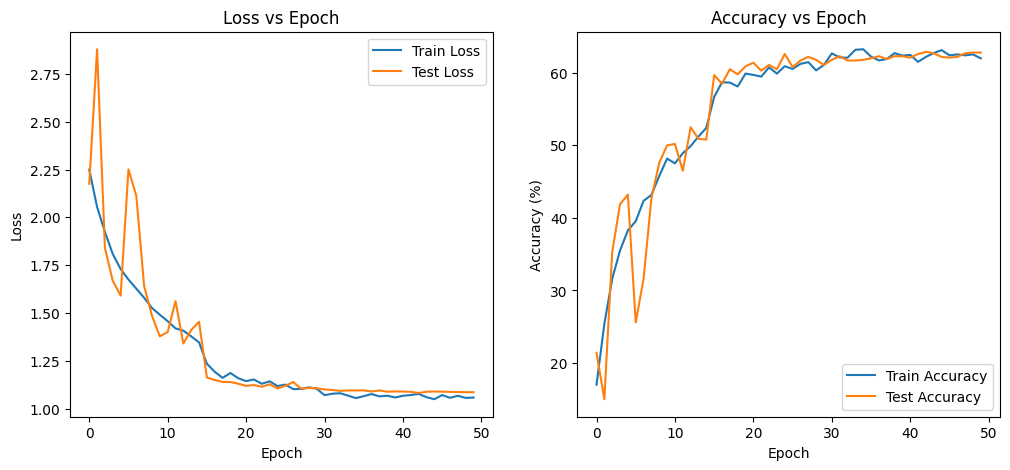

In [39]:
model_10 = TinyVGGModel(3, 45, 10, 2).to(device)
model_10

optimizer_10 = torch.optim.SGD(params=model_10.parameters(),
                            lr=0.1)

scheduler_10 = StepLR(optimizer_10, step_size=15, gamma=0.1)

train_model_scheduler(model_10,
            train_aug_subset_loader,
            test_subset_loader,
            loss_fn, optimizer_10,
            accuracy, scheduler_10,
            epochs=50, device=device)

# actaully traininf on full dataset

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 2.21054 | Train accuracy: 17.38%


Epochs:   1%|          | 1/100 [00:20<34:04, 20.65s/it]

Test loss: 2.10850 | Test accuracy: 25.00%

Epoch 1, Learning Rate: 0.1
Epoch: 1
---------
Train loss: 2.07181 | Train accuracy: 24.10%


Epochs:   2%|▏         | 2/100 [00:40<32:31, 19.92s/it]

Test loss: 2.77358 | Test accuracy: 16.40%

Epoch 2, Learning Rate: 0.1
Epoch: 2
---------
Train loss: 1.96446 | Train accuracy: 29.16%


Epochs:   3%|▎         | 3/100 [01:00<32:26, 20.07s/it]

Test loss: 1.99086 | Test accuracy: 25.30%

Epoch 3, Learning Rate: 0.1
Epoch: 3
---------
Train loss: 1.84335 | Train accuracy: 34.66%


Epochs:   4%|▍         | 4/100 [01:19<31:43, 19.83s/it]

Test loss: 1.77077 | Test accuracy: 36.20%

Epoch 4, Learning Rate: 0.1
Epoch: 4
---------
Train loss: 1.74930 | Train accuracy: 37.48%


Epochs:   5%|▌         | 5/100 [01:39<31:31, 19.92s/it]

Test loss: 1.56871 | Test accuracy: 43.00%

Epoch 5, Learning Rate: 0.1
Epoch: 5
---------
Train loss: 1.70036 | Train accuracy: 38.88%


Epochs:   6%|▌         | 6/100 [02:00<31:31, 20.12s/it]

Test loss: 1.66293 | Test accuracy: 41.40%

Epoch 6, Learning Rate: 0.1
Epoch: 6
---------
Train loss: 1.63765 | Train accuracy: 40.60%


Epochs:   7%|▋         | 7/100 [02:19<30:45, 19.85s/it]

Test loss: 1.75994 | Test accuracy: 41.60%

Epoch 7, Learning Rate: 0.1
Epoch: 7
---------
Train loss: 1.60575 | Train accuracy: 42.90%


Epochs:   8%|▊         | 8/100 [02:39<30:32, 19.92s/it]

Test loss: 1.62657 | Test accuracy: 42.90%

Epoch 8, Learning Rate: 0.1
Epoch: 8
---------
Train loss: 1.57666 | Train accuracy: 43.60%


Epochs:   9%|▉         | 9/100 [02:58<29:51, 19.69s/it]

Test loss: 1.54679 | Test accuracy: 44.10%

Epoch 9, Learning Rate: 0.1
Epoch: 9
---------
Train loss: 1.53329 | Train accuracy: 45.34%


Epochs:  10%|█         | 10/100 [03:18<29:34, 19.72s/it]

Test loss: 1.43475 | Test accuracy: 47.30%

Epoch 10, Learning Rate: 0.1
Epoch: 10
---------
Train loss: 1.50246 | Train accuracy: 46.94%


Epochs:  11%|█         | 11/100 [03:38<29:07, 19.63s/it]

Test loss: 1.63943 | Test accuracy: 42.10%

Epoch 11, Learning Rate: 0.1
Epoch: 11
---------
Train loss: 1.46219 | Train accuracy: 48.10%


Epochs:  12%|█▏        | 12/100 [03:57<28:46, 19.62s/it]

Test loss: 1.75368 | Test accuracy: 44.80%

Epoch 12, Learning Rate: 0.1
Epoch: 12
---------
Train loss: 1.45126 | Train accuracy: 48.82%


Epochs:  13%|█▎        | 13/100 [04:17<28:33, 19.69s/it]

Test loss: 1.33151 | Test accuracy: 53.10%

Epoch 13, Learning Rate: 0.1
Epoch: 13
---------
Train loss: 1.40655 | Train accuracy: 50.14%


Epochs:  14%|█▍        | 14/100 [04:36<27:53, 19.46s/it]

Test loss: 1.53185 | Test accuracy: 50.50%

Epoch 14, Learning Rate: 0.1
Epoch: 14
---------
Train loss: 1.38910 | Train accuracy: 50.70%


Epochs:  15%|█▌        | 15/100 [04:56<27:42, 19.56s/it]

Test loss: 1.94131 | Test accuracy: 35.50%

Epoch 15, Learning Rate: 0.1
Epoch: 15
---------
Train loss: 1.35548 | Train accuracy: 51.90%


Epochs:  16%|█▌        | 16/100 [05:17<28:14, 20.17s/it]

Test loss: 1.55907 | Test accuracy: 45.40%

Epoch 16, Learning Rate: 0.1
Epoch: 16
---------
Train loss: 1.33069 | Train accuracy: 52.66%


Epochs:  17%|█▋        | 17/100 [05:37<27:47, 20.08s/it]

Test loss: 1.26770 | Test accuracy: 55.00%

Epoch 17, Learning Rate: 0.1
Epoch: 17
---------
Train loss: 1.32511 | Train accuracy: 52.76%


Epochs:  18%|█▊        | 18/100 [05:57<27:10, 19.88s/it]

Test loss: 1.95605 | Test accuracy: 38.00%

Epoch 18, Learning Rate: 0.1
Epoch: 18
---------
Train loss: 1.30613 | Train accuracy: 54.24%


Epochs:  19%|█▉        | 19/100 [06:16<26:32, 19.66s/it]

Test loss: 1.37009 | Test accuracy: 53.50%

Epoch 19, Learning Rate: 0.1
Epoch: 19
---------
Train loss: 1.28192 | Train accuracy: 54.16%


Epochs:  20%|██        | 20/100 [06:36<26:15, 19.69s/it]

Test loss: 1.59042 | Test accuracy: 43.50%

Epoch 20, Learning Rate: 0.1
Epoch: 20
---------
Train loss: 1.28718 | Train accuracy: 55.28%


Epochs:  21%|██        | 21/100 [06:55<25:40, 19.50s/it]

Test loss: 1.52274 | Test accuracy: 48.20%

Epoch 21, Learning Rate: 0.1
Epoch: 21
---------
Train loss: 1.25775 | Train accuracy: 55.28%


Epochs:  22%|██▏       | 22/100 [07:14<25:29, 19.61s/it]

Test loss: 1.43494 | Test accuracy: 52.90%

Epoch 22, Learning Rate: 0.1
Epoch: 22
---------
Train loss: 1.22675 | Train accuracy: 57.06%


Epochs:  23%|██▎       | 23/100 [07:33<24:52, 19.39s/it]

Test loss: 1.32198 | Test accuracy: 53.10%

Epoch 23, Learning Rate: 0.1
Epoch: 23
---------
Train loss: 1.21780 | Train accuracy: 56.56%


Epochs:  24%|██▍       | 24/100 [07:53<24:37, 19.44s/it]

Test loss: 1.68254 | Test accuracy: 46.30%

Epoch 24, Learning Rate: 0.1
Epoch: 24
---------
Train loss: 1.21196 | Train accuracy: 57.12%


Epochs:  25%|██▌       | 25/100 [08:11<23:56, 19.15s/it]

Test loss: 1.42365 | Test accuracy: 51.30%

Epoch 25, Learning Rate: 0.1
Epoch: 25
---------
Train loss: 1.19522 | Train accuracy: 57.68%


Epochs:  26%|██▌       | 26/100 [08:31<23:43, 19.23s/it]

Test loss: 1.30488 | Test accuracy: 55.80%

Epoch 26, Learning Rate: 0.1
Epoch: 26
---------
Train loss: 1.19524 | Train accuracy: 57.62%


Epochs:  27%|██▋       | 27/100 [08:50<23:13, 19.08s/it]

Test loss: 1.76710 | Test accuracy: 47.10%

Epoch 27, Learning Rate: 0.1
Epoch: 27
---------
Train loss: 1.17140 | Train accuracy: 58.04%


Epochs:  28%|██▊       | 28/100 [09:09<23:04, 19.22s/it]

Test loss: 1.31625 | Test accuracy: 55.10%

Epoch 28, Learning Rate: 0.1
Epoch: 28
---------
Train loss: 1.14815 | Train accuracy: 60.06%


Epochs:  29%|██▉       | 29/100 [09:28<22:35, 19.10s/it]

Test loss: 1.43663 | Test accuracy: 53.20%

Epoch 29, Learning Rate: 0.1
Epoch: 29
---------
Train loss: 1.18091 | Train accuracy: 58.36%


Epochs:  30%|███       | 30/100 [09:47<22:22, 19.18s/it]

Test loss: 1.41649 | Test accuracy: 52.20%

Epoch 30, Learning Rate: 0.010000000000000002
Epoch: 30
---------
Train loss: 1.06841 | Train accuracy: 61.90%


Epochs:  31%|███       | 31/100 [10:06<22:03, 19.18s/it]

Test loss: 1.11094 | Test accuracy: 62.70%

Epoch 31, Learning Rate: 0.010000000000000002
Epoch: 31
---------
Train loss: 0.99761 | Train accuracy: 65.66%


Epochs:  32%|███▏      | 32/100 [10:26<21:42, 19.15s/it]

Test loss: 1.09549 | Test accuracy: 62.40%

Epoch 32, Learning Rate: 0.010000000000000002
Epoch: 32
---------
Train loss: 1.00260 | Train accuracy: 65.06%


Epochs:  33%|███▎      | 33/100 [10:45<21:29, 19.25s/it]

Test loss: 1.09668 | Test accuracy: 63.70%

Epoch 33, Learning Rate: 0.010000000000000002
Epoch: 33
---------
Train loss: 0.97971 | Train accuracy: 65.40%


Epochs:  34%|███▍      | 34/100 [11:04<20:56, 19.04s/it]

Test loss: 1.10116 | Test accuracy: 63.70%

Epoch 34, Learning Rate: 0.010000000000000002
Epoch: 34
---------
Train loss: 0.97531 | Train accuracy: 65.96%


Epochs:  35%|███▌      | 35/100 [11:23<20:46, 19.18s/it]

Test loss: 1.09883 | Test accuracy: 63.10%

Epoch 35, Learning Rate: 0.010000000000000002
Epoch: 35
---------
Train loss: 0.97960 | Train accuracy: 65.58%


Epochs:  36%|███▌      | 36/100 [11:42<20:18, 19.04s/it]

Test loss: 1.09038 | Test accuracy: 62.40%

Epoch 36, Learning Rate: 0.010000000000000002
Epoch: 36
---------
Train loss: 0.96895 | Train accuracy: 65.88%


Epochs:  37%|███▋      | 37/100 [12:01<20:09, 19.20s/it]

Test loss: 1.09402 | Test accuracy: 62.50%

Epoch 37, Learning Rate: 0.010000000000000002
Epoch: 37
---------
Train loss: 0.95669 | Train accuracy: 66.36%


Epochs:  38%|███▊      | 38/100 [12:20<19:39, 19.03s/it]

Test loss: 1.08607 | Test accuracy: 62.80%

Epoch 38, Learning Rate: 0.010000000000000002
Epoch: 38
---------
Train loss: 0.95172 | Train accuracy: 67.28%


Epochs:  39%|███▉      | 39/100 [12:40<19:29, 19.17s/it]

Test loss: 1.11272 | Test accuracy: 62.50%

Epoch 39, Learning Rate: 0.010000000000000002
Epoch: 39
---------
Train loss: 0.94930 | Train accuracy: 66.80%


Epochs:  40%|████      | 40/100 [12:58<19:02, 19.04s/it]

Test loss: 1.09556 | Test accuracy: 63.50%

Epoch 40, Learning Rate: 0.010000000000000002
Epoch: 40
---------
Train loss: 0.94960 | Train accuracy: 66.24%


Epochs:  41%|████      | 41/100 [13:18<18:51, 19.17s/it]

Test loss: 1.10517 | Test accuracy: 63.00%

Epoch 41, Learning Rate: 0.010000000000000002
Epoch: 41
---------
Train loss: 0.94934 | Train accuracy: 66.66%


Epochs:  42%|████▏     | 42/100 [13:36<18:22, 19.01s/it]

Test loss: 1.10464 | Test accuracy: 63.70%

Epoch 42, Learning Rate: 0.010000000000000002
Epoch: 42
---------
Train loss: 0.94575 | Train accuracy: 66.70%


Epochs:  43%|████▎     | 43/100 [13:56<18:11, 19.15s/it]

Test loss: 1.09351 | Test accuracy: 63.40%

Epoch 43, Learning Rate: 0.010000000000000002
Epoch: 43
---------
Train loss: 0.93638 | Train accuracy: 66.84%


Epochs:  44%|████▍     | 44/100 [14:14<17:43, 18.99s/it]

Test loss: 1.10734 | Test accuracy: 63.50%

Epoch 44, Learning Rate: 0.010000000000000002
Epoch: 44
---------
Train loss: 0.93303 | Train accuracy: 67.78%


Epochs:  45%|████▌     | 45/100 [14:34<17:34, 19.17s/it]

Test loss: 1.07532 | Test accuracy: 64.10%

Epoch 45, Learning Rate: 0.010000000000000002
Epoch: 45
---------
Train loss: 0.92032 | Train accuracy: 67.48%


Epochs:  46%|████▌     | 46/100 [14:53<17:13, 19.14s/it]

Test loss: 1.10416 | Test accuracy: 63.40%

Epoch 46, Learning Rate: 0.010000000000000002
Epoch: 46
---------
Train loss: 0.93151 | Train accuracy: 67.26%


Epochs:  47%|████▋     | 47/100 [15:12<16:53, 19.13s/it]

Test loss: 1.08652 | Test accuracy: 64.30%

Epoch 47, Learning Rate: 0.010000000000000002
Epoch: 47
---------
Train loss: 0.92475 | Train accuracy: 67.68%


Epochs:  48%|████▊     | 48/100 [15:32<16:38, 19.21s/it]

Test loss: 1.07190 | Test accuracy: 64.10%

Epoch 48, Learning Rate: 0.010000000000000002
Epoch: 48
---------
Train loss: 0.92052 | Train accuracy: 68.38%


Epochs:  49%|████▉     | 49/100 [15:50<16:12, 19.07s/it]

Test loss: 1.08295 | Test accuracy: 64.20%

Epoch 49, Learning Rate: 0.010000000000000002
Epoch: 49
---------
Train loss: 0.91096 | Train accuracy: 68.62%


Epochs:  50%|█████     | 50/100 [16:10<16:00, 19.20s/it]

Test loss: 1.06314 | Test accuracy: 63.80%

Epoch 50, Learning Rate: 0.010000000000000002
Epoch: 50
---------
Train loss: 0.91552 | Train accuracy: 68.12%


Epochs:  51%|█████     | 51/100 [16:29<15:32, 19.04s/it]

Test loss: 1.10044 | Test accuracy: 63.60%

Epoch 51, Learning Rate: 0.010000000000000002
Epoch: 51
---------
Train loss: 0.90337 | Train accuracy: 68.12%


Epochs:  52%|█████▏    | 52/100 [16:48<15:21, 19.20s/it]

Test loss: 1.11812 | Test accuracy: 62.40%

Epoch 52, Learning Rate: 0.010000000000000002
Epoch: 52
---------
Train loss: 0.92127 | Train accuracy: 67.50%


Epochs:  53%|█████▎    | 53/100 [17:07<14:55, 19.05s/it]

Test loss: 1.08867 | Test accuracy: 63.60%

Epoch 53, Learning Rate: 0.010000000000000002
Epoch: 53
---------
Train loss: 0.91166 | Train accuracy: 68.64%


Epochs:  54%|█████▍    | 54/100 [17:26<14:41, 19.16s/it]

Test loss: 1.06678 | Test accuracy: 64.40%

Epoch 54, Learning Rate: 0.010000000000000002
Epoch: 54
---------
Train loss: 0.90976 | Train accuracy: 68.20%


Epochs:  55%|█████▌    | 55/100 [17:45<14:15, 19.02s/it]

Test loss: 1.08186 | Test accuracy: 64.80%

Epoch 55, Learning Rate: 0.010000000000000002
Epoch: 55
---------
Train loss: 0.90435 | Train accuracy: 68.36%


Epochs:  56%|█████▌    | 56/100 [18:04<14:04, 19.19s/it]

Test loss: 1.10676 | Test accuracy: 64.50%

Epoch 56, Learning Rate: 0.010000000000000002
Epoch: 56
---------
Train loss: 0.89538 | Train accuracy: 68.52%


Epochs:  57%|█████▋    | 57/100 [18:23<13:38, 19.04s/it]

Test loss: 1.06984 | Test accuracy: 64.40%

Epoch 57, Learning Rate: 0.010000000000000002
Epoch: 57
---------
Train loss: 0.88093 | Train accuracy: 68.80%


Epochs:  58%|█████▊    | 58/100 [18:43<13:26, 19.21s/it]

Test loss: 1.05801 | Test accuracy: 64.40%

Epoch 58, Learning Rate: 0.010000000000000002
Epoch: 58
---------
Train loss: 0.89407 | Train accuracy: 68.50%


Epochs:  59%|█████▉    | 59/100 [19:02<13:01, 19.07s/it]

Test loss: 1.06895 | Test accuracy: 63.40%

Epoch 59, Learning Rate: 0.010000000000000002
Epoch: 59
---------
Train loss: 0.88326 | Train accuracy: 68.96%


Epochs:  60%|██████    | 60/100 [19:21<12:49, 19.23s/it]

Test loss: 1.11041 | Test accuracy: 63.10%

Epoch 60, Learning Rate: 0.0010000000000000002
Epoch: 60
---------
Train loss: 0.87550 | Train accuracy: 69.20%


Epochs:  61%|██████    | 61/100 [19:41<12:33, 19.33s/it]

Test loss: 1.07846 | Test accuracy: 64.10%

Epoch 61, Learning Rate: 0.0010000000000000002
Epoch: 61
---------
Train loss: 0.87373 | Train accuracy: 68.90%


Epochs:  62%|██████▏   | 62/100 [20:00<12:18, 19.43s/it]

Test loss: 1.07666 | Test accuracy: 64.00%

Epoch 62, Learning Rate: 0.0010000000000000002
Epoch: 62
---------
Train loss: 0.86225 | Train accuracy: 69.36%


Epochs:  63%|██████▎   | 63/100 [20:20<12:00, 19.49s/it]

Test loss: 1.07340 | Test accuracy: 64.30%

Epoch 63, Learning Rate: 0.0010000000000000002
Epoch: 63
---------
Train loss: 0.86929 | Train accuracy: 69.82%


Epochs:  64%|██████▍   | 64/100 [20:39<11:33, 19.25s/it]

Test loss: 1.06840 | Test accuracy: 63.90%

Epoch 64, Learning Rate: 0.0010000000000000002
Epoch: 64
---------
Train loss: 0.86558 | Train accuracy: 70.16%


Epochs:  65%|██████▌   | 65/100 [20:58<11:16, 19.33s/it]

Test loss: 1.07029 | Test accuracy: 64.10%

Epoch 65, Learning Rate: 0.0010000000000000002
Epoch: 65
---------
Train loss: 0.87381 | Train accuracy: 69.44%


Epochs:  66%|██████▌   | 66/100 [21:17<10:50, 19.14s/it]

Test loss: 1.06862 | Test accuracy: 64.00%

Epoch 66, Learning Rate: 0.0010000000000000002
Epoch: 66
---------
Train loss: 0.87676 | Train accuracy: 68.68%


Epochs:  67%|██████▋   | 67/100 [21:37<10:38, 19.34s/it]

Test loss: 1.06840 | Test accuracy: 64.10%

Epoch 67, Learning Rate: 0.0010000000000000002
Epoch: 67
---------
Train loss: 0.86497 | Train accuracy: 70.04%


Epochs:  68%|██████▊   | 68/100 [21:56<10:14, 19.21s/it]

Test loss: 1.06942 | Test accuracy: 64.00%

Epoch 68, Learning Rate: 0.0010000000000000002
Epoch: 68
---------
Train loss: 0.87114 | Train accuracy: 69.40%


Epochs:  69%|██████▉   | 69/100 [22:16<10:03, 19.48s/it]

Test loss: 1.07335 | Test accuracy: 64.30%

Epoch 69, Learning Rate: 0.0010000000000000002
Epoch: 69
---------
Train loss: 0.86853 | Train accuracy: 69.28%


Epochs:  70%|███████   | 70/100 [22:35<09:42, 19.41s/it]

Test loss: 1.07341 | Test accuracy: 64.70%

Epoch 70, Learning Rate: 0.0010000000000000002
Epoch: 70
---------
Train loss: 0.87674 | Train accuracy: 69.14%


Epochs:  71%|███████   | 71/100 [22:55<09:24, 19.46s/it]

Test loss: 1.07266 | Test accuracy: 64.10%

Epoch 71, Learning Rate: 0.0010000000000000002
Epoch: 71
---------
Train loss: 0.85307 | Train accuracy: 70.76%


Epochs:  72%|███████▏  | 72/100 [23:14<09:02, 19.37s/it]

Test loss: 1.06463 | Test accuracy: 63.80%

Epoch 72, Learning Rate: 0.0010000000000000002
Epoch: 72
---------
Train loss: 0.85486 | Train accuracy: 69.30%


Epochs:  73%|███████▎  | 73/100 [23:33<08:44, 19.41s/it]

Test loss: 1.06775 | Test accuracy: 63.60%

Epoch 73, Learning Rate: 0.0010000000000000002
Epoch: 73
---------
Train loss: 0.87383 | Train accuracy: 69.46%


Epochs:  74%|███████▍  | 74/100 [23:53<08:25, 19.43s/it]

Test loss: 1.06826 | Test accuracy: 64.10%

Epoch 74, Learning Rate: 0.0010000000000000002
Epoch: 74
---------
Train loss: 0.86383 | Train accuracy: 70.14%


Epochs:  75%|███████▌  | 75/100 [24:11<08:00, 19.21s/it]

Test loss: 1.06669 | Test accuracy: 64.20%

Epoch 75, Learning Rate: 0.0010000000000000002
Epoch: 75
---------
Train loss: 0.86668 | Train accuracy: 69.78%


Epochs:  76%|███████▌  | 76/100 [24:31<07:43, 19.31s/it]

Test loss: 1.06950 | Test accuracy: 64.50%

Epoch 76, Learning Rate: 0.0010000000000000002
Epoch: 76
---------
Train loss: 0.85762 | Train accuracy: 69.96%


Epochs:  77%|███████▋  | 77/100 [24:49<07:19, 19.09s/it]

Test loss: 1.06775 | Test accuracy: 64.10%

Epoch 77, Learning Rate: 0.0010000000000000002
Epoch: 77
---------
Train loss: 0.86183 | Train accuracy: 69.76%


Epochs:  78%|███████▊  | 78/100 [25:09<07:03, 19.23s/it]

Test loss: 1.06904 | Test accuracy: 64.10%

Epoch 78, Learning Rate: 0.0010000000000000002
Epoch: 78
---------
Train loss: 0.86094 | Train accuracy: 69.90%


Epochs:  79%|███████▉  | 79/100 [25:28<06:39, 19.04s/it]

Test loss: 1.06519 | Test accuracy: 64.40%

Epoch 79, Learning Rate: 0.0010000000000000002
Epoch: 79
---------
Train loss: 0.85505 | Train accuracy: 70.98%


Epochs:  80%|████████  | 80/100 [25:47<06:22, 19.11s/it]

Test loss: 1.06759 | Test accuracy: 64.30%

Epoch 80, Learning Rate: 0.0010000000000000002
Epoch: 80
---------
Train loss: 0.86821 | Train accuracy: 69.40%


Epochs:  81%|████████  | 81/100 [26:05<05:59, 18.93s/it]

Test loss: 1.07242 | Test accuracy: 64.10%

Epoch 81, Learning Rate: 0.0010000000000000002
Epoch: 81
---------
Train loss: 0.86216 | Train accuracy: 69.74%


Epochs:  82%|████████▏ | 82/100 [26:25<05:42, 19.03s/it]

Test loss: 1.07463 | Test accuracy: 64.40%

Epoch 82, Learning Rate: 0.0010000000000000002
Epoch: 82
---------
Train loss: 0.86981 | Train accuracy: 69.64%


Epochs:  83%|████████▎ | 83/100 [26:43<05:21, 18.89s/it]

Test loss: 1.07513 | Test accuracy: 64.40%

Epoch 83, Learning Rate: 0.0010000000000000002
Epoch: 83
---------
Train loss: 0.87614 | Train accuracy: 69.56%


Epochs:  84%|████████▍ | 84/100 [27:03<05:04, 19.04s/it]

Test loss: 1.06511 | Test accuracy: 64.30%

Epoch 84, Learning Rate: 0.0010000000000000002
Epoch: 84
---------
Train loss: 0.86207 | Train accuracy: 70.42%


Epochs:  85%|████████▌ | 85/100 [27:21<04:43, 18.90s/it]

Test loss: 1.06833 | Test accuracy: 63.90%

Epoch 85, Learning Rate: 0.0010000000000000002
Epoch: 85
---------
Train loss: 0.85116 | Train accuracy: 70.16%


Epochs:  86%|████████▌ | 86/100 [27:41<04:26, 19.03s/it]

Test loss: 1.07029 | Test accuracy: 64.30%

Epoch 86, Learning Rate: 0.0010000000000000002
Epoch: 86
---------
Train loss: 0.85205 | Train accuracy: 69.50%


Epochs:  87%|████████▋ | 87/100 [27:59<04:05, 18.87s/it]

Test loss: 1.07571 | Test accuracy: 63.50%

Epoch 87, Learning Rate: 0.0010000000000000002
Epoch: 87
---------
Train loss: 0.87163 | Train accuracy: 69.42%


Epochs:  88%|████████▊ | 88/100 [28:18<03:47, 18.99s/it]

Test loss: 1.07303 | Test accuracy: 64.40%

Epoch 88, Learning Rate: 0.0010000000000000002
Epoch: 88
---------
Train loss: 0.84576 | Train accuracy: 69.96%


Epochs:  89%|████████▉ | 89/100 [28:37<03:27, 18.88s/it]

Test loss: 1.07121 | Test accuracy: 64.60%

Epoch 89, Learning Rate: 0.0010000000000000002
Epoch: 89
---------
Train loss: 0.85044 | Train accuracy: 70.26%


Epochs:  90%|█████████ | 90/100 [28:56<03:10, 19.07s/it]

Test loss: 1.06392 | Test accuracy: 64.30%

Epoch 90, Learning Rate: 0.00010000000000000003
Epoch: 90
---------
Train loss: 0.84727 | Train accuracy: 70.82%


Epochs:  91%|█████████ | 91/100 [29:15<02:50, 18.99s/it]

Test loss: 1.06498 | Test accuracy: 64.30%

Epoch 91, Learning Rate: 0.00010000000000000003
Epoch: 91
---------
Train loss: 0.85410 | Train accuracy: 69.98%


Epochs:  92%|█████████▏| 92/100 [29:34<02:31, 19.00s/it]

Test loss: 1.06569 | Test accuracy: 64.40%

Epoch 92, Learning Rate: 0.00010000000000000003
Epoch: 92
---------
Train loss: 0.84993 | Train accuracy: 70.46%


Epochs:  93%|█████████▎| 93/100 [29:53<02:13, 19.03s/it]

Test loss: 1.06603 | Test accuracy: 64.40%

Epoch 93, Learning Rate: 0.00010000000000000003
Epoch: 93
---------
Train loss: 0.85168 | Train accuracy: 69.84%


Epochs:  94%|█████████▍| 94/100 [30:12<01:53, 18.91s/it]

Test loss: 1.06594 | Test accuracy: 64.40%

Epoch 94, Learning Rate: 0.00010000000000000003
Epoch: 94
---------
Train loss: 0.85850 | Train accuracy: 69.50%


Epochs:  95%|█████████▌| 95/100 [30:31<01:35, 19.01s/it]

Test loss: 1.06642 | Test accuracy: 64.50%

Epoch 95, Learning Rate: 0.00010000000000000003
Epoch: 95
---------
Train loss: 0.85452 | Train accuracy: 69.96%


Epochs:  96%|█████████▌| 96/100 [30:50<01:15, 18.85s/it]

Test loss: 1.06736 | Test accuracy: 64.50%

Epoch 96, Learning Rate: 0.00010000000000000003
Epoch: 96
---------
Train loss: 0.85720 | Train accuracy: 69.84%


Epochs:  97%|█████████▋| 97/100 [31:09<00:56, 18.98s/it]

Test loss: 1.06777 | Test accuracy: 64.40%

Epoch 97, Learning Rate: 0.00010000000000000003
Epoch: 97
---------
Train loss: 0.84703 | Train accuracy: 70.20%


Epochs:  98%|█████████▊| 98/100 [31:27<00:37, 18.82s/it]

Test loss: 1.06812 | Test accuracy: 64.40%

Epoch 98, Learning Rate: 0.00010000000000000003
Epoch: 98
---------
Train loss: 0.84545 | Train accuracy: 70.98%


Epochs:  99%|█████████▉| 99/100 [31:47<00:18, 18.95s/it]

Test loss: 1.06815 | Test accuracy: 64.40%

Epoch 99, Learning Rate: 0.00010000000000000003
Epoch: 99
---------
Train loss: 0.86404 | Train accuracy: 70.46%


Epochs: 100%|██████████| 100/100 [32:05<00:00, 19.26s/it]

Test loss: 1.06746 | Test accuracy: 64.30%

Epoch 100, Learning Rate: 0.00010000000000000003
Training and testing took 1925.683 seconds


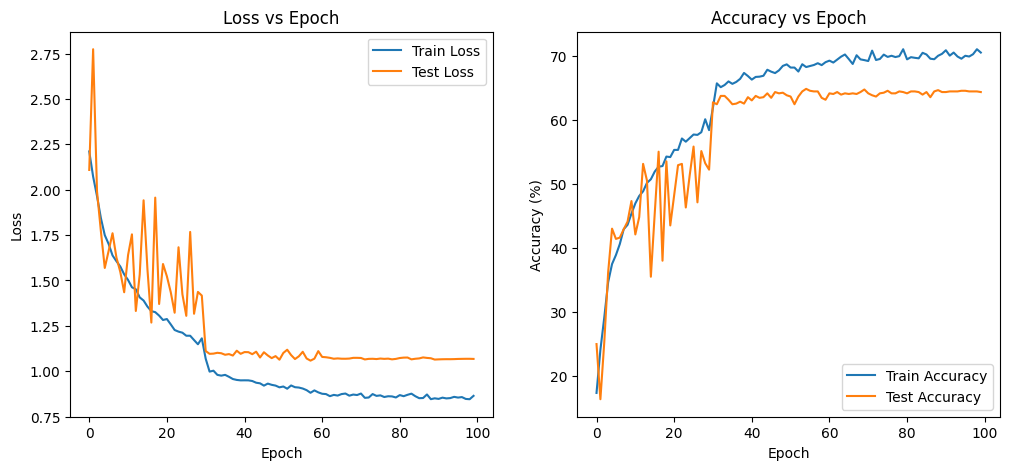

In [15]:
from torch.optim.lr_scheduler import StepLR
# using the hyperparameters that did the best with the data subset
model_tinyVGG = TinyVGGModel(3, 30, 10, 2).to(device)
model_tinyVGG

optimizer_tinyVGG = torch.optim.SGD(params=model_tinyVGG.parameters(),
                            lr=0.1)

scheduler_tinyVGG = StepLR(optimizer_tinyVGG, step_size=30, gamma=0.1)

train_model_scheduler(model_tinyVGG,
            train_aug_subset_loader,
            test_subset_loader,
            loss_fn, optimizer_tinyVGG,
            accuracy, scheduler_tinyVGG,
            epochs=100, device=device)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 2.18549 | Train accuracy: 19.26%


Epochs:   1%|          | 1/100 [00:22<36:32, 22.14s/it]

Test loss: 2.10256 | Test accuracy: 22.80%

Epoch 1, Learning Rate: 0.1
Epoch: 1
---------
Train loss: 2.00365 | Train accuracy: 28.98%


Epochs:   2%|▏         | 2/100 [00:40<32:55, 20.16s/it]

Test loss: 2.17168 | Test accuracy: 21.70%

Epoch 2, Learning Rate: 0.1
Epoch: 2
---------
Train loss: 1.86086 | Train accuracy: 33.22%


Epochs:   3%|▎         | 3/100 [01:04<35:13, 21.79s/it]

Test loss: 1.92319 | Test accuracy: 28.90%

Epoch 3, Learning Rate: 0.1
Epoch: 3
---------
Train loss: 1.77959 | Train accuracy: 36.32%


Epochs:   4%|▍         | 4/100 [01:27<35:28, 22.18s/it]

Test loss: 1.70206 | Test accuracy: 39.50%

Epoch 4, Learning Rate: 0.1
Epoch: 4
---------
Train loss: 1.70940 | Train accuracy: 38.62%


Epochs:   5%|▌         | 5/100 [01:46<33:05, 20.90s/it]

Test loss: 1.62464 | Test accuracy: 40.50%

Epoch 5, Learning Rate: 0.1
Epoch: 5
---------
Train loss: 1.64189 | Train accuracy: 40.46%


Epochs:   6%|▌         | 6/100 [02:07<33:08, 21.15s/it]

Test loss: 1.57345 | Test accuracy: 46.10%

Epoch 6, Learning Rate: 0.1
Epoch: 6
---------
Train loss: 1.60911 | Train accuracy: 43.40%


Epochs:   7%|▋         | 7/100 [02:26<31:33, 20.36s/it]

Test loss: 1.52642 | Test accuracy: 44.60%

Epoch 7, Learning Rate: 0.1
Epoch: 7
---------
Train loss: 1.56506 | Train accuracy: 43.50%


Epochs:   8%|▊         | 8/100 [02:47<31:21, 20.45s/it]

Test loss: 1.50250 | Test accuracy: 47.70%

Epoch 8, Learning Rate: 0.1
Epoch: 8
---------
Train loss: 1.55219 | Train accuracy: 44.70%


Epochs:   9%|▉         | 9/100 [03:06<30:19, 19.99s/it]

Test loss: 1.76630 | Test accuracy: 44.30%

Epoch 9, Learning Rate: 0.1
Epoch: 9
---------
Train loss: 1.51154 | Train accuracy: 46.32%


Epochs:  10%|█         | 10/100 [03:26<30:08, 20.10s/it]

Test loss: 1.43482 | Test accuracy: 50.60%

Epoch 10, Learning Rate: 0.1
Epoch: 10
---------
Train loss: 1.48180 | Train accuracy: 46.94%


Epochs:  11%|█         | 11/100 [03:44<29:08, 19.64s/it]

Test loss: 1.48008 | Test accuracy: 48.30%

Epoch 11, Learning Rate: 0.1
Epoch: 11
---------
Train loss: 1.43138 | Train accuracy: 48.94%


Epochs:  12%|█▏        | 12/100 [04:05<29:02, 19.80s/it]

Test loss: 1.52474 | Test accuracy: 47.90%

Epoch 12, Learning Rate: 0.1
Epoch: 12
---------
Train loss: 1.43921 | Train accuracy: 49.20%


Epochs:  13%|█▎        | 13/100 [04:23<28:14, 19.48s/it]

Test loss: 1.33704 | Test accuracy: 53.00%

Epoch 13, Learning Rate: 0.1
Epoch: 13
---------
Train loss: 1.40487 | Train accuracy: 50.34%


Epochs:  14%|█▍        | 14/100 [04:44<28:15, 19.72s/it]

Test loss: 1.41187 | Test accuracy: 50.80%

Epoch 14, Learning Rate: 0.1
Epoch: 14
---------
Train loss: 1.36879 | Train accuracy: 51.94%


Epochs:  15%|█▌        | 15/100 [05:03<27:43, 19.57s/it]

Test loss: 1.34047 | Test accuracy: 53.60%

Epoch 15, Learning Rate: 0.1
Epoch: 15
---------
Train loss: 1.35639 | Train accuracy: 51.94%


Epochs:  16%|█▌        | 16/100 [05:22<27:19, 19.52s/it]

Test loss: 1.41806 | Test accuracy: 52.40%

Epoch 16, Learning Rate: 0.1
Epoch: 16
---------
Train loss: 1.33541 | Train accuracy: 52.48%


Epochs:  17%|█▋        | 17/100 [05:42<27:02, 19.54s/it]

Test loss: 1.52506 | Test accuracy: 46.20%

Epoch 17, Learning Rate: 0.1
Epoch: 17
---------
Train loss: 1.32620 | Train accuracy: 53.52%


Epochs:  18%|█▊        | 18/100 [06:01<26:35, 19.46s/it]

Test loss: 1.50702 | Test accuracy: 49.20%

Epoch 18, Learning Rate: 0.1
Epoch: 18
---------
Train loss: 1.31851 | Train accuracy: 53.90%


Epochs:  19%|█▉        | 19/100 [06:21<26:19, 19.50s/it]

Test loss: 1.44838 | Test accuracy: 50.60%

Epoch 19, Learning Rate: 0.1
Epoch: 19
---------
Train loss: 1.29295 | Train accuracy: 54.64%


Epochs:  20%|██        | 20/100 [06:40<25:46, 19.33s/it]

Test loss: 1.35387 | Test accuracy: 53.10%

Epoch 20, Learning Rate: 0.1
Epoch: 20
---------
Train loss: 1.27024 | Train accuracy: 55.40%


Epochs:  21%|██        | 21/100 [06:59<25:31, 19.38s/it]

Test loss: 1.37076 | Test accuracy: 55.00%

Epoch 21, Learning Rate: 0.1
Epoch: 21
---------
Train loss: 1.25080 | Train accuracy: 56.10%


Epochs:  22%|██▏       | 22/100 [07:18<25:05, 19.30s/it]

Test loss: 1.18952 | Test accuracy: 59.90%

Epoch 22, Learning Rate: 0.1
Epoch: 22
---------
Train loss: 1.24969 | Train accuracy: 55.92%


Epochs:  23%|██▎       | 23/100 [07:38<25:01, 19.50s/it]

Test loss: 1.29652 | Test accuracy: 56.00%

Epoch 23, Learning Rate: 0.1
Epoch: 23
---------
Train loss: 1.21829 | Train accuracy: 55.86%


Epochs:  24%|██▍       | 24/100 [07:57<24:28, 19.32s/it]

Test loss: 1.37153 | Test accuracy: 55.00%

Epoch 24, Learning Rate: 0.1
Epoch: 24
---------
Train loss: 1.23067 | Train accuracy: 57.20%


Epochs:  25%|██▌       | 25/100 [08:17<24:21, 19.48s/it]

Test loss: 1.75379 | Test accuracy: 45.60%

Epoch 25, Learning Rate: 0.1
Epoch: 25
---------
Train loss: 1.21427 | Train accuracy: 57.38%


Epochs:  26%|██▌       | 26/100 [08:36<23:45, 19.26s/it]

Test loss: 1.28121 | Test accuracy: 55.70%

Epoch 26, Learning Rate: 0.1
Epoch: 26
---------
Train loss: 1.19977 | Train accuracy: 57.82%


Epochs:  27%|██▋       | 27/100 [08:56<23:37, 19.41s/it]

Test loss: 1.34368 | Test accuracy: 54.50%

Epoch 27, Learning Rate: 0.1
Epoch: 27
---------
Train loss: 1.19477 | Train accuracy: 58.04%


Epochs:  28%|██▊       | 28/100 [09:14<23:06, 19.25s/it]

Test loss: 1.31201 | Test accuracy: 55.70%

Epoch 28, Learning Rate: 0.1
Epoch: 28
---------
Train loss: 1.16318 | Train accuracy: 59.44%


Epochs:  29%|██▉       | 29/100 [09:34<22:57, 19.40s/it]

Test loss: 1.25385 | Test accuracy: 57.80%

Epoch 29, Learning Rate: 0.1
Epoch: 29
---------
Train loss: 1.17265 | Train accuracy: 58.86%


Epochs:  30%|███       | 30/100 [09:53<22:24, 19.21s/it]

Test loss: 1.22071 | Test accuracy: 58.10%

Epoch 30, Learning Rate: 0.1
Epoch: 30
---------
Train loss: 1.16918 | Train accuracy: 59.56%


Epochs:  31%|███       | 31/100 [10:13<22:16, 19.37s/it]

Test loss: 1.17923 | Test accuracy: 59.70%

Epoch 31, Learning Rate: 0.1
Epoch: 31
---------
Train loss: 1.15461 | Train accuracy: 59.74%


Epochs:  32%|███▏      | 32/100 [10:31<21:43, 19.16s/it]

Test loss: 1.35625 | Test accuracy: 55.50%

Epoch 32, Learning Rate: 0.1
Epoch: 32
---------
Train loss: 1.13101 | Train accuracy: 60.74%


Epochs:  33%|███▎      | 33/100 [10:51<21:32, 19.29s/it]

Test loss: 1.25697 | Test accuracy: 59.30%

Epoch 33, Learning Rate: 0.1
Epoch: 33
---------
Train loss: 1.14090 | Train accuracy: 60.18%


Epochs:  34%|███▍      | 34/100 [11:10<21:00, 19.10s/it]

Test loss: 1.33367 | Test accuracy: 56.20%

Epoch 34, Learning Rate: 0.1
Epoch: 34
---------
Train loss: 1.13344 | Train accuracy: 60.82%


Epochs:  35%|███▌      | 35/100 [11:30<20:57, 19.35s/it]

Test loss: 1.35493 | Test accuracy: 53.80%

Epoch 35, Learning Rate: 0.1
Epoch: 35
---------
Train loss: 1.10439 | Train accuracy: 61.64%


Epochs:  36%|███▌      | 36/100 [11:49<20:36, 19.33s/it]

Test loss: 1.16003 | Test accuracy: 61.60%

Epoch 36, Learning Rate: 0.1
Epoch: 36
---------
Train loss: 1.08511 | Train accuracy: 61.00%


Epochs:  37%|███▋      | 37/100 [12:09<20:24, 19.44s/it]

Test loss: 1.27427 | Test accuracy: 59.20%

Epoch 37, Learning Rate: 0.1
Epoch: 37
---------
Train loss: 1.09321 | Train accuracy: 61.60%


Epochs:  38%|███▊      | 38/100 [12:27<19:54, 19.27s/it]

Test loss: 1.39187 | Test accuracy: 57.40%

Epoch 38, Learning Rate: 0.1
Epoch: 38
---------
Train loss: 1.11689 | Train accuracy: 60.28%


Epochs:  39%|███▉      | 39/100 [12:47<19:45, 19.44s/it]

Test loss: 1.42279 | Test accuracy: 52.60%

Epoch 39, Learning Rate: 0.1
Epoch: 39
---------
Train loss: 1.11287 | Train accuracy: 60.58%


Epochs:  40%|████      | 40/100 [13:11<20:51, 20.87s/it]

Test loss: 1.14436 | Test accuracy: 62.10%

Epoch 40, Learning Rate: 0.1
Epoch: 40
---------
Train loss: 1.07379 | Train accuracy: 62.12%


Epochs:  41%|████      | 41/100 [13:37<21:52, 22.25s/it]

Test loss: 1.31899 | Test accuracy: 57.90%

Epoch 41, Learning Rate: 0.1
Epoch: 41
---------
Train loss: 1.07687 | Train accuracy: 62.44%


Epochs:  42%|████▏     | 42/100 [13:57<20:53, 21.61s/it]

Test loss: 1.36000 | Test accuracy: 53.60%

Epoch 42, Learning Rate: 0.1
Epoch: 42
---------
Train loss: 1.06669 | Train accuracy: 62.02%


Epochs:  43%|████▎     | 43/100 [14:17<19:58, 21.02s/it]

Test loss: 1.37888 | Test accuracy: 57.00%

Epoch 43, Learning Rate: 0.1
Epoch: 43
---------
Train loss: 1.07355 | Train accuracy: 62.36%


Epochs:  44%|████▍     | 44/100 [14:36<19:02, 20.40s/it]

Test loss: 1.36182 | Test accuracy: 59.20%

Epoch 44, Learning Rate: 0.1
Epoch: 44
---------
Train loss: 1.07296 | Train accuracy: 62.36%


Epochs:  45%|████▌     | 45/100 [14:55<18:28, 20.16s/it]

Test loss: 1.28824 | Test accuracy: 59.70%

Epoch 45, Learning Rate: 0.1
Epoch: 45
---------
Train loss: 1.06571 | Train accuracy: 62.42%


Epochs:  46%|████▌     | 46/100 [15:14<17:47, 19.78s/it]

Test loss: 1.35241 | Test accuracy: 57.90%

Epoch 46, Learning Rate: 0.1
Epoch: 46
---------
Train loss: 1.06275 | Train accuracy: 63.10%


Epochs:  47%|████▋     | 47/100 [15:34<17:33, 19.87s/it]

Test loss: 1.22621 | Test accuracy: 59.40%

Epoch 47, Learning Rate: 0.1
Epoch: 47
---------
Train loss: 1.03817 | Train accuracy: 63.46%


Epochs:  48%|████▊     | 48/100 [15:53<16:56, 19.55s/it]

Test loss: 1.20290 | Test accuracy: 59.40%

Epoch 48, Learning Rate: 0.1
Epoch: 48
---------
Train loss: 1.03974 | Train accuracy: 62.94%


Epochs:  49%|████▉     | 49/100 [16:14<16:53, 19.87s/it]

Test loss: 1.36715 | Test accuracy: 56.00%

Epoch 49, Learning Rate: 0.1
Epoch: 49
---------
Train loss: 1.05575 | Train accuracy: 62.14%


Epochs:  50%|█████     | 50/100 [16:32<16:14, 19.50s/it]

Test loss: 1.33204 | Test accuracy: 57.10%

Epoch 50, Learning Rate: 0.1
Epoch: 50
---------
Train loss: 1.03405 | Train accuracy: 63.66%


Epochs:  51%|█████     | 51/100 [16:52<15:58, 19.55s/it]

Test loss: 1.26665 | Test accuracy: 57.30%

Epoch 51, Learning Rate: 0.1
Epoch: 51
---------
Train loss: 1.03459 | Train accuracy: 63.50%


Epochs:  52%|█████▏    | 52/100 [17:11<15:25, 19.29s/it]

Test loss: 1.14767 | Test accuracy: 59.80%

Epoch 52, Learning Rate: 0.1
Epoch: 52
---------
Train loss: 1.02766 | Train accuracy: 62.94%


Epochs:  53%|█████▎    | 53/100 [17:30<15:11, 19.39s/it]

Test loss: 1.95944 | Test accuracy: 47.50%

Epoch 53, Learning Rate: 0.1
Epoch: 53
---------
Train loss: 1.04375 | Train accuracy: 63.28%


Epochs:  54%|█████▍    | 54/100 [17:49<14:41, 19.17s/it]

Test loss: 1.19161 | Test accuracy: 60.30%

Epoch 54, Learning Rate: 0.1
Epoch: 54
---------
Train loss: 1.01758 | Train accuracy: 63.54%


Epochs:  55%|█████▌    | 55/100 [18:08<14:28, 19.31s/it]

Test loss: 1.33583 | Test accuracy: 56.90%

Epoch 55, Learning Rate: 0.1
Epoch: 55
---------
Train loss: 0.99892 | Train accuracy: 64.90%


Epochs:  56%|█████▌    | 56/100 [18:27<14:01, 19.13s/it]

Test loss: 1.29740 | Test accuracy: 56.70%

Epoch 56, Learning Rate: 0.1
Epoch: 56
---------
Train loss: 1.00386 | Train accuracy: 64.38%


Epochs:  57%|█████▋    | 57/100 [18:47<13:47, 19.24s/it]

Test loss: 1.27580 | Test accuracy: 57.00%

Epoch 57, Learning Rate: 0.1
Epoch: 57
---------
Train loss: 1.00324 | Train accuracy: 64.48%


Epochs:  58%|█████▊    | 58/100 [19:05<13:20, 19.06s/it]

Test loss: 1.30623 | Test accuracy: 58.40%

Epoch 58, Learning Rate: 0.1
Epoch: 58
---------
Train loss: 0.98117 | Train accuracy: 65.72%


Epochs:  59%|█████▉    | 59/100 [19:25<13:07, 19.20s/it]

Test loss: 1.21003 | Test accuracy: 59.70%

Epoch 59, Learning Rate: 0.1
Epoch: 59
---------
Train loss: 1.00553 | Train accuracy: 63.74%


Epochs:  60%|██████    | 60/100 [19:43<12:39, 18.99s/it]

Test loss: 1.25226 | Test accuracy: 59.00%

Epoch 60, Learning Rate: 0.010000000000000002
Epoch: 60
---------
Train loss: 0.90830 | Train accuracy: 68.12%


Epochs:  61%|██████    | 61/100 [20:03<12:27, 19.17s/it]

Test loss: 1.07926 | Test accuracy: 62.90%

Epoch 61, Learning Rate: 0.010000000000000002
Epoch: 61
---------
Train loss: 0.84597 | Train accuracy: 70.14%


Epochs:  62%|██████▏   | 62/100 [20:22<12:03, 19.05s/it]

Test loss: 1.06681 | Test accuracy: 64.10%

Epoch 62, Learning Rate: 0.010000000000000002
Epoch: 62
---------
Train loss: 0.83147 | Train accuracy: 71.22%


Epochs:  63%|██████▎   | 63/100 [20:41<11:51, 19.23s/it]

Test loss: 1.08534 | Test accuracy: 64.50%

Epoch 63, Learning Rate: 0.010000000000000002
Epoch: 63
---------
Train loss: 0.81180 | Train accuracy: 71.20%


Epochs:  64%|██████▍   | 64/100 [21:00<11:24, 19.02s/it]

Test loss: 1.07780 | Test accuracy: 63.30%

Epoch 64, Learning Rate: 0.010000000000000002
Epoch: 64
---------
Train loss: 0.79396 | Train accuracy: 71.90%


Epochs:  65%|██████▌   | 65/100 [21:19<11:11, 19.19s/it]

Test loss: 1.08097 | Test accuracy: 63.40%

Epoch 65, Learning Rate: 0.010000000000000002
Epoch: 65
---------
Train loss: 0.80120 | Train accuracy: 72.02%


Epochs:  66%|██████▌   | 66/100 [21:38<10:46, 19.01s/it]

Test loss: 1.05891 | Test accuracy: 64.00%

Epoch 66, Learning Rate: 0.010000000000000002
Epoch: 66
---------
Train loss: 0.78554 | Train accuracy: 72.38%


Epochs:  67%|██████▋   | 67/100 [21:58<10:34, 19.22s/it]

Test loss: 1.08150 | Test accuracy: 63.60%

Epoch 67, Learning Rate: 0.010000000000000002
Epoch: 67
---------
Train loss: 0.79302 | Train accuracy: 72.44%


Epochs:  68%|██████▊   | 68/100 [22:16<10:08, 19.02s/it]

Test loss: 1.08711 | Test accuracy: 64.50%

Epoch 68, Learning Rate: 0.010000000000000002
Epoch: 68
---------
Train loss: 0.78845 | Train accuracy: 72.78%


Epochs:  69%|██████▉   | 69/100 [22:36<09:55, 19.19s/it]

Test loss: 1.07688 | Test accuracy: 64.30%

Epoch 69, Learning Rate: 0.010000000000000002
Epoch: 69
---------
Train loss: 0.79031 | Train accuracy: 73.00%


Epochs:  70%|███████   | 70/100 [22:54<09:30, 19.01s/it]

Test loss: 1.06614 | Test accuracy: 65.00%

Epoch 70, Learning Rate: 0.010000000000000002
Epoch: 70
---------
Train loss: 0.78400 | Train accuracy: 71.96%


Epochs:  71%|███████   | 71/100 [23:14<09:15, 19.15s/it]

Test loss: 1.06845 | Test accuracy: 64.70%

Epoch 71, Learning Rate: 0.010000000000000002
Epoch: 71
---------
Train loss: 0.77563 | Train accuracy: 72.98%


Epochs:  72%|███████▏  | 72/100 [23:33<08:53, 19.06s/it]

Test loss: 1.08631 | Test accuracy: 64.90%

Epoch 72, Learning Rate: 0.010000000000000002
Epoch: 72
---------
Train loss: 0.79775 | Train accuracy: 72.40%


Epochs:  73%|███████▎  | 73/100 [23:52<08:38, 19.19s/it]

Test loss: 1.07944 | Test accuracy: 64.00%

Epoch 73, Learning Rate: 0.010000000000000002
Epoch: 73
---------
Train loss: 0.77413 | Train accuracy: 73.24%


Epochs:  74%|███████▍  | 74/100 [24:11<08:14, 19.01s/it]

Test loss: 1.07054 | Test accuracy: 64.90%

Epoch 74, Learning Rate: 0.010000000000000002
Epoch: 74
---------
Train loss: 0.76462 | Train accuracy: 72.94%


Epochs:  75%|███████▌  | 75/100 [24:30<07:58, 19.15s/it]

Test loss: 1.05595 | Test accuracy: 64.00%

Epoch 75, Learning Rate: 0.010000000000000002
Epoch: 75
---------
Train loss: 0.76280 | Train accuracy: 72.56%


Epochs:  76%|███████▌  | 76/100 [24:49<07:35, 18.97s/it]

Test loss: 1.06755 | Test accuracy: 66.00%

Epoch 76, Learning Rate: 0.010000000000000002
Epoch: 76
---------
Train loss: 0.74857 | Train accuracy: 73.64%


Epochs:  77%|███████▋  | 77/100 [25:08<07:19, 19.13s/it]

Test loss: 1.06838 | Test accuracy: 65.40%

Epoch 77, Learning Rate: 0.010000000000000002
Epoch: 77
---------
Train loss: 0.76947 | Train accuracy: 73.26%


Epochs:  78%|███████▊  | 78/100 [25:27<06:58, 19.00s/it]

Test loss: 1.07571 | Test accuracy: 65.10%

Epoch 78, Learning Rate: 0.010000000000000002
Epoch: 78
---------
Train loss: 0.76177 | Train accuracy: 72.98%


Epochs:  79%|███████▉  | 79/100 [25:47<06:41, 19.14s/it]

Test loss: 1.05583 | Test accuracy: 64.60%

Epoch 79, Learning Rate: 0.010000000000000002
Epoch: 79
---------
Train loss: 0.77499 | Train accuracy: 72.64%


Epochs:  80%|████████  | 80/100 [26:05<06:20, 19.01s/it]

Test loss: 1.08857 | Test accuracy: 63.40%

Epoch 80, Learning Rate: 0.0010000000000000002
Epoch: 80
---------
Train loss: 0.75633 | Train accuracy: 73.80%


Epochs:  81%|████████  | 81/100 [26:25<06:04, 19.17s/it]

Test loss: 1.06987 | Test accuracy: 64.30%

Epoch 81, Learning Rate: 0.0010000000000000002
Epoch: 81
---------
Train loss: 0.73268 | Train accuracy: 74.00%


Epochs:  82%|████████▏ | 82/100 [26:44<05:42, 19.02s/it]

Test loss: 1.06743 | Test accuracy: 64.80%

Epoch 82, Learning Rate: 0.0010000000000000002
Epoch: 82
---------
Train loss: 0.74519 | Train accuracy: 73.88%


Epochs:  83%|████████▎ | 83/100 [27:03<05:25, 19.17s/it]

Test loss: 1.06923 | Test accuracy: 64.20%

Epoch 83, Learning Rate: 0.0010000000000000002
Epoch: 83
---------
Train loss: 0.74192 | Train accuracy: 73.38%


Epochs:  84%|████████▍ | 84/100 [27:22<05:03, 18.99s/it]

Test loss: 1.06639 | Test accuracy: 64.50%

Epoch 84, Learning Rate: 0.0010000000000000002
Epoch: 84
---------
Train loss: 0.72613 | Train accuracy: 74.56%


Epochs:  85%|████████▌ | 85/100 [27:41<04:47, 19.16s/it]

Test loss: 1.06268 | Test accuracy: 64.80%

Epoch 85, Learning Rate: 0.0010000000000000002
Epoch: 85
---------
Train loss: 0.74609 | Train accuracy: 74.04%


Epochs:  86%|████████▌ | 86/100 [28:00<04:25, 18.99s/it]

Test loss: 1.06370 | Test accuracy: 64.60%

Epoch 86, Learning Rate: 0.0010000000000000002
Epoch: 86
---------
Train loss: 0.73709 | Train accuracy: 73.68%


Epochs:  87%|████████▋ | 87/100 [28:19<04:08, 19.13s/it]

Test loss: 1.06756 | Test accuracy: 64.40%

Epoch 87, Learning Rate: 0.0010000000000000002
Epoch: 87
---------
Train loss: 0.75652 | Train accuracy: 73.62%


Epochs:  88%|████████▊ | 88/100 [28:38<03:48, 19.00s/it]

Test loss: 1.06885 | Test accuracy: 64.20%

Epoch 88, Learning Rate: 0.0010000000000000002
Epoch: 88
---------
Train loss: 0.74571 | Train accuracy: 73.76%


Epochs:  89%|████████▉ | 89/100 [28:58<03:31, 19.20s/it]

Test loss: 1.06242 | Test accuracy: 64.80%

Epoch 89, Learning Rate: 0.0010000000000000002
Epoch: 89
---------
Train loss: 0.73547 | Train accuracy: 73.68%


Epochs:  90%|█████████ | 90/100 [29:16<03:10, 19.04s/it]

Test loss: 1.06723 | Test accuracy: 64.80%

Epoch 90, Learning Rate: 0.00010000000000000003
Epoch: 90
---------
Train loss: 0.73210 | Train accuracy: 73.86%


Epochs:  91%|█████████ | 91/100 [29:36<02:52, 19.18s/it]

Test loss: 1.06730 | Test accuracy: 64.80%

Epoch 91, Learning Rate: 0.00010000000000000003
Epoch: 91
---------
Train loss: 0.75408 | Train accuracy: 73.40%


Epochs:  92%|█████████▏| 92/100 [29:54<02:31, 18.99s/it]

Test loss: 1.06715 | Test accuracy: 64.80%

Epoch 92, Learning Rate: 0.00010000000000000003
Epoch: 92
---------
Train loss: 0.73576 | Train accuracy: 73.66%


Epochs:  93%|█████████▎| 93/100 [30:14<02:13, 19.11s/it]

Test loss: 1.06729 | Test accuracy: 64.90%

Epoch 93, Learning Rate: 0.00010000000000000003
Epoch: 93
---------
Train loss: 0.73678 | Train accuracy: 73.92%


Epochs:  94%|█████████▍| 94/100 [30:32<01:53, 18.98s/it]

Test loss: 1.06778 | Test accuracy: 64.90%

Epoch 94, Learning Rate: 0.00010000000000000003
Epoch: 94
---------
Train loss: 0.71985 | Train accuracy: 74.22%


Epochs:  95%|█████████▌| 95/100 [30:52<01:35, 19.06s/it]

Test loss: 1.06760 | Test accuracy: 64.60%

Epoch 95, Learning Rate: 0.00010000000000000003
Epoch: 95
---------
Train loss: 0.73642 | Train accuracy: 74.08%


Epochs:  96%|█████████▌| 96/100 [31:11<01:16, 19.02s/it]

Test loss: 1.06715 | Test accuracy: 64.70%

Epoch 96, Learning Rate: 0.00010000000000000003
Epoch: 96
---------
Train loss: 0.73272 | Train accuracy: 73.98%


Epochs:  97%|█████████▋| 97/100 [31:30<00:57, 19.23s/it]

Test loss: 1.06674 | Test accuracy: 64.80%

Epoch 97, Learning Rate: 0.00010000000000000003
Epoch: 97
---------
Train loss: 0.74464 | Train accuracy: 74.48%


Epochs:  98%|█████████▊| 98/100 [31:49<00:38, 19.07s/it]

Test loss: 1.06647 | Test accuracy: 64.70%

Epoch 98, Learning Rate: 0.00010000000000000003
Epoch: 98
---------
Train loss: 0.74537 | Train accuracy: 74.18%


Epochs:  99%|█████████▉| 99/100 [32:09<00:19, 19.27s/it]

Test loss: 1.06678 | Test accuracy: 64.60%

Epoch 99, Learning Rate: 0.00010000000000000003
Epoch: 99
---------
Train loss: 0.72666 | Train accuracy: 74.86%


Epochs: 100%|██████████| 100/100 [32:28<00:00, 19.48s/it]

Test loss: 1.06660 | Test accuracy: 64.60%

Epoch 100, Learning Rate: 0.00010000000000000003
Training and testing took 1948.004 seconds


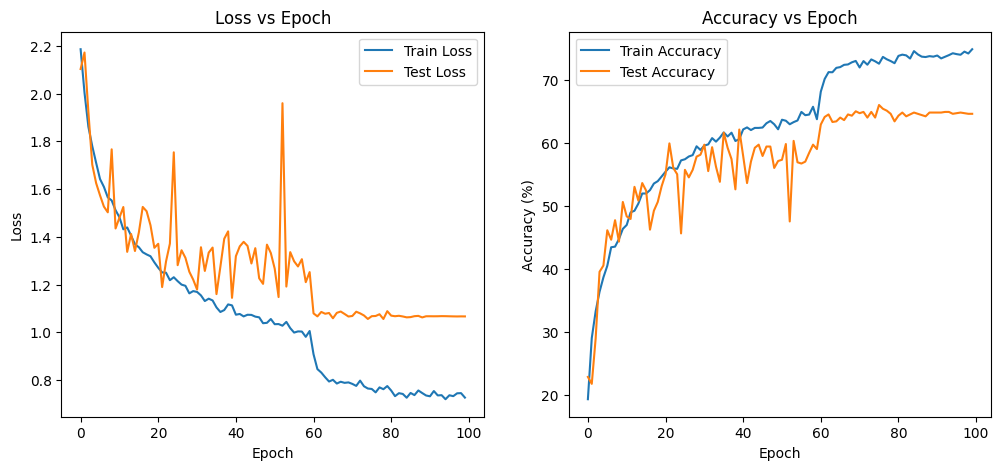

In [19]:
from torch.optim.lr_scheduler import MultiStepLR
model_tinyVGG_V2 = TinyVGGModel(3, 30, 10, 2).to(device)
model_tinyVGG_V2

optimizer_tinyVGG_V2 = torch.optim.SGD(params=model_tinyVGG_V2.parameters(),
                            lr=0.1)

scheduler_tinyVGG_V2 = MultiStepLR(optimizer_tinyVGG_V2, milestones=[60, 80, 90], gamma=0.1)

train_model_scheduler(model_tinyVGG_V2,
            train_aug_subset_loader,
            test_subset_loader,
            loss_fn, optimizer_tinyVGG_V2,
            accuracy, scheduler_tinyVGG_V2,
            epochs=100, device=device)

# Transfer learning


In [37]:
import torch
import torchvision.models as models
!pip install torchinfo
from torchinfo import summary

# Load pre-trained ResNet18
model_resnet = models.resnet18(pretrained=True)

for param in model_resnet.parameters():
    param.requires_grad = False
model_resnet.fc.requires_grad = True

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [38]:
model_summary = summary(model=model_resnet,
        input_size=(32, 3, 224, 224),
        col_names= ["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)
print(model_summary)



Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   False
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (36,864)             False
│    │    └─

In [39]:
model_resnet.fc = torch.nn.Linear(model_resnet.fc.in_features, 10)

model_summary_2 = summary(model=model_resnet,
        input_size=(32, 3, 224, 224),
        col_names= ["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)
print(model_summary_2)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 10]             --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (36,864)             False
│    │    

In [40]:
weights = models.ResNet18_Weights.DEFAULT
weights

auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [41]:

transform_resnet = transforms.Compose([
    transforms.Resize((224, 224)),  # Directly resize
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

train_resnet_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),   # Randomly flip images horizontally
    transforms.RandomRotation(15),       # Randomly rotate by up to 15 degrees
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),  # Random crop and resize
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Random color jitter
    transform_resnet  # Apply preprocessing (ToTensor and Normalize) after augmentation
])

# Create CIFAR10 dataset with the new transformations for resnet
train_aug_resnet_dataset = CIFAR10(root="data", train=True, download=True, transform=train_resnet_transform)
test_aug_resnet_dataset = CIFAR10(root="data", train=False, download=True, transform=train_resnet_transform)

# DataLoader for training dataset
train_aug_resnet_dataloader = DataLoader(train_aug_resnet_dataset, batch_size=32, shuffle=True)
teset_aug_resnet_dataloader = DataLoader(test_aug_resnet_dataset, batch_size=32, shuffle=True)

#creating subset for expriemnting
train_aug_resnet_subset = Subset(train_aug_resnet_dataset, train_indices)
train_aug__resmet_subset_loader = DataLoader(train_aug_resnet_subset, batch_size=32, shuffle=True)


test_aug_resnet_subset = Subset(test_aug_resnet_dataset, test_indices)
test_aug__resmet_subset_loader = DataLoader(test_aug_resnet_subset, batch_size=32, shuffle=True)

Image dimensions: Width = 224, Height = 224, Channels = 3


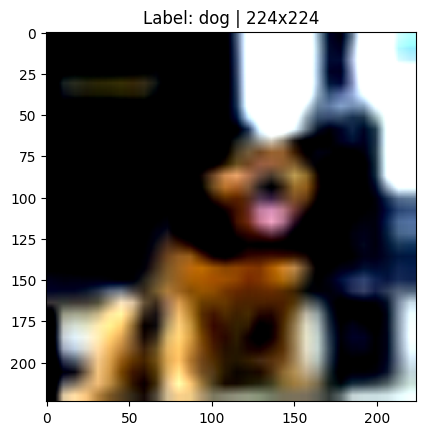

In [36]:
# Pick a random index
idx = random.randint(0, len(train_aug_resnet_dataset) - 1)

img, label = train_aug_resnet_dataset[idx]
class_name = train_aug_resnet_dataset.classes[label]

channels, height, width = img.shape
print(f"Image dimensions: Width = {width}, Height = {height}, Channels = {channels}")

img = img / 2 + 0.5

# Convert tensor to numpy
np_img = np.transpose(img.numpy(), (1, 2, 0))

# Show image
plt.imshow(np_img)
plt.title(f"Label: {train_aug_resnet_dataset.classes[label]} | {width}x{height}")
plt.show()

In [44]:


optimizer_resnet = torch.optim.SGD(params=model_resnet.parameters(),
                            lr=0.1)

scheduler_resnet =  StepLR(optimizer_resnet, step_size=15, gamma=0.1)

train_model_scheduler(model_resnet,
            train_aug__resmet_subset_loader,
            test_aug__resmet_subset_loader,
            loss_fn, optimizer_resnet,
            accuracy, scheduler_resnet,
            epochs=50, device=device)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
---------


Epochs:   0%|          | 0/50 [02:37<?, ?it/s]


KeyboardInterrupt: 

## Using MobileNet_V2

In [51]:

weights = models.MobileNet_V2_Weights.DEFAULT
model_mobilenet_v2 = models.mobilenet_v2(pretrained=True)
transform = weights.transforms()

In [53]:

model_mobilenet_v2.classifier[1] = torch.nn.Linear(model_mobilenet_v2.classifier[1].in_features, 10)

for param in model_mobilenet_v2.parameters():
    param.requires_grad = False

model_mobilenet_v2_summary_2 = summary(model=model_mobilenet_v2,
        input_size=(32, 3, 32, 32), # make sure this is "input_size", not "input_shape"
        col_names= ["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

print(model_mobilenet_v2_summary_2)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
MobileNetV2 (MobileNetV2)                     [32, 3, 32, 32]      [32, 10]             --                   Partial
├─Sequential (features)                       [32, 3, 32, 32]      [32, 1280, 1, 1]     --                   False
│    └─Conv2dNormActivation (0)               [32, 3, 32, 32]      [32, 32, 16, 16]     --                   False
│    │    └─Conv2d (0)                        [32, 3, 32, 32]      [32, 32, 16, 16]     (864)                False
│    │    └─BatchNorm2d (1)                   [32, 32, 16, 16]     [32, 32, 16, 16]     (64)                 False
│    │    └─ReLU6 (2)                         [32, 32, 16, 16]     [32, 32, 16, 16]     --                   --
│    └─InvertedResidual (1)                   [32, 32, 16, 16]     [32, 16, 16, 16]     --                   False
│    │    └─Sequential (conv)                 [32, 32, 16, 16]     [32, 16, 1

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 2.27284 | Train accuracy: 22.64%


Epochs:   2%|▏         | 1/50 [00:18<15:17, 18.73s/it]

Test loss: 2.20168 | Test accuracy: 30.90%

Epoch 1, Learning Rate: 0.1
Epoch: 1
---------
Train loss: 2.34540 | Train accuracy: 25.78%


Epochs:   4%|▍         | 2/50 [00:39<16:02, 20.04s/it]

Test loss: 2.28180 | Test accuracy: 28.60%

Epoch 2, Learning Rate: 0.1
Epoch: 2
---------
Train loss: 2.42670 | Train accuracy: 25.14%


Epochs:   6%|▌         | 3/50 [01:01<16:09, 20.63s/it]

Test loss: 2.35820 | Test accuracy: 29.40%

Epoch 3, Learning Rate: 0.1
Epoch: 3
---------
Train loss: 2.42611 | Train accuracy: 25.74%


Epochs:   8%|▊         | 4/50 [01:19<15:15, 19.91s/it]

Test loss: 2.32137 | Test accuracy: 30.60%

Epoch 4, Learning Rate: 0.1
Epoch: 4
---------
Train loss: 2.48868 | Train accuracy: 25.08%


Epochs:  10%|█         | 5/50 [01:39<14:47, 19.73s/it]

Test loss: 2.34014 | Test accuracy: 31.50%

Epoch 5, Learning Rate: 0.1
Epoch: 5
---------
Train loss: 2.46363 | Train accuracy: 24.76%


Epochs:  12%|█▏        | 6/50 [01:59<14:38, 19.97s/it]

Test loss: 2.28382 | Test accuracy: 32.90%

Epoch 6, Learning Rate: 0.1
Epoch: 6
---------
Train loss: 2.51162 | Train accuracy: 24.32%


Epochs:  14%|█▍        | 7/50 [02:23<15:16, 21.32s/it]

Test loss: 2.34431 | Test accuracy: 30.60%

Epoch 7, Learning Rate: 0.1
Epoch: 7
---------
Train loss: 2.50664 | Train accuracy: 25.42%


Epochs:  16%|█▌        | 8/50 [02:45<15:07, 21.61s/it]

Test loss: 2.41052 | Test accuracy: 30.80%

Epoch 8, Learning Rate: 0.1
Epoch: 8
---------
Train loss: 2.53185 | Train accuracy: 25.32%


Epochs:  18%|█▊        | 9/50 [03:05<14:22, 21.04s/it]

Test loss: 2.39642 | Test accuracy: 34.70%

Epoch 9, Learning Rate: 0.1
Epoch: 9
---------
Train loss: 2.52671 | Train accuracy: 25.70%


Epochs:  20%|██        | 10/50 [03:27<14:13, 21.35s/it]

Test loss: 2.53397 | Test accuracy: 28.60%

Epoch 10, Learning Rate: 0.1
Epoch: 10
---------
Train loss: 2.49124 | Train accuracy: 25.20%


Epochs:  22%|██▏       | 11/50 [03:53<14:46, 22.74s/it]

Test loss: 2.33642 | Test accuracy: 30.30%

Epoch 11, Learning Rate: 0.1
Epoch: 11
---------
Train loss: 2.53341 | Train accuracy: 24.58%


Epochs:  24%|██▍       | 12/50 [04:14<14:02, 22.18s/it]

Test loss: 2.34803 | Test accuracy: 32.30%

Epoch 12, Learning Rate: 0.1
Epoch: 12
---------
Train loss: 2.52417 | Train accuracy: 24.40%


Epochs:  26%|██▌       | 13/50 [04:33<13:05, 21.23s/it]

Test loss: 2.37735 | Test accuracy: 32.50%

Epoch 13, Learning Rate: 0.1
Epoch: 13
---------
Train loss: 2.52160 | Train accuracy: 24.92%


Epochs:  28%|██▊       | 14/50 [04:52<12:14, 20.41s/it]

Test loss: 2.33966 | Test accuracy: 31.20%

Epoch 14, Learning Rate: 0.1
Epoch: 14
---------
Train loss: 2.49663 | Train accuracy: 26.04%


Epochs:  30%|███       | 15/50 [05:11<11:44, 20.13s/it]

Test loss: 2.29023 | Test accuracy: 31.50%

Epoch 15, Learning Rate: 0.010000000000000002
Epoch: 15
---------
Train loss: 2.45312 | Train accuracy: 25.96%


Epochs:  32%|███▏      | 16/50 [05:31<11:20, 20.03s/it]

Test loss: 2.20733 | Test accuracy: 32.40%

Epoch 16, Learning Rate: 0.010000000000000002
Epoch: 16
---------
Train loss: 2.34308 | Train accuracy: 26.50%


Epochs:  34%|███▍      | 17/50 [05:51<11:02, 20.07s/it]

Test loss: 2.10544 | Test accuracy: 34.20%

Epoch 17, Learning Rate: 0.010000000000000002
Epoch: 17
---------
Train loss: 2.29272 | Train accuracy: 28.36%


Epochs:  36%|███▌      | 18/50 [06:12<10:53, 20.41s/it]

Test loss: 2.06093 | Test accuracy: 35.40%

Epoch 18, Learning Rate: 0.010000000000000002
Epoch: 18
---------
Train loss: 2.24129 | Train accuracy: 27.74%


Epochs:  38%|███▊      | 19/50 [06:31<10:15, 19.85s/it]

Test loss: 2.03358 | Test accuracy: 35.30%

Epoch 19, Learning Rate: 0.010000000000000002
Epoch: 19
---------
Train loss: 2.24037 | Train accuracy: 27.22%


Epochs:  40%|████      | 20/50 [06:51<10:00, 20.01s/it]

Test loss: 2.01339 | Test accuracy: 35.60%

Epoch 20, Learning Rate: 0.010000000000000002
Epoch: 20
---------
Train loss: 2.20137 | Train accuracy: 27.46%


Epochs:  42%|████▏     | 21/50 [07:10<09:31, 19.71s/it]

Test loss: 2.01003 | Test accuracy: 34.70%

Epoch 21, Learning Rate: 0.010000000000000002
Epoch: 21
---------
Train loss: 2.16100 | Train accuracy: 28.28%


Epochs:  44%|████▍     | 22/50 [07:33<09:36, 20.60s/it]

Test loss: 1.99150 | Test accuracy: 35.00%

Epoch 22, Learning Rate: 0.010000000000000002
Epoch: 22
---------
Train loss: 2.16898 | Train accuracy: 28.40%


Epochs:  46%|████▌     | 23/50 [07:53<09:11, 20.42s/it]

Test loss: 1.99779 | Test accuracy: 34.80%

Epoch 23, Learning Rate: 0.010000000000000002
Epoch: 23
---------
Train loss: 2.15322 | Train accuracy: 27.64%


Epochs:  48%|████▊     | 24/50 [08:17<09:17, 21.45s/it]

Test loss: 1.95514 | Test accuracy: 35.90%

Epoch 24, Learning Rate: 0.010000000000000002
Epoch: 24
---------
Train loss: 2.11778 | Train accuracy: 28.40%


Epochs:  50%|█████     | 25/50 [08:39<09:03, 21.74s/it]

Test loss: 1.90768 | Test accuracy: 37.10%

Epoch 25, Learning Rate: 0.010000000000000002
Epoch: 25
---------
Train loss: 2.09205 | Train accuracy: 28.92%


Epochs:  52%|█████▏    | 26/50 [09:01<08:40, 21.71s/it]

Test loss: 1.92649 | Test accuracy: 35.40%

Epoch 26, Learning Rate: 0.010000000000000002
Epoch: 26
---------
Train loss: 2.09464 | Train accuracy: 28.72%


Epochs:  54%|█████▍    | 27/50 [09:26<08:44, 22.80s/it]

Test loss: 1.93185 | Test accuracy: 38.40%

Epoch 27, Learning Rate: 0.010000000000000002
Epoch: 27
---------
Train loss: 2.11621 | Train accuracy: 27.76%


Epochs:  56%|█████▌    | 28/50 [09:46<08:03, 21.99s/it]

Test loss: 1.89839 | Test accuracy: 37.70%

Epoch 28, Learning Rate: 0.010000000000000002
Epoch: 28
---------
Train loss: 2.07093 | Train accuracy: 29.40%


Epochs:  58%|█████▊    | 29/50 [10:07<07:31, 21.52s/it]

Test loss: 1.88218 | Test accuracy: 37.30%

Epoch 29, Learning Rate: 0.010000000000000002
Epoch: 29
---------
Train loss: 2.04663 | Train accuracy: 29.30%


Epochs:  60%|██████    | 30/50 [10:27<07:03, 21.17s/it]

Test loss: 1.87681 | Test accuracy: 36.50%

Epoch 30, Learning Rate: 0.0010000000000000002
Epoch: 30
---------
Train loss: 2.09311 | Train accuracy: 27.76%


Epochs:  62%|██████▏   | 31/50 [10:46<06:30, 20.54s/it]

Test loss: 1.84951 | Test accuracy: 37.30%

Epoch 31, Learning Rate: 0.0010000000000000002
Epoch: 31
---------
Train loss: 2.04560 | Train accuracy: 29.22%


Epochs:  64%|██████▍   | 32/50 [11:06<06:05, 20.29s/it]

Test loss: 1.85820 | Test accuracy: 38.30%

Epoch 32, Learning Rate: 0.0010000000000000002
Epoch: 32
---------
Train loss: 2.07545 | Train accuracy: 28.76%


Epochs:  66%|██████▌   | 33/50 [11:25<05:38, 19.92s/it]

Test loss: 1.86414 | Test accuracy: 38.80%

Epoch 33, Learning Rate: 0.0010000000000000002
Epoch: 33
---------
Train loss: 2.03482 | Train accuracy: 29.06%


Epochs:  68%|██████▊   | 34/50 [11:43<05:11, 19.45s/it]

Test loss: 1.90020 | Test accuracy: 36.50%

Epoch 34, Learning Rate: 0.0010000000000000002
Epoch: 34
---------
Train loss: 2.03583 | Train accuracy: 29.36%


Epochs:  70%|███████   | 35/50 [12:03<04:53, 19.58s/it]

Test loss: 1.87147 | Test accuracy: 36.80%

Epoch 35, Learning Rate: 0.0010000000000000002
Epoch: 35
---------
Train loss: 2.03525 | Train accuracy: 30.86%


Epochs:  72%|███████▏  | 36/50 [12:21<04:28, 19.20s/it]

Test loss: 1.86647 | Test accuracy: 39.70%

Epoch 36, Learning Rate: 0.0010000000000000002
Epoch: 36
---------
Train loss: 2.04744 | Train accuracy: 29.28%


Epochs:  74%|███████▍  | 37/50 [12:40<04:08, 19.15s/it]

Test loss: 1.88387 | Test accuracy: 37.00%

Epoch 37, Learning Rate: 0.0010000000000000002
Epoch: 37
---------
Train loss: 2.05446 | Train accuracy: 29.16%


Epochs:  76%|███████▌  | 38/50 [12:59<03:48, 19.07s/it]

Test loss: 1.88445 | Test accuracy: 36.10%

Epoch 38, Learning Rate: 0.0010000000000000002
Epoch: 38
---------
Train loss: 2.04934 | Train accuracy: 30.20%


Epochs:  78%|███████▊  | 39/50 [13:19<03:30, 19.11s/it]

Test loss: 1.88474 | Test accuracy: 36.60%

Epoch 39, Learning Rate: 0.0010000000000000002
Epoch: 39
---------
Train loss: 2.02823 | Train accuracy: 30.02%


Epochs:  80%|████████  | 40/50 [13:37<03:08, 18.85s/it]

Test loss: 1.83115 | Test accuracy: 38.60%

Epoch 40, Learning Rate: 0.0010000000000000002
Epoch: 40
---------
Train loss: 2.02198 | Train accuracy: 30.04%


Epochs:  82%|████████▏ | 41/50 [13:56<02:50, 18.95s/it]

Test loss: 1.86578 | Test accuracy: 38.00%

Epoch 41, Learning Rate: 0.0010000000000000002
Epoch: 41
---------
Train loss: 2.03585 | Train accuracy: 29.44%


Epochs:  84%|████████▍ | 42/50 [14:15<02:30, 18.82s/it]

Test loss: 1.87031 | Test accuracy: 37.80%

Epoch 42, Learning Rate: 0.0010000000000000002
Epoch: 42
---------
Train loss: 2.01838 | Train accuracy: 29.72%


Epochs:  86%|████████▌ | 43/50 [14:33<02:12, 18.87s/it]

Test loss: 1.81492 | Test accuracy: 38.50%

Epoch 43, Learning Rate: 0.0010000000000000002
Epoch: 43
---------
Train loss: 2.03985 | Train accuracy: 29.66%


Epochs:  88%|████████▊ | 44/50 [14:52<01:52, 18.69s/it]

Test loss: 1.81800 | Test accuracy: 38.40%

Epoch 44, Learning Rate: 0.0010000000000000002
Epoch: 44
---------
Train loss: 2.03472 | Train accuracy: 30.98%


Epochs:  90%|█████████ | 45/50 [15:10<01:33, 18.69s/it]

Test loss: 1.84163 | Test accuracy: 39.10%

Epoch 45, Learning Rate: 0.00010000000000000003
Epoch: 45
---------
Train loss: 2.01302 | Train accuracy: 30.80%


Epochs:  92%|█████████▏| 46/50 [15:29<01:14, 18.71s/it]

Test loss: 1.85593 | Test accuracy: 38.50%

Epoch 46, Learning Rate: 0.00010000000000000003
Epoch: 46
---------
Train loss: 2.02591 | Train accuracy: 30.38%


Epochs:  94%|█████████▍| 47/50 [15:48<00:56, 18.72s/it]

Test loss: 1.83711 | Test accuracy: 36.50%

Epoch 47, Learning Rate: 0.00010000000000000003
Epoch: 47
---------
Train loss: 2.02950 | Train accuracy: 29.78%


Epochs:  96%|█████████▌| 48/50 [16:07<00:37, 18.77s/it]

Test loss: 1.84134 | Test accuracy: 40.10%

Epoch 48, Learning Rate: 0.00010000000000000003
Epoch: 48
---------
Train loss: 2.02394 | Train accuracy: 31.10%


Epochs:  98%|█████████▊| 49/50 [16:25<00:18, 18.62s/it]

Test loss: 1.82668 | Test accuracy: 36.70%

Epoch 49, Learning Rate: 0.00010000000000000003
Epoch: 49
---------
Train loss: 2.03353 | Train accuracy: 28.98%


Epochs: 100%|██████████| 50/50 [16:44<00:00, 20.10s/it]

Test loss: 1.84859 | Test accuracy: 39.00%

Epoch 50, Learning Rate: 0.00010000000000000003
Training and testing took 1004.774 seconds


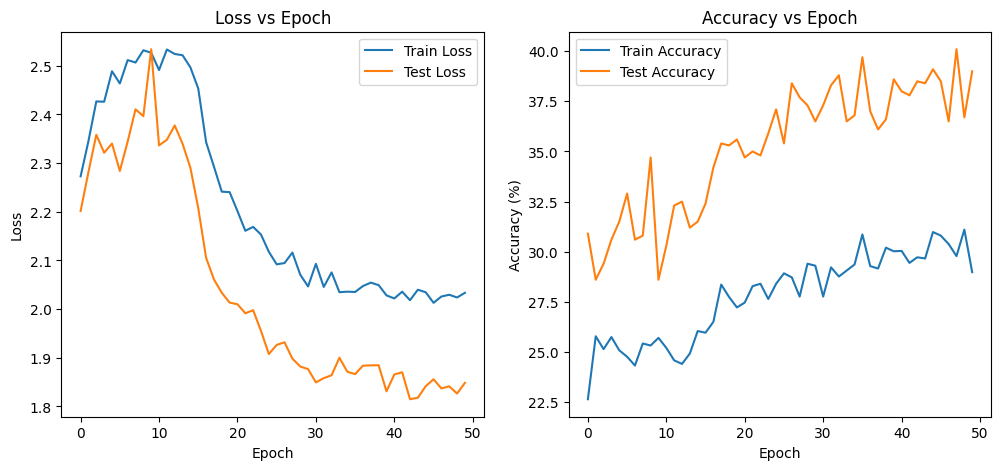

In [54]:
# Direct training without mobilenet's transformation
optimizer_mobilenet_v2 = torch.optim.SGD(params=model_mobilenet_v2.parameters(),
                            lr=0.1)

scheduler_mobilenet_v2 =  StepLR(optimizer_mobilenet_v2, step_size=15, gamma=0.1)

train_model_scheduler(model_mobilenet_v2,
            train_aug_subset_loader,
            test_subset_loader,
            loss_fn, optimizer_mobilenet_v2,
            accuracy, scheduler_mobilenet_v2,
            epochs=50, device=device)

In [55]:
#training with mobilenet's transformation
transform_model_mobilenet_v2 = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])


train_mobilenet_v2_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),   # Randomly flip images horizontally
    transforms.RandomRotation(15),       # Randomly rotate by up to 15 degrees
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),  # Random crop and resize
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Random color jitter
    transform_model_mobilenet_v2  # Apply preprocessing (ToTensor and Normalize) after augmentation
])

# Create CIFAR10 dataset with the new transformations for mobilenet_v2
train_aug_mobilenet_dataset = CIFAR10(root="data", train=True, download=True, transform=train_mobilenet_v2_transform)
test_mobilenet_dataset = CIFAR10(root="data", train=False, download=True, transform=transform_model_mobilenet_v2)

# DataLoader for training dataset
train_aug_mobilenet_dataloader = DataLoader(train_aug_mobilenet_dataset, batch_size=32, shuffle=True)
teset_mobilenet_dataloader = DataLoader(test_mobilenet_dataset, batch_size=32, shuffle=True)

#creating subset for expriemnting
train_aug_mobilenet_subset = Subset(train_aug_mobilenet_dataset, train_indices)
train_aug__mobilenet_subset_loader = DataLoader(train_aug_mobilenet_subset, batch_size=32, shuffle=True)


test_mobilenet_subset = Subset(test_mobilenet_dataset, test_indices)
test_mobilenet_subset_loader = DataLoader(test_mobilenet_subset, batch_size=32, shuffle=True)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.74758 | Train accuracy: 43.74%


Epochs:   2%|▏         | 1/50 [02:30<2:02:38, 150.17s/it]

Test loss: 1.21680 | Test accuracy: 61.80%

Epoch 1, Learning Rate: 0.01
Epoch: 1
---------
Train loss: 1.65113 | Train accuracy: 49.98%


Epochs:   4%|▍         | 2/50 [04:58<1:59:29, 149.37s/it]

Test loss: 1.42891 | Test accuracy: 58.10%

Epoch 2, Learning Rate: 0.01
Epoch: 2
---------
Train loss: 1.74549 | Train accuracy: 49.40%


Epochs:   6%|▌         | 3/50 [07:26<1:56:24, 148.61s/it]

Test loss: 1.24732 | Test accuracy: 65.00%

Epoch 3, Learning Rate: 0.01
Epoch: 3
---------
Train loss: 1.72220 | Train accuracy: 50.58%


Epochs:   8%|▊         | 4/50 [09:56<1:54:15, 149.03s/it]

Test loss: 1.26546 | Test accuracy: 63.70%

Epoch 4, Learning Rate: 0.01
Epoch: 4
---------
Train loss: 1.76917 | Train accuracy: 50.52%


Epochs:  10%|█         | 5/50 [12:26<1:52:00, 149.34s/it]

Test loss: 1.15820 | Test accuracy: 65.20%

Epoch 5, Learning Rate: 0.01
Epoch: 5
---------
Train loss: 1.77524 | Train accuracy: 50.44%


Epochs:  12%|█▏        | 6/50 [14:56<1:49:38, 149.51s/it]

Test loss: 1.41542 | Test accuracy: 61.30%

Epoch 6, Learning Rate: 0.01
Epoch: 6
---------
Train loss: 1.88252 | Train accuracy: 49.14%


Epochs:  14%|█▍        | 7/50 [17:25<1:47:14, 149.64s/it]

Test loss: 1.21338 | Test accuracy: 65.70%

Epoch 7, Learning Rate: 0.01
Epoch: 7
---------
Train loss: 1.81587 | Train accuracy: 50.74%


Epochs:  16%|█▌        | 8/50 [19:55<1:44:48, 149.73s/it]

Test loss: 1.12406 | Test accuracy: 67.10%

Epoch 8, Learning Rate: 0.01
Epoch: 8
---------
Train loss: 1.77101 | Train accuracy: 51.24%


Epochs:  18%|█▊        | 9/50 [22:26<1:42:23, 149.85s/it]

Test loss: 1.65217 | Test accuracy: 63.30%

Epoch 9, Learning Rate: 0.01
Epoch: 9
---------
Train loss: 1.78376 | Train accuracy: 51.02%


Epochs:  20%|██        | 10/50 [24:55<1:39:52, 149.81s/it]

Test loss: 1.22986 | Test accuracy: 64.10%

Epoch 10, Learning Rate: 0.01
Epoch: 10
---------
Train loss: 1.85678 | Train accuracy: 50.86%


Epochs:  22%|██▏       | 11/50 [27:25<1:37:21, 149.77s/it]

Test loss: 1.17724 | Test accuracy: 65.80%

Epoch 11, Learning Rate: 0.01
Epoch: 11
---------
Train loss: 1.81038 | Train accuracy: 50.56%


Epochs:  24%|██▍       | 12/50 [29:55<1:34:59, 150.00s/it]

Test loss: 1.70268 | Test accuracy: 59.50%

Epoch 12, Learning Rate: 0.01
Epoch: 12
---------
Train loss: 1.77765 | Train accuracy: 52.22%


Epochs:  26%|██▌       | 13/50 [32:27<1:32:45, 150.42s/it]

Test loss: 1.52371 | Test accuracy: 62.10%

Epoch 13, Learning Rate: 0.01
Epoch: 13
---------
Train loss: 1.84882 | Train accuracy: 50.32%


Epochs:  28%|██▊       | 14/50 [34:58<1:30:24, 150.67s/it]

Test loss: 1.11779 | Test accuracy: 68.60%

Epoch 14, Learning Rate: 0.01
Epoch: 14
---------
Train loss: 1.80393 | Train accuracy: 52.20%


Epochs:  30%|███       | 15/50 [37:30<1:28:05, 151.00s/it]

Test loss: 1.30170 | Test accuracy: 63.30%

Epoch 15, Learning Rate: 0.001
Epoch: 15
---------
Train loss: 1.57228 | Train accuracy: 54.58%


Epochs:  32%|███▏      | 16/50 [40:01<1:25:37, 151.11s/it]

Test loss: 1.04916 | Test accuracy: 67.40%

Epoch 16, Learning Rate: 0.001
Epoch: 16
---------
Train loss: 1.51810 | Train accuracy: 54.92%


Epochs:  34%|███▍      | 17/50 [42:33<1:23:09, 151.20s/it]

Test loss: 1.02411 | Test accuracy: 69.00%

Epoch 17, Learning Rate: 0.001
Epoch: 17
---------
Train loss: 1.42717 | Train accuracy: 56.84%


Epochs:  36%|███▌      | 18/50 [45:03<1:20:31, 151.00s/it]

Test loss: 0.99907 | Test accuracy: 67.70%

Epoch 18, Learning Rate: 0.001
Epoch: 18
---------
Train loss: 1.41072 | Train accuracy: 56.90%


Epochs:  38%|███▊      | 19/50 [47:34<1:18:00, 150.97s/it]

Test loss: 0.98010 | Test accuracy: 68.90%

Epoch 19, Learning Rate: 0.001
Epoch: 19
---------
Train loss: 1.38880 | Train accuracy: 56.98%


Epochs:  40%|████      | 20/50 [50:05<1:15:24, 150.81s/it]

Test loss: 0.96197 | Test accuracy: 69.30%

Epoch 20, Learning Rate: 0.001
Epoch: 20
---------
Train loss: 1.37390 | Train accuracy: 56.98%


Epochs:  42%|████▏     | 21/50 [52:35<1:12:47, 150.60s/it]

Test loss: 0.94101 | Test accuracy: 70.70%

Epoch 21, Learning Rate: 0.001
Epoch: 21
---------
Train loss: 1.39372 | Train accuracy: 56.38%


Epochs:  44%|████▍     | 22/50 [55:06<1:10:19, 150.70s/it]

Test loss: 0.97816 | Test accuracy: 69.10%

Epoch 22, Learning Rate: 0.001
Epoch: 22
---------
Train loss: 1.33462 | Train accuracy: 58.54%


Epochs:  46%|████▌     | 23/50 [57:35<1:07:37, 150.26s/it]

Test loss: 0.92405 | Test accuracy: 70.20%

Epoch 23, Learning Rate: 0.001
Epoch: 23
---------
Train loss: 1.36452 | Train accuracy: 56.18%


Epochs:  48%|████▊     | 24/50 [1:00:03<1:04:50, 149.62s/it]

Test loss: 0.94586 | Test accuracy: 69.20%

Epoch 24, Learning Rate: 0.001
Epoch: 24
---------
Train loss: 1.31530 | Train accuracy: 58.38%


Epochs:  50%|█████     | 25/50 [1:02:33<1:02:20, 149.63s/it]

Test loss: 0.89857 | Test accuracy: 70.40%

Epoch 25, Learning Rate: 0.001
Epoch: 25
---------
Train loss: 1.33046 | Train accuracy: 56.98%


Epochs:  52%|█████▏    | 26/50 [1:05:02<59:48, 149.51s/it]  

Test loss: 0.87978 | Test accuracy: 70.00%

Epoch 26, Learning Rate: 0.001
Epoch: 26
---------
Train loss: 1.32101 | Train accuracy: 57.22%


Epochs:  54%|█████▍    | 27/50 [1:07:31<57:16, 149.42s/it]

Test loss: 0.88886 | Test accuracy: 69.70%

Epoch 27, Learning Rate: 0.001
Epoch: 27
---------
Train loss: 1.30033 | Train accuracy: 56.78%


Epochs:  56%|█████▌    | 28/50 [1:10:01<54:50, 149.57s/it]

Test loss: 0.89702 | Test accuracy: 70.30%

Epoch 28, Learning Rate: 0.001
Epoch: 28
---------
Train loss: 1.32633 | Train accuracy: 56.48%


Epochs:  58%|█████▊    | 29/50 [1:12:32<52:28, 149.92s/it]

Test loss: 0.95466 | Test accuracy: 69.40%

Epoch 29, Learning Rate: 0.001
Epoch: 29
---------
Train loss: 1.30459 | Train accuracy: 56.94%


Epochs:  60%|██████    | 30/50 [1:15:00<49:50, 149.53s/it]

Test loss: 0.87175 | Test accuracy: 70.30%

Epoch 30, Learning Rate: 0.0001
Epoch: 30
---------
Train loss: 1.27934 | Train accuracy: 57.54%


Epochs:  62%|██████▏   | 31/50 [1:17:29<47:15, 149.25s/it]

Test loss: 0.86479 | Test accuracy: 71.70%

Epoch 31, Learning Rate: 0.0001
Epoch: 31
---------
Train loss: 1.24731 | Train accuracy: 58.66%


Epochs:  64%|██████▍   | 32/50 [1:19:57<44:42, 149.04s/it]

Test loss: 0.88575 | Test accuracy: 70.90%

Epoch 32, Learning Rate: 0.0001
Epoch: 32
---------
Train loss: 1.25828 | Train accuracy: 58.98%


Epochs:  66%|██████▌   | 33/50 [1:22:26<42:10, 148.85s/it]

Test loss: 0.85683 | Test accuracy: 71.30%

Epoch 33, Learning Rate: 0.0001
Epoch: 33
---------
Train loss: 1.27952 | Train accuracy: 57.76%


Epochs:  68%|██████▊   | 34/50 [1:24:54<39:40, 148.78s/it]

Test loss: 0.84824 | Test accuracy: 70.70%

Epoch 34, Learning Rate: 0.0001
Epoch: 34
---------
Train loss: 1.27306 | Train accuracy: 57.70%


Epochs:  70%|███████   | 35/50 [1:27:22<37:04, 148.29s/it]

Test loss: 0.86372 | Test accuracy: 70.40%

Epoch 35, Learning Rate: 0.0001
Epoch: 35
---------
Train loss: 1.30432 | Train accuracy: 57.32%


Epochs:  72%|███████▏  | 36/50 [1:29:51<34:41, 148.66s/it]

Test loss: 0.86060 | Test accuracy: 71.30%

Epoch 36, Learning Rate: 0.0001
Epoch: 36
---------
Train loss: 1.22819 | Train accuracy: 58.90%


Epochs:  74%|███████▍  | 37/50 [1:32:20<32:12, 148.64s/it]

Test loss: 0.85450 | Test accuracy: 71.30%

Epoch 37, Learning Rate: 0.0001
Epoch: 37
---------
Train loss: 1.23874 | Train accuracy: 58.88%


Epochs:  76%|███████▌  | 38/50 [1:34:48<29:43, 148.62s/it]

Test loss: 0.85988 | Test accuracy: 71.60%

Epoch 38, Learning Rate: 0.0001
Epoch: 38
---------
Train loss: 1.28312 | Train accuracy: 56.58%


Epochs:  78%|███████▊  | 39/50 [1:37:21<27:27, 149.73s/it]

Test loss: 0.84721 | Test accuracy: 71.60%

Epoch 39, Learning Rate: 0.0001
Epoch: 39
---------
Train loss: 1.23124 | Train accuracy: 59.44%


Epochs:  80%|████████  | 40/50 [1:39:52<25:00, 150.09s/it]

Test loss: 0.86946 | Test accuracy: 70.90%

Epoch 40, Learning Rate: 0.0001
Epoch: 40
---------
Train loss: 1.22409 | Train accuracy: 58.56%


Epochs:  82%|████████▏ | 41/50 [1:42:22<22:30, 150.08s/it]

Test loss: 0.86232 | Test accuracy: 70.10%

Epoch 41, Learning Rate: 0.0001
Epoch: 41
---------
Train loss: 1.25844 | Train accuracy: 58.58%


Epochs:  84%|████████▍ | 42/50 [1:44:51<19:58, 149.82s/it]

Test loss: 0.82986 | Test accuracy: 71.70%

Epoch 42, Learning Rate: 0.0001
Epoch: 42
---------
Train loss: 1.24933 | Train accuracy: 57.96%


Epochs:  86%|████████▌ | 43/50 [1:47:20<17:27, 149.64s/it]

Test loss: 0.83483 | Test accuracy: 71.60%

Epoch 43, Learning Rate: 0.0001
Epoch: 43
---------
Train loss: 1.25370 | Train accuracy: 58.36%


Epochs:  88%|████████▊ | 44/50 [1:49:50<14:57, 149.62s/it]

Test loss: 0.84559 | Test accuracy: 71.30%

Epoch 44, Learning Rate: 0.0001
Epoch: 44
---------
Train loss: 1.26840 | Train accuracy: 57.42%


Epochs:  90%|█████████ | 45/50 [1:52:20<12:29, 149.92s/it]

Test loss: 0.84435 | Test accuracy: 72.20%

Epoch 45, Learning Rate: 1e-05
Epoch: 45
---------
Train loss: 1.21828 | Train accuracy: 59.78%


Epochs:  92%|█████████▏| 46/50 [1:54:49<09:57, 149.49s/it]

Test loss: 0.84823 | Test accuracy: 71.20%

Epoch 46, Learning Rate: 1e-05
Epoch: 46
---------
Train loss: 1.25101 | Train accuracy: 58.76%


Epochs:  94%|█████████▍| 47/50 [1:57:17<07:27, 149.21s/it]

Test loss: 0.82095 | Test accuracy: 72.20%

Epoch 47, Learning Rate: 1e-05
Epoch: 47
---------
Train loss: 1.25684 | Train accuracy: 58.66%


Epochs:  96%|█████████▌| 48/50 [1:59:45<04:57, 148.89s/it]

Test loss: 0.83543 | Test accuracy: 72.20%

Epoch 48, Learning Rate: 1e-05
Epoch: 48
---------
Train loss: 1.25884 | Train accuracy: 58.02%


Epochs:  98%|█████████▊| 49/50 [2:02:13<02:28, 148.48s/it]

Test loss: 0.83651 | Test accuracy: 71.60%

Epoch 49, Learning Rate: 1e-05
Epoch: 49
---------
Train loss: 1.23795 | Train accuracy: 57.88%


Epochs: 100%|██████████| 50/50 [2:04:41<00:00, 149.64s/it]

Test loss: 0.86108 | Test accuracy: 70.90%

Epoch 50, Learning Rate: 1e-05
Training and testing took 7481.974 seconds


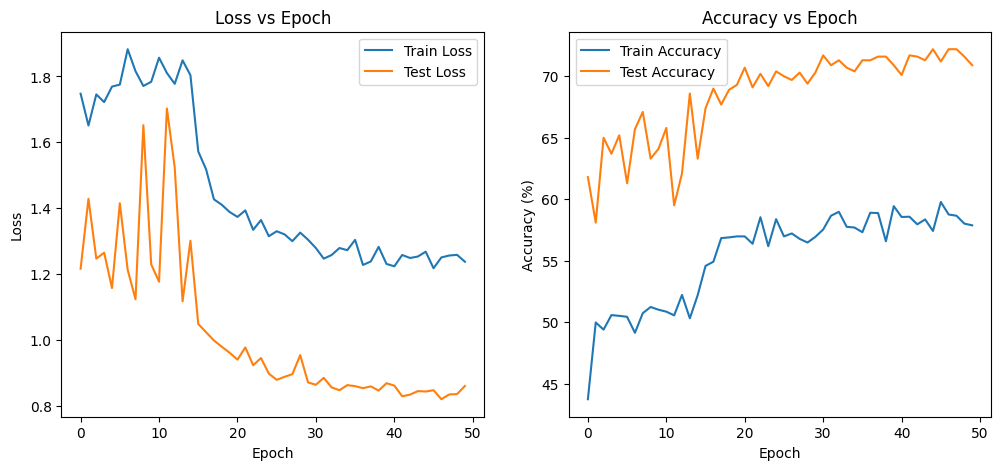

In [58]:

model_mobilenet_v2_2 = models.mobilenet_v2(pretrained=True)

# adapt classifier layer
model_mobilenet_v2_2.classifier[1] = torch.nn.Linear(
    model_mobilenet_v2_2.classifier[1].in_features, 10
)

# Freeze feature extractor
for param in model_mobilenet_v2_2.features.parameters():
    param.requires_grad = False

# Optimizer for classifier only
optimizer_mobilenet_v2_2 = torch.optim.SGD(
    model_mobilenet_v2_2.classifier.parameters(), lr=0.01, momentum=0.9
)

# Learning rate scheduler
scheduler_mobilenet_v2_2 = StepLR(optimizer_mobilenet_v2_2, step_size=15, gamma=0.1)

# Train
train_model_scheduler(model_mobilenet_v2_2,
            train_aug__mobilenet_subset_loader,
            test_mobilenet_subset_loader,
            loss_fn, optimizer_mobilenet_v2_2,
            accuracy, scheduler_mobilenet_v2_2,
            epochs=50, device=device)

On goinging ....